Loading file: Aug '25/Aug 07 Exp/01 Aug/5S/nse_nifty2580725300ce_min.csv
Strike: 5300, Option Type: CE
Data loaded successfully. Shape: (4500, 27)

Summary Statistics:
Strike Price                                                  5300
Option Type                                                     CE
Total Records                                                 4500
Date Range              2025-08-01 09:15:00 to 2025-08-01 15:29:55
Current Price                                                  6.5
Open Price                                                   14.65
Total Price Change                                           -8.15
Total Price Change %                                    -55.631399
Highest Price                                                 19.1
Lowest Price                                                  6.45
Average Price                                            11.735256
Total Volume                                              63782475
Average Volume              

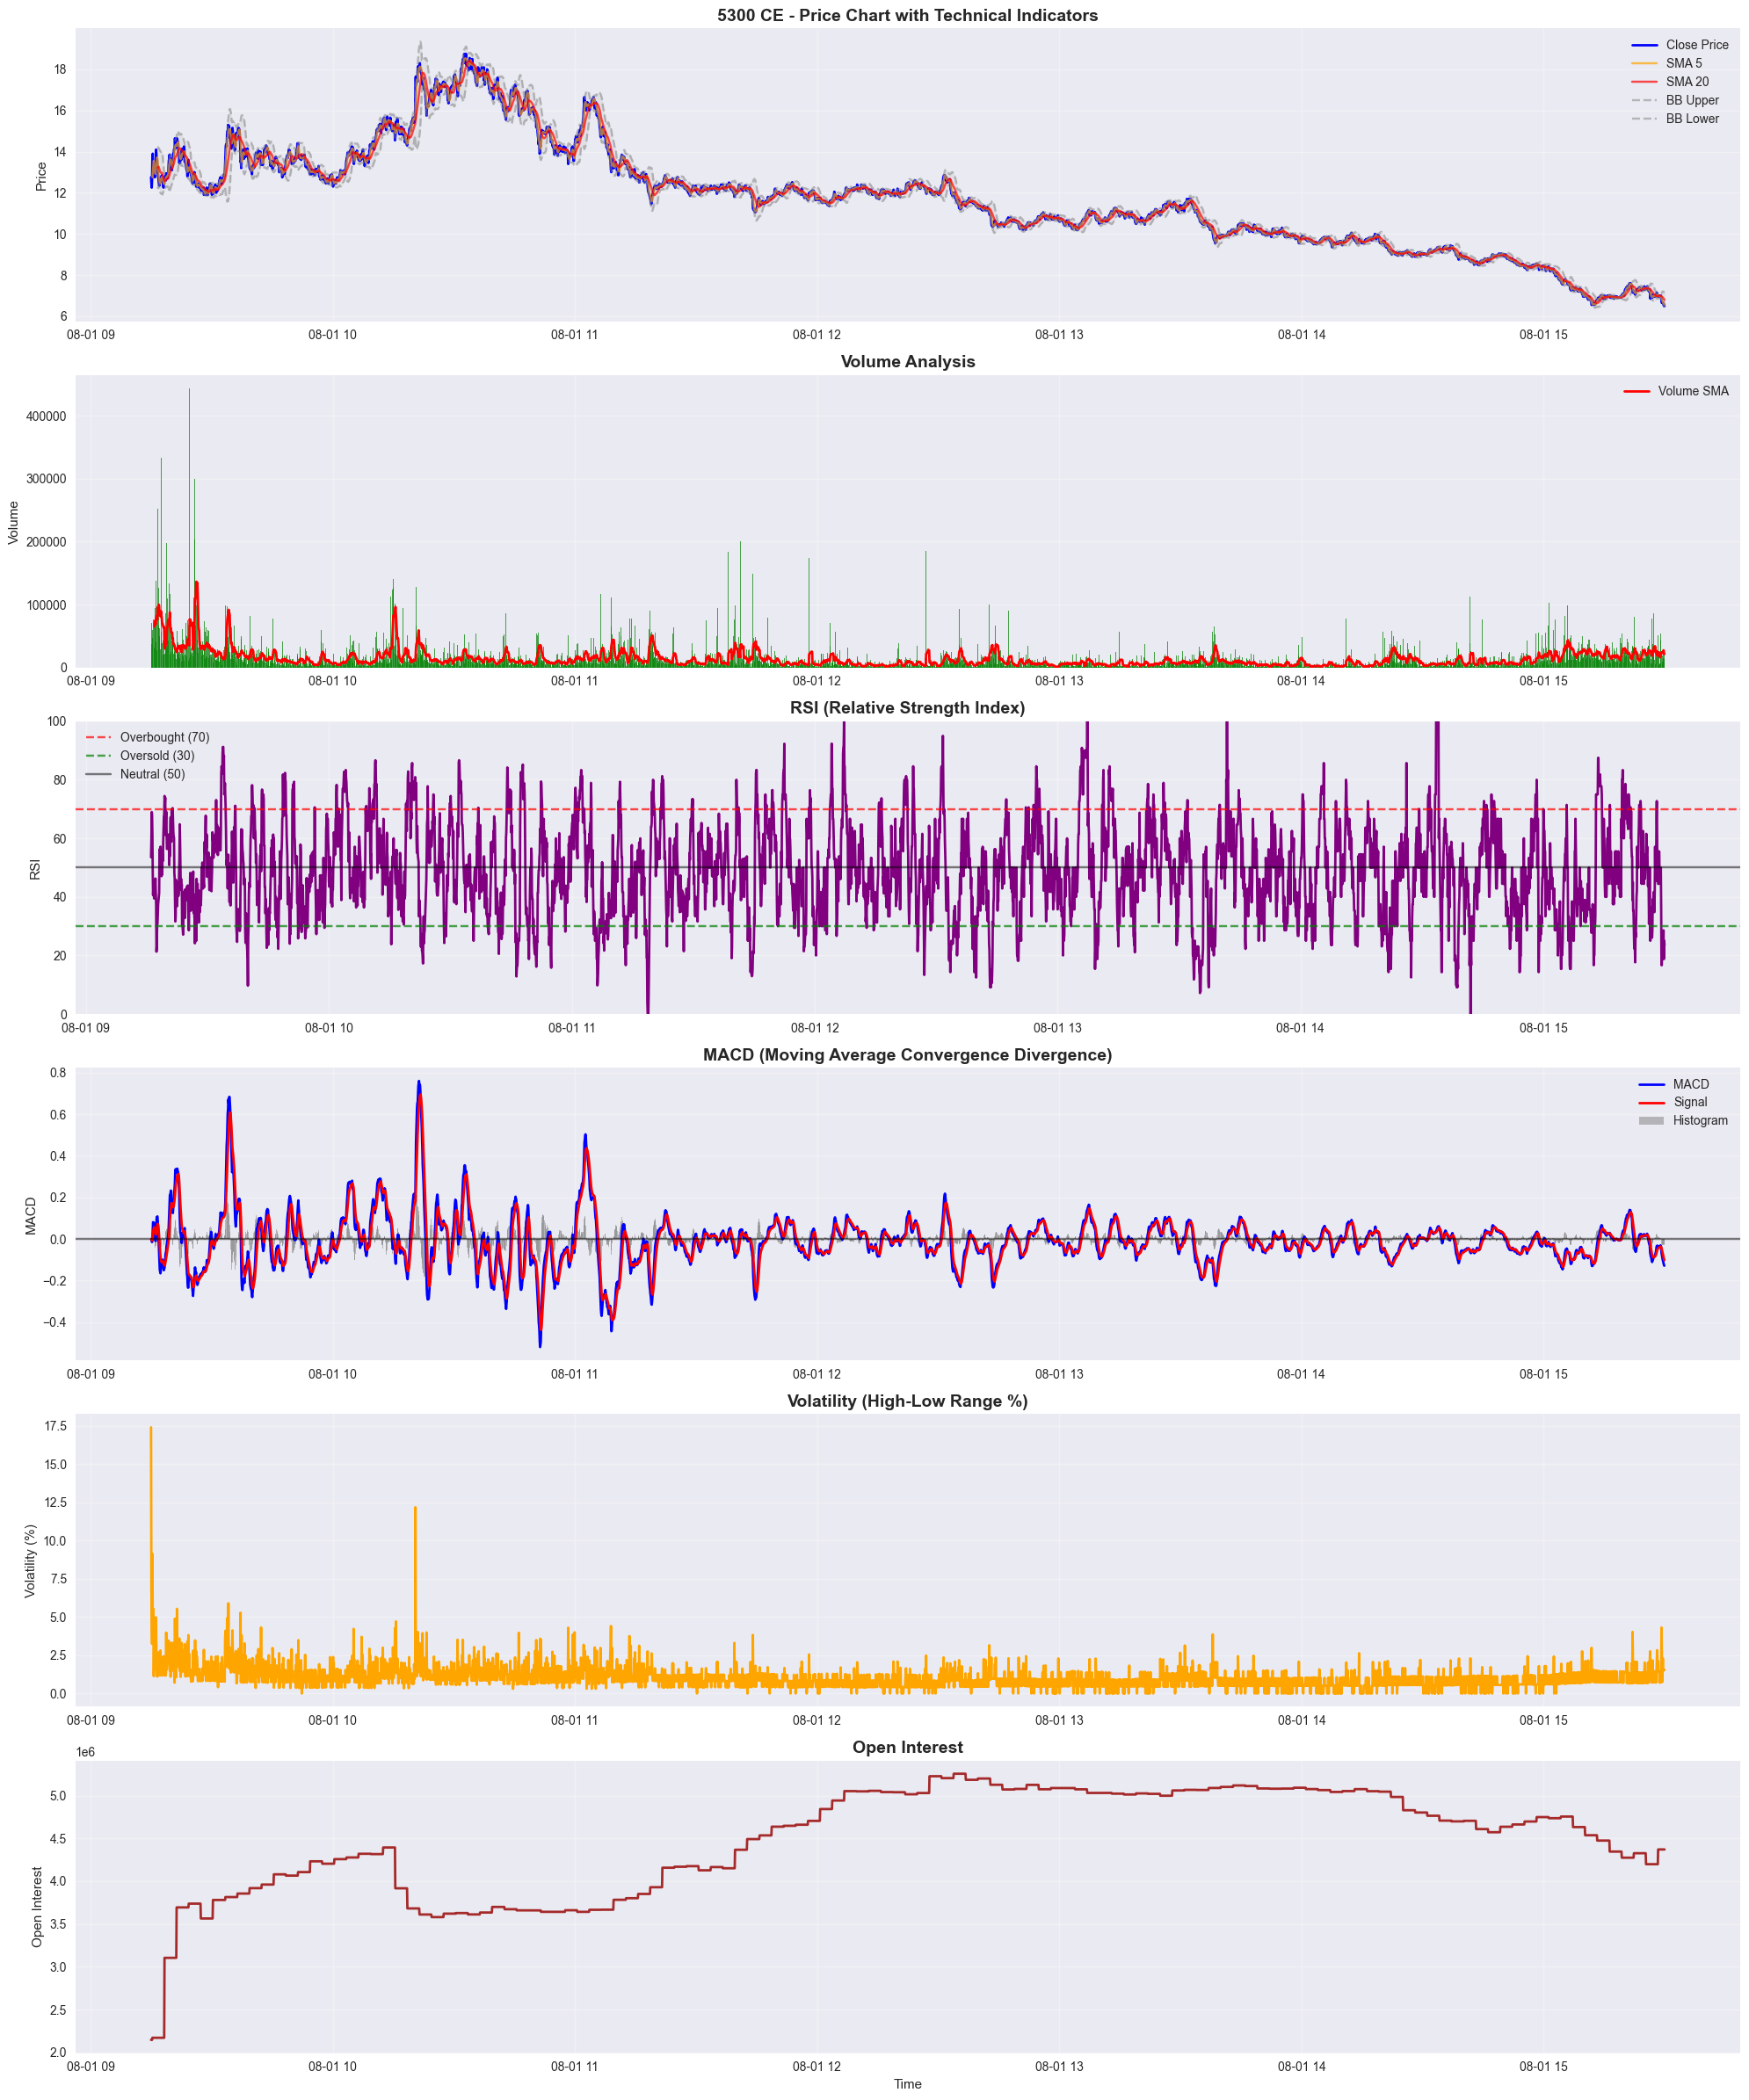

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

class SingleOptionAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.strike = None
        self.option_type = None
        
    def load_and_parse_file(self):
        """
        Load the CSV file and parse filename to extract strike and option type
        """
        print(f"Loading file: {self.file_path}")
        
        # Load the data
        self.data = pd.read_csv(self.file_path)
        
        # Parse filename to extract strike and option type
        filename = self.file_path.split('/')[-1]
        import re
        
        # Extract strike price and option type from filename
        match = re.search(r'nse_nifty\d+(\d{4})(ce|pe)_min\.csv', filename)
        if match:
            self.strike = int(match.group(1))
            self.option_type = match.group(2).upper()
            print(f"Strike: {self.strike}, Option Type: {self.option_type}")
        else:
            print("Could not parse strike and option type from filename")
        
        # Convert timestamp to datetime
        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
        
        # Ensure numeric columns are numeric
        numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'oi']
        for col in numeric_cols:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        # Remove any rows with missing values
        self.data.dropna(inplace=True)
        
        # Remove rows with invalid prices
        self.data = self.data[
            (self.data['open'] > 0) & 
            (self.data['high'] > 0) & 
            (self.data['low'] > 0) & 
            (self.data['close'] > 0)
        ]
        
        # Calculate additional metrics
        self.calculate_metrics()
        
        print(f"Data loaded successfully. Shape: {self.data.shape}")
        return self.data
    
    def calculate_metrics(self):
        """
        Calculate additional technical metrics
        """
        # Basic price metrics
        self.data['price_change'] = self.data['close'] - self.data['open']
        self.data['price_change_pct'] = (self.data['price_change'] / self.data['open']) * 100
        self.data['high_low_range'] = self.data['high'] - self.data['low']
        self.data['volatility'] = self.data['high_low_range'] / self.data['open'] * 100
        
        # Moving averages
        self.data['sma_5'] = self.data['close'].rolling(window=5).mean()
        self.data['sma_10'] = self.data['close'].rolling(window=10).mean()
        self.data['sma_20'] = self.data['close'].rolling(window=20).mean()
        
        # RSI
        self.data['rsi'] = self.calculate_rsi(self.data['close'])
        
        # Bollinger Bands
        self.data['bb_upper'], self.data['bb_lower'], self.data['bb_middle'] = self.calculate_bollinger_bands(self.data['close'])
        
        # MACD
        self.data['macd'], self.data['macd_signal'], self.data['macd_histogram'] = self.calculate_macd(self.data['close'])
        
        # Volume metrics
        self.data['volume_sma'] = self.data['volume'].rolling(window=10).mean()
        self.data['volume_ratio'] = self.data['volume'] / self.data['volume_sma']
        
        # Price momentum
        self.data['momentum'] = self.data['close'] - self.data['close'].shift(5)
        
        # True Range and ATR
        self.data['tr'] = self.calculate_true_range(self.data['high'], self.data['low'], self.data['close'])
        self.data['atr'] = self.data['tr'].rolling(window=14).mean()
    
    def calculate_rsi(self, prices, period=14):
        """Calculate RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, lower_band, sma
    
    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD"""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=signal).mean()
        macd_histogram = macd - macd_signal
        return macd, macd_signal, macd_histogram
    
    def calculate_true_range(self, high, low, close):
        """Calculate True Range"""
        prev_close = close.shift(1)
        tr1 = high - low
        tr2 = abs(high - prev_close)
        tr3 = abs(low - prev_close)
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return tr
    
    def get_summary_stats(self):
        """
        Get summary statistics for the option
        """
        summary = {
            'Strike Price': self.strike,
            'Option Type': self.option_type,
            'Total Records': len(self.data),
            'Date Range': f"{self.data['timestamp'].min()} to {self.data['timestamp'].max()}",
            'Current Price': self.data['close'].iloc[-1],
            'Open Price': self.data['open'].iloc[0],
            'Total Price Change': self.data['close'].iloc[-1] - self.data['open'].iloc[0],
            'Total Price Change %': ((self.data['close'].iloc[-1] - self.data['open'].iloc[0]) / self.data['open'].iloc[0]) * 100,
            'Highest Price': self.data['high'].max(),
            'Lowest Price': self.data['low'].min(),
            'Average Price': self.data['close'].mean(),
            'Total Volume': self.data['volume'].sum(),
            'Average Volume': self.data['volume'].mean(),
            'Max Volume': self.data['volume'].max(),
            'Current OI': self.data['oi'].iloc[-1],
            'Average OI': self.data['oi'].mean(),
            'Max OI': self.data['oi'].max(),
            'Average Volatility': self.data['volatility'].mean(),
            'Max Volatility': self.data['volatility'].max()
        }
        
        return pd.Series(summary)
    
    def plot_comprehensive_analysis(self):
        """
        Create comprehensive visualization of the option data
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 24))
        
        # 1. Price Chart with Moving Averages and Bollinger Bands
        ax1 = plt.subplot(6, 1, 1)
        plt.plot(self.data['timestamp'], self.data['close'], label='Close Price', linewidth=2, color='blue')
        plt.plot(self.data['timestamp'], self.data['sma_5'], label='SMA 5', alpha=0.7, color='orange')
        plt.plot(self.data['timestamp'], self.data['sma_20'], label='SMA 20', alpha=0.7, color='red')
        plt.plot(self.data['timestamp'], self.data['bb_upper'], label='BB Upper', alpha=0.5, color='gray', linestyle='--')
        plt.plot(self.data['timestamp'], self.data['bb_lower'], label='BB Lower', alpha=0.5, color='gray', linestyle='--')
        plt.fill_between(self.data['timestamp'], self.data['bb_upper'], self.data['bb_lower'], alpha=0.1, color='gray')
        plt.title(f'{self.strike} {self.option_type} - Price Chart with Technical Indicators', fontsize=14, fontweight='bold')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Volume Chart
        ax2 = plt.subplot(6, 1, 2)
        plt.bar(self.data['timestamp'], self.data['volume'], alpha=0.7, color='green', width=0.0001)
        plt.plot(self.data['timestamp'], self.data['volume_sma'], color='red', linewidth=2, label='Volume SMA')
        plt.title('Volume Analysis', fontsize=14, fontweight='bold')
        plt.ylabel('Volume')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. RSI
        ax3 = plt.subplot(6, 1, 3)
        plt.plot(self.data['timestamp'], self.data['rsi'], color='purple', linewidth=2)
        plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
        plt.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
        plt.axhline(y=50, color='black', linestyle='-', alpha=0.5, label='Neutral (50)')
        plt.title('RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
        plt.ylabel('RSI')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. MACD
        ax4 = plt.subplot(6, 1, 4)
        plt.plot(self.data['timestamp'], self.data['macd'], label='MACD', color='blue', linewidth=2)
        plt.plot(self.data['timestamp'], self.data['macd_signal'], label='Signal', color='red', linewidth=2)
        plt.bar(self.data['timestamp'], self.data['macd_histogram'], alpha=0.5, color='gray', label='Histogram', width=0.0001)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('MACD (Moving Average Convergence Divergence)', fontsize=14, fontweight='bold')
        plt.ylabel('MACD')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Volatility
        ax5 = plt.subplot(6, 1, 5)
        plt.plot(self.data['timestamp'], self.data['volatility'], color='orange', linewidth=2)
        plt.title('Volatility (High-Low Range %)', fontsize=14, fontweight='bold')
        plt.ylabel('Volatility (%)')
        plt.grid(True, alpha=0.3)
        
        # 6. Open Interest
        ax6 = plt.subplot(6, 1, 6)
        plt.plot(self.data['timestamp'], self.data['oi'], color='brown', linewidth=2)
        plt.title('Open Interest', fontsize=14, fontweight='bold')
        plt.ylabel('Open Interest')
        plt.xlabel('Time')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_candlestick_chart(self, start_time=None, end_time=None):
        """
        Create a candlestick chart for the option
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        # Filter data by time range if specified
        if start_time and end_time:
            mask = (self.data['timestamp'] >= start_time) & (self.data['timestamp'] <= end_time)
            plot_data = self.data[mask]
        else:
            plot_data = self.data
        
        if len(plot_data) == 0:
            print("No data available for the specified time range")
            return
        
        # Create candlestick chart
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Candlestick chart
        for i, (idx, row) in enumerate(plot_data.iterrows()):
            color = 'green' if row['close'] >= row['open'] else 'red'
            
            # Body
            ax1.bar(i, row['close'] - row['open'], bottom=row['open'], 
                   color=color, alpha=0.7, width=0.8)
            
            # Wicks
            ax1.plot([i, i], [row['low'], row['high']], color='black', linewidth=1)
        
        ax1.set_title(f'{self.strike} {self.option_type} - Candlestick Chart', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price')
        ax1.grid(True, alpha=0.3)
        
        # Volume chart
        ax2.bar(range(len(plot_data)), plot_data['volume'], alpha=0.7, color='blue')
        ax2.set_title('Volume', fontsize=12)
        ax2.set_ylabel('Volume')
        ax2.set_xlabel('Time Periods')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_price_distribution(self):
        """
        Plot price distribution and statistics
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Price distribution histogram
        axes[0, 0].hist(self.data['close'], bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 0].axvline(self.data['close'].mean(), color='red', linestyle='--', label=f'Mean: {self.data["close"].mean():.2f}')
        axes[0, 0].axvline(self.data['close'].median(), color='green', linestyle='--', label=f'Median: {self.data["close"].median():.2f}')
        axes[0, 0].set_title('Price Distribution')
        axes[0, 0].set_xlabel('Price')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Volume distribution
        axes[0, 1].hist(self.data['volume'], bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0, 1].axvline(self.data['volume'].mean(), color='red', linestyle='--', label=f'Mean: {self.data["volume"].mean():.0f}')
        axes[0, 1].set_title('Volume Distribution')
        axes[0, 1].set_xlabel('Volume')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Price vs Volume scatter
        axes[1, 0].scatter(self.data['close'], self.data['volume'], alpha=0.6, color='purple')
        axes[1, 0].set_title('Price vs Volume')
        axes[1, 0].set_xlabel('Price')
        axes[1, 0].set_ylabel('Volume')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Price change distribution
        axes[1, 1].hist(self.data['price_change_pct'], bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[1, 1].axvline(0, color='red', linestyle='--', label='No Change')
        axes[1, 1].set_title('Price Change % Distribution')
        axes[1, 1].set_xlabel('Price Change %')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'{self.strike} {self.option_type} - Statistical Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_intraday_patterns(self):
        """
        Analyze and plot intraday patterns
        """
        if self.data is None:
            print("Please load data first using load_and_parse_file()")
            return
        
        # Extract time components
        self.data['hour'] = self.data['timestamp'].dt.hour
        self.data['minute'] = self.data['timestamp'].dt.minute
        self.data['time_of_day'] = self.data['timestamp'].dt.time
        
        # Group by time of day
        hourly_stats = self.data.groupby('hour').agg({
            'close': ['mean', 'std'],
            'volume': 'mean',
            'volatility': 'mean'
        }).round(2)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Average price by hour
        axes[0, 0].plot(hourly_stats.index, hourly_stats[('close', 'mean')], 'o-', color='blue', linewidth=2)
        axes[0, 0].fill_between(hourly_stats.index, 
                               hourly_stats[('close', 'mean')] - hourly_stats[('close', 'std')],
                               hourly_stats[('close', 'mean')] + hourly_stats[('close', 'std')],
                               alpha=0.3, color='blue')
        axes[0, 0].set_title('Average Price by Hour')
        axes[0, 0].set_xlabel('Hour')
        axes[0, 0].set_ylabel('Average Price')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Average volume by hour
        axes[0, 1].bar(hourly_stats.index, hourly_stats[('volume', 'mean')], alpha=0.7, color='green')
        axes[0, 1].set_title('Average Volume by Hour')
        axes[0, 1].set_xlabel('Hour')
        axes[0, 1].set_ylabel('Average Volume')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Average volatility by hour
        axes[1, 0].plot(hourly_stats.index, hourly_stats[('volatility', 'mean')], 'o-', color='red', linewidth=2)
        axes[1, 0].set_title('Average Volatility by Hour')
        axes[1, 0].set_xlabel('Hour')
        axes[1, 0].set_ylabel('Average Volatility (%)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Price range by hour
        hourly_range = self.data.groupby('hour').agg({
            'high': 'max',
            'low': 'min'
        })
        hourly_range['range'] = hourly_range['high'] - hourly_range['low']
        
        axes[1, 1].bar(hourly_range.index, hourly_range['range'], alpha=0.7, color='orange')
        axes[1, 1].set_title('Price Range by Hour')
        axes[1, 1].set_xlabel('Hour')
        axes[1, 1].set_ylabel('Price Range')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'{self.strike} {self.option_type} - Intraday Patterns', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return hourly_stats

# Usage example
if __name__ == "__main__":
    # Example usage - replace with your actual file path
    file_path = "Aug '25/Aug 07 Exp/01 Aug/5S/nse_nifty2580725300ce_min.csv"
    
    # Initialize analyzer
    analyzer = SingleOptionAnalyzer(file_path)
    
    # Load and parse the file
    data = analyzer.load_and_parse_file()
    
    # Get summary statistics
    summary = analyzer.get_summary_stats()
    print("\nSummary Statistics:")
    print(summary)
    
    # Create comprehensive analysis plots
    analyzer.plot_comprehensive_analysis()
    
    # Create candlestick chart
    analyzer.plot_candlestick_chart()
    
    # Create statistical analysis plots
    analyzer.plot_price_distribution()
    
    # Create intraday patterns analysis
    hourly_stats = analyzer.plot_intraday_patterns()
    print("\nHourly Statistics:")
    print(hourly_stats)

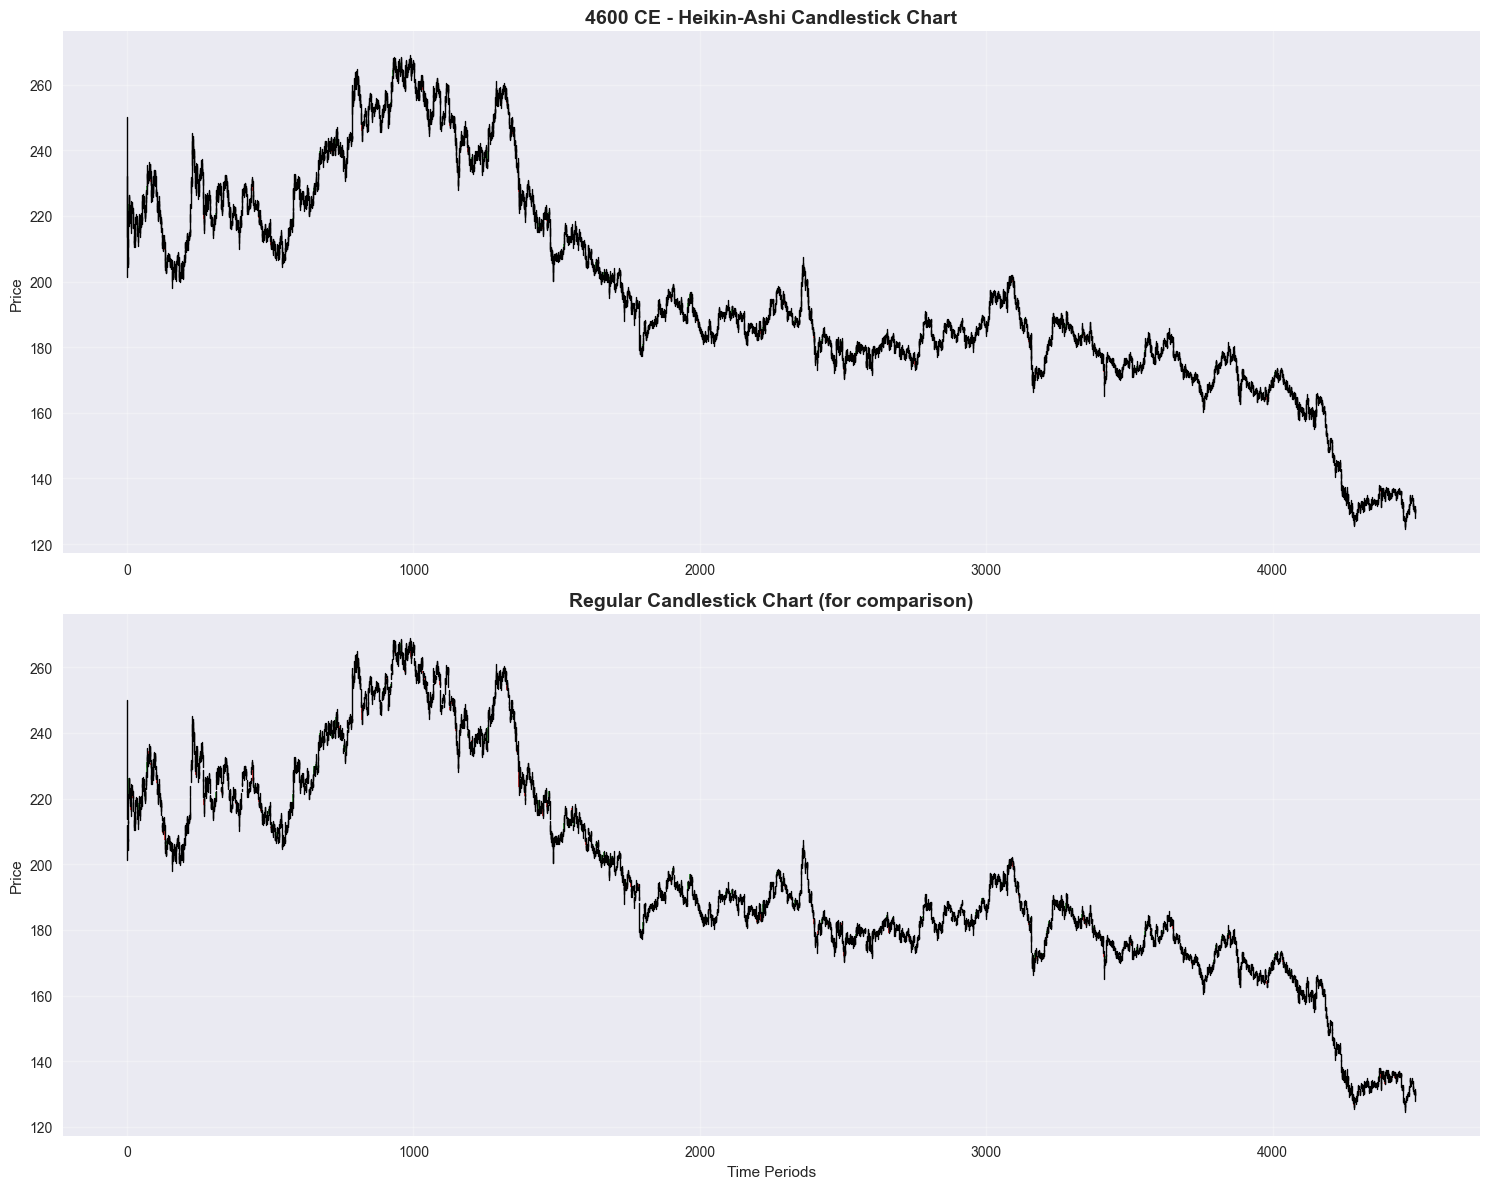

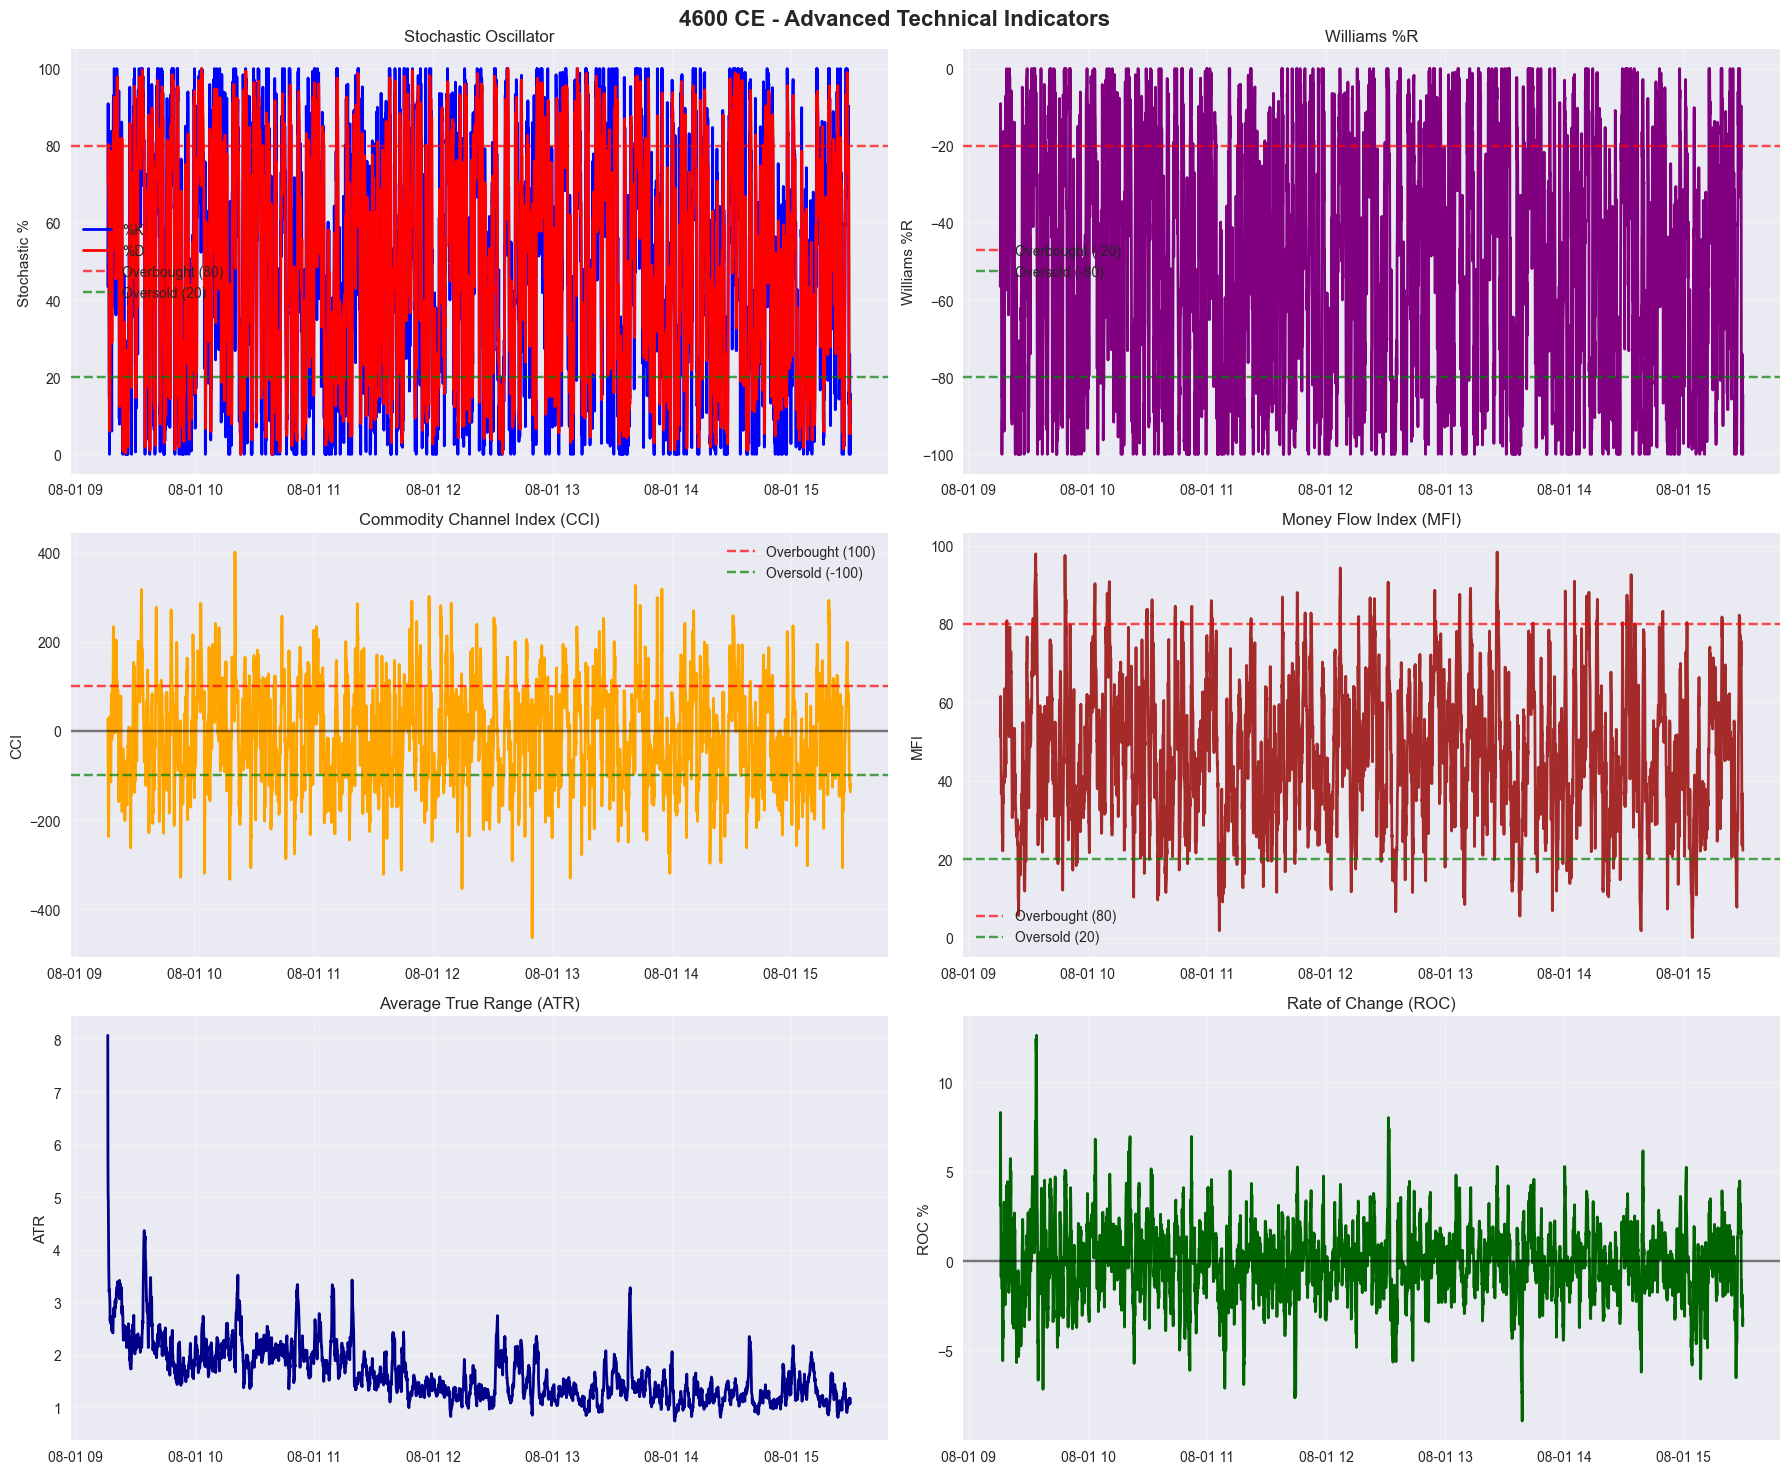

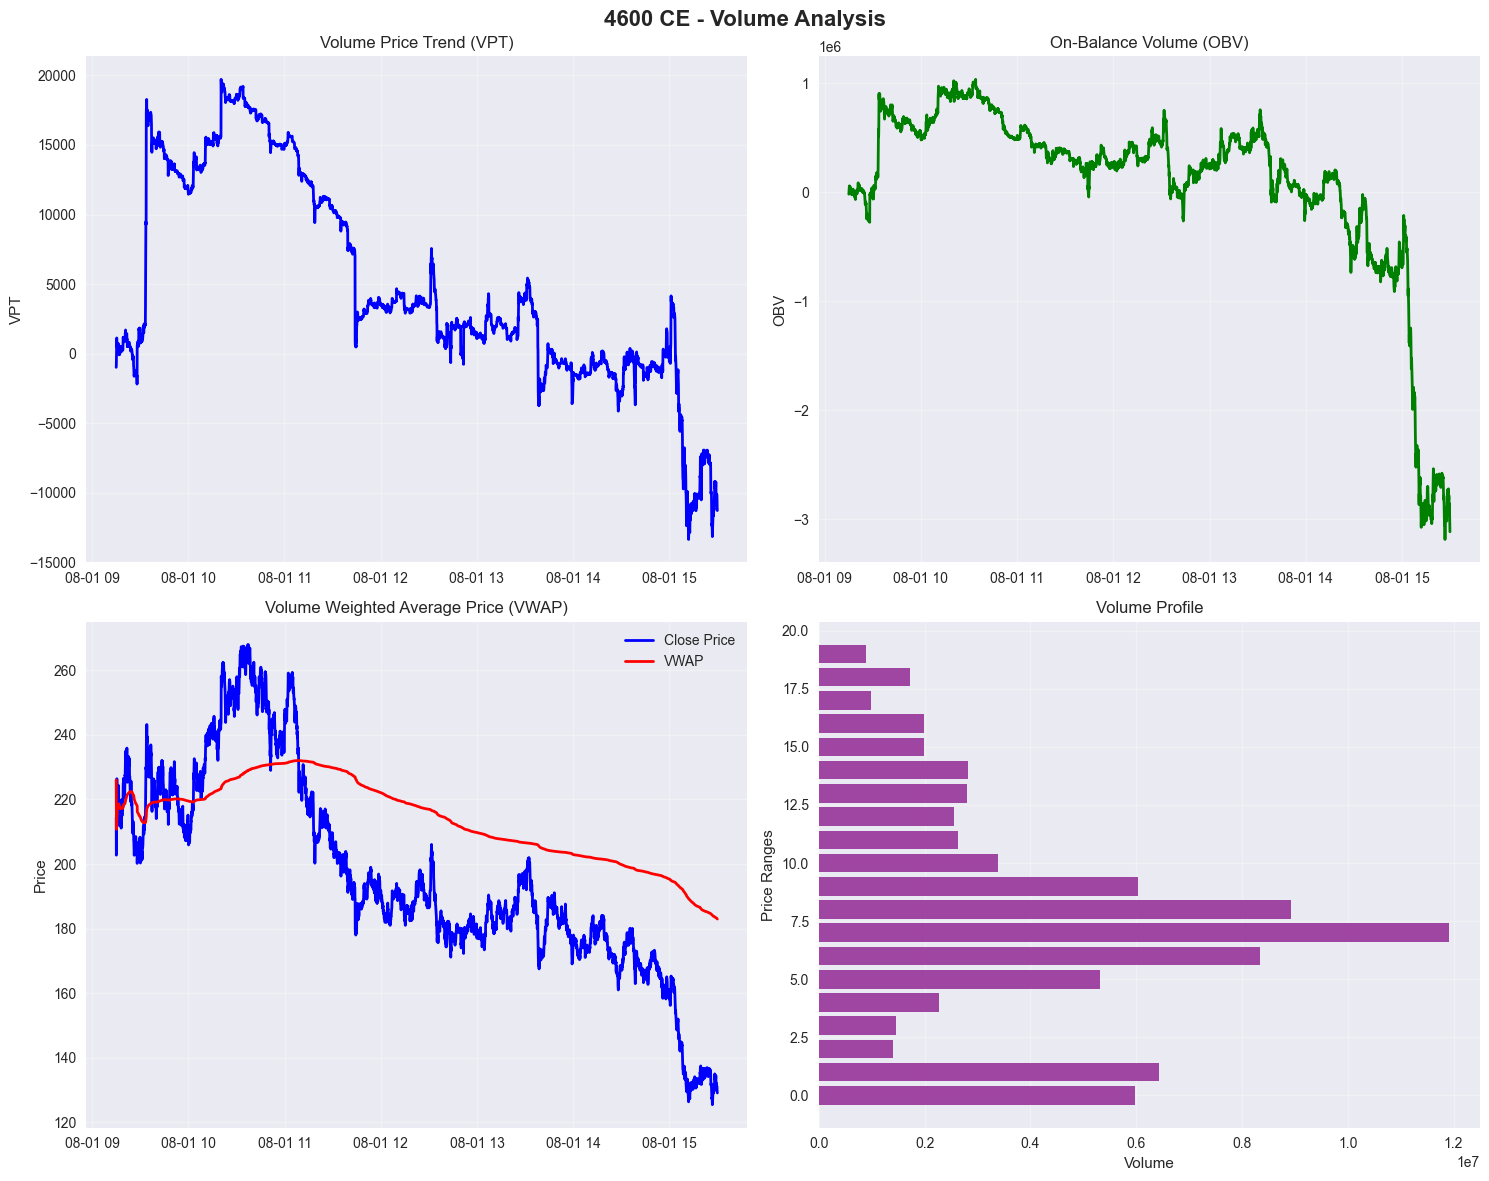

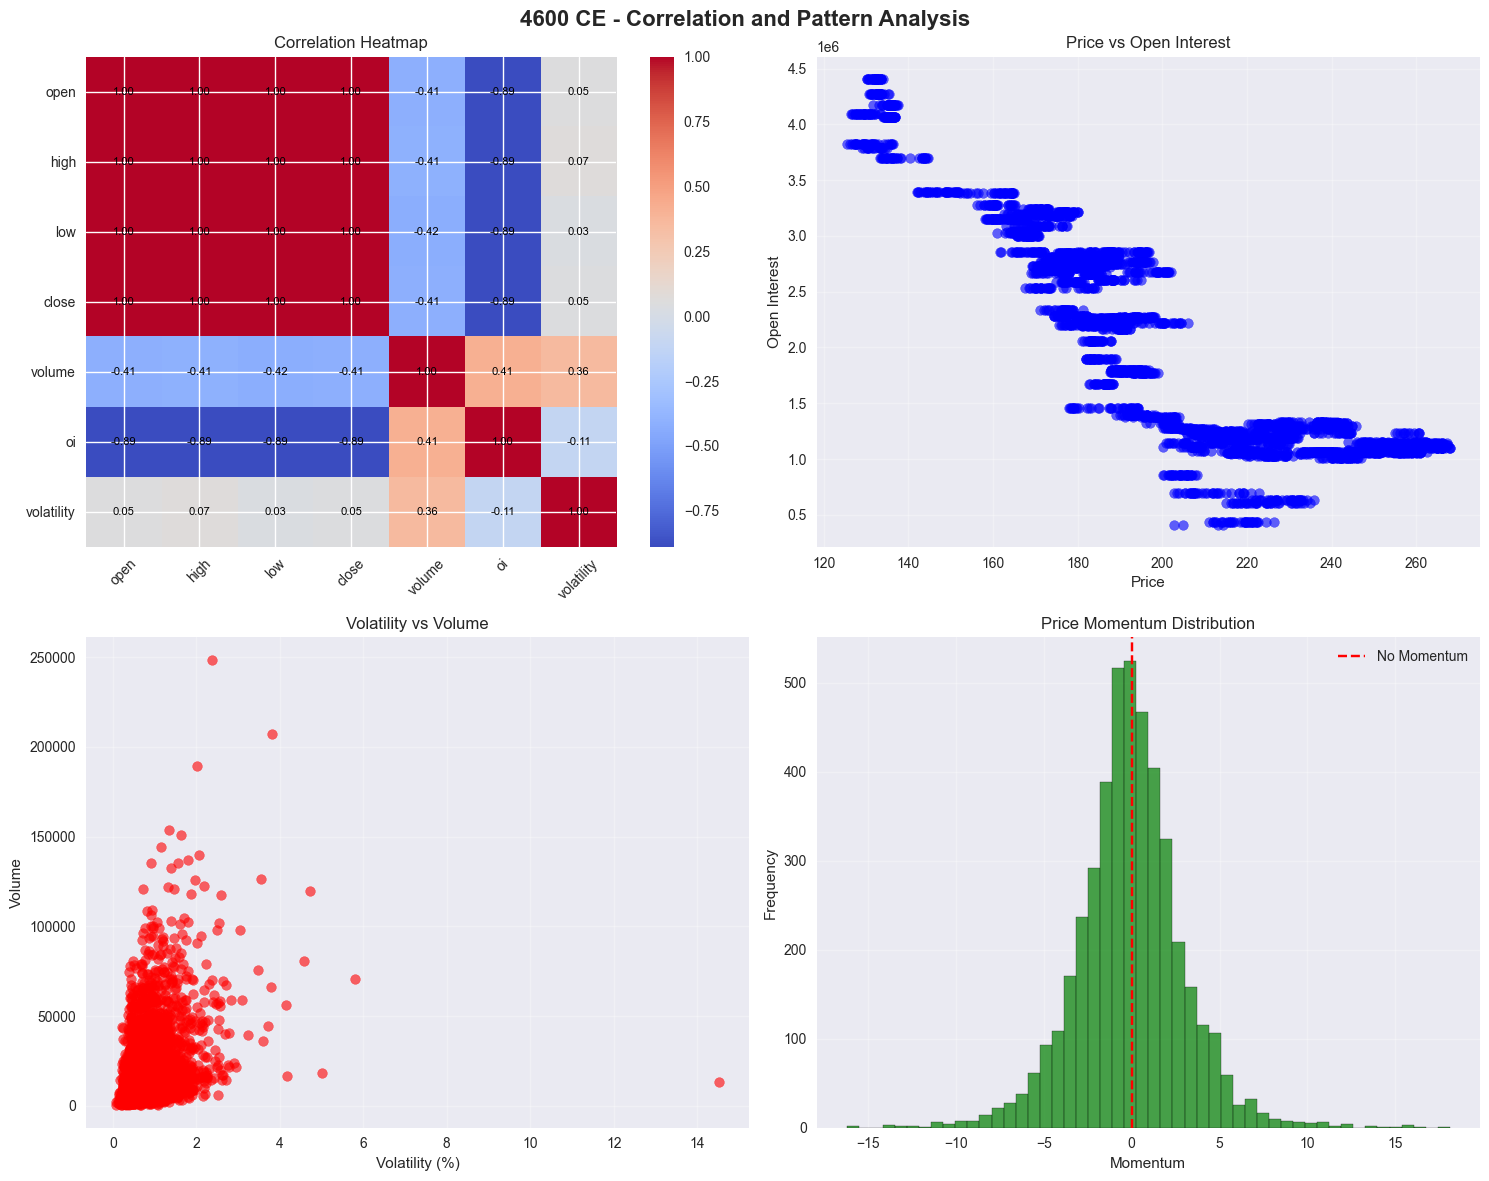


=== TRADING SIGNALS FOR 4600 CE ===
Total signals generated: 1863

Recent Trading Signals:
Time: 2025-08-01 15:28:20, Price: 135.00, Signals: RSI Overbought, BB Overbought, High Volume
Time: 2025-08-01 15:28:25, Price: 133.55, Signals: RSI Overbought
Time: 2025-08-01 15:28:30, Price: 133.30, Signals: RSI Overbought
Time: 2025-08-01 15:28:35, Price: 134.00, Signals: RSI Overbought
Time: 2025-08-01 15:29:00, Price: 134.45, Signals: RSI Overbought
Time: 2025-08-01 15:29:10, Price: 131.65, Signals: MACD Bearish Crossover, High Volume
Time: 2025-08-01 15:29:30, Price: 130.25, Signals: RSI Oversold
Time: 2025-08-01 15:29:35, Price: 131.30, Signals: High Volume
Time: 2025-08-01 15:29:50, Price: 129.60, Signals: High Volume
Time: 2025-08-01 15:29:55, Price: 129.10, Signals: RSI Oversold

=== ADDITIONAL INDICATORS SUMMARY FOR 4600 CE ===
Current VWAP: 182.96
Current OBV: -3,115,125
Current VPT: -11,292
Current CCI: -136.99
Current MFI: 22.26
Current Williams %R: -84.29


In [5]:
# Additional Charts and Analysis for Single Option
# This code assumes you have already run the previous code and have 'analyzer' object available

def create_additional_charts(analyzer):
    """
    Create additional specialized charts and analysis
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    
    # 1. HEIKIN-ASHI CANDLESTICK CHART
    def calculate_heikin_ashi(df):
        ha_df = df.copy()
        
        # Calculate Heikin-Ashi values
        ha_df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        
        # Calculate HA_Open
        ha_df['HA_Open'] = ha_df['HA_Close'].shift(1)
        ha_df.loc[ha_df.index[0], 'HA_Open'] = (df.loc[df.index[0], 'open'] + df.loc[df.index[0], 'close']) / 2
        
        # Calculate HA_High and HA_Low
        ha_df['HA_High'] = ha_df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
        ha_df['HA_Low'] = ha_df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
        
        return ha_df
    
    ha_data = calculate_heikin_ashi(analyzer.data)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Heikin-Ashi candlestick
    for i, (idx, row) in enumerate(ha_data.iterrows()):
        color = 'green' if row['HA_Close'] >= row['HA_Open'] else 'red'
        
        # Body
        ax1.bar(i, row['HA_Close'] - row['HA_Open'], bottom=row['HA_Open'], 
               color=color, alpha=0.7, width=0.8)
        
        # Wicks
        ax1.plot([i, i], [row['HA_Low'], row['HA_High']], color='black', linewidth=1)
    
    ax1.set_title(f'{analyzer.strike} {analyzer.option_type} - Heikin-Ashi Candlestick Chart', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)
    
    # Regular candlestick for comparison
    for i, (idx, row) in enumerate(analyzer.data.iterrows()):
        color = 'green' if row['close'] >= row['open'] else 'red'
        
        # Body
        ax2.bar(i, row['close'] - row['open'], bottom=row['open'], 
               color=color, alpha=0.7, width=0.8)
        
        # Wicks
        ax2.plot([i, i], [row['low'], row['high']], color='black', linewidth=1)
    
    ax2.set_title('Regular Candlestick Chart (for comparison)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Price')
    ax2.set_xlabel('Time Periods')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. MOMENTUM AND OSCILLATOR INDICATORS
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    # Stochastic Oscillator
    def calculate_stochastic(df, k_period=14, d_period=3):
        low_min = df['low'].rolling(window=k_period).min()
        high_max = df['high'].rolling(window=k_period).max()
        k_percent = 100 * ((df['close'] - low_min) / (high_max - low_min))
        d_percent = k_percent.rolling(window=d_period).mean()
        return k_percent, d_percent
    
    k_percent, d_percent = calculate_stochastic(analyzer.data)
    
    axes[0, 0].plot(analyzer.data['timestamp'], k_percent, label='%K', color='blue', linewidth=2)
    axes[0, 0].plot(analyzer.data['timestamp'], d_percent, label='%D', color='red', linewidth=2)
    axes[0, 0].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='Overbought (80)')
    axes[0, 0].axhline(y=20, color='g', linestyle='--', alpha=0.7, label='Oversold (20)')
    axes[0, 0].set_title('Stochastic Oscillator')
    axes[0, 0].set_ylabel('Stochastic %')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Williams %R
    def calculate_williams_r(df, period=14):
        high_max = df['high'].rolling(window=period).max()
        low_min = df['low'].rolling(window=period).min()
        williams_r = -100 * ((high_max - df['close']) / (high_max - low_min))
        return williams_r
    
    williams_r = calculate_williams_r(analyzer.data)
    
    axes[0, 1].plot(analyzer.data['timestamp'], williams_r, color='purple', linewidth=2)
    axes[0, 1].axhline(y=-20, color='r', linestyle='--', alpha=0.7, label='Overbought (-20)')
    axes[0, 1].axhline(y=-80, color='g', linestyle='--', alpha=0.7, label='Oversold (-80)')
    axes[0, 1].set_title('Williams %R')
    axes[0, 1].set_ylabel('Williams %R')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Commodity Channel Index (CCI)
    def calculate_cci(df, period=20):
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        sma_tp = typical_price.rolling(window=period).mean()
        mad = typical_price.rolling(window=period).apply(lambda x: np.mean(np.abs(x - x.mean())))
        cci = (typical_price - sma_tp) / (0.015 * mad)
        return cci
    
    cci = calculate_cci(analyzer.data)
    
    axes[1, 0].plot(analyzer.data['timestamp'], cci, color='orange', linewidth=2)
    axes[1, 0].axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Overbought (100)')
    axes[1, 0].axhline(y=-100, color='g', linestyle='--', alpha=0.7, label='Oversold (-100)')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].set_title('Commodity Channel Index (CCI)')
    axes[1, 0].set_ylabel('CCI')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Money Flow Index (MFI)
    def calculate_mfi(df, period=14):
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        money_flow = typical_price * df['volume']
        
        positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
        negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
        
        positive_mf = positive_flow.rolling(window=period).sum()
        negative_mf = negative_flow.rolling(window=period).sum()
        
        mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
        return mfi
    
    mfi = calculate_mfi(analyzer.data)
    
    axes[1, 1].plot(analyzer.data['timestamp'], mfi, color='brown', linewidth=2)
    axes[1, 1].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='Overbought (80)')
    axes[1, 1].axhline(y=20, color='g', linestyle='--', alpha=0.7, label='Oversold (20)')
    axes[1, 1].set_title('Money Flow Index (MFI)')
    axes[1, 1].set_ylabel('MFI')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Average True Range (ATR)
    axes[2, 0].plot(analyzer.data['timestamp'], analyzer.data['atr'], color='darkblue', linewidth=2)
    axes[2, 0].set_title('Average True Range (ATR)')
    axes[2, 0].set_ylabel('ATR')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Price Rate of Change (ROC)
    def calculate_roc(df, period=10):
        roc = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
        return roc
    
    roc = calculate_roc(analyzer.data)
    
    axes[2, 1].plot(analyzer.data['timestamp'], roc, color='darkgreen', linewidth=2)
    axes[2, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[2, 1].set_title('Rate of Change (ROC)')
    axes[2, 1].set_ylabel('ROC %')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced Technical Indicators', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 3. VOLUME ANALYSIS CHARTS
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Volume Price Trend (VPT)
    def calculate_vpt(df):
        vpt = (df['volume'] * ((df['close'] - df['close'].shift(1)) / df['close'].shift(1))).cumsum()
        return vpt
    
    vpt = calculate_vpt(analyzer.data)
    
    axes[0, 0].plot(analyzer.data['timestamp'], vpt, color='blue', linewidth=2)
    axes[0, 0].set_title('Volume Price Trend (VPT)')
    axes[0, 0].set_ylabel('VPT')
    axes[0, 0].grid(True, alpha=0.3)
    
    # On-Balance Volume (OBV)
    def calculate_obv(df):
        obv = (np.sign(df['close'].diff()) * df['volume']).cumsum()
        return obv
    
    obv = calculate_obv(analyzer.data)
    
    axes[0, 1].plot(analyzer.data['timestamp'], obv, color='green', linewidth=2)
    axes[0, 1].set_title('On-Balance Volume (OBV)')
    axes[0, 1].set_ylabel('OBV')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Volume Weighted Average Price (VWAP)
    def calculate_vwap(df):
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
        return vwap
    
    vwap = calculate_vwap(analyzer.data)
    
    axes[1, 0].plot(analyzer.data['timestamp'], analyzer.data['close'], label='Close Price', color='blue', linewidth=2)
    axes[1, 0].plot(analyzer.data['timestamp'], vwap, label='VWAP', color='red', linewidth=2)
    axes[1, 0].set_title('Volume Weighted Average Price (VWAP)')
    axes[1, 0].set_ylabel('Price')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Volume Profile
    volume_profile = analyzer.data.groupby(pd.cut(analyzer.data['close'], bins=20))['volume'].sum()
    
    axes[1, 1].barh(range(len(volume_profile)), volume_profile.values, alpha=0.7, color='purple')
    axes[1, 1].set_title('Volume Profile')
    axes[1, 1].set_xlabel('Volume')
    axes[1, 1].set_ylabel('Price Ranges')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Volume Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. CORRELATION AND PATTERN ANALYSIS
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Correlation heatmap
    correlation_data = analyzer.data[['open', 'high', 'low', 'close', 'volume', 'oi', 'volatility']].corr()
    
    im = axes[0, 0].imshow(correlation_data, cmap='coolwarm', aspect='auto')
    axes[0, 0].set_xticks(range(len(correlation_data.columns)))
    axes[0, 0].set_yticks(range(len(correlation_data.columns)))
    axes[0, 0].set_xticklabels(correlation_data.columns, rotation=45)
    axes[0, 0].set_yticklabels(correlation_data.columns)
    axes[0, 0].set_title('Correlation Heatmap')
    
    # Add correlation values to the heatmap
    for i in range(len(correlation_data.columns)):
        for j in range(len(correlation_data.columns)):
            text = axes[0, 0].text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=axes[0, 0])
    
    # Price vs OI scatter
    axes[0, 1].scatter(analyzer.data['close'], analyzer.data['oi'], alpha=0.6, color='blue')
    axes[0, 1].set_title('Price vs Open Interest')
    axes[0, 1].set_xlabel('Price')
    axes[0, 1].set_ylabel('Open Interest')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Volatility vs Volume scatter
    axes[1, 0].scatter(analyzer.data['volatility'], analyzer.data['volume'], alpha=0.6, color='red')
    axes[1, 0].set_title('Volatility vs Volume')
    axes[1, 0].set_xlabel('Volatility (%)')
    axes[1, 0].set_ylabel('Volume')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Price momentum distribution
    axes[1, 1].hist(analyzer.data['momentum'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', label='No Momentum')
    axes[1, 1].set_title('Price Momentum Distribution')
    axes[1, 1].set_xlabel('Momentum')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Correlation and Pattern Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5. TRADING SIGNALS AND ALERTS
    def generate_trading_signals(df):
        signals = []
        
        # RSI signals
        rsi_oversold = df['rsi'] < 30
        rsi_overbought = df['rsi'] > 70
        
        # MACD signals
        macd_bullish = (df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))
        macd_bearish = (df['macd'] < df['macd_signal']) & (df['macd'].shift(1) >= df['macd_signal'].shift(1))
        
        # Bollinger Bands signals
        bb_oversold = df['close'] < df['bb_lower']
        bb_overbought = df['close'] > df['bb_upper']
        
        # Volume signals
        high_volume = df['volume'] > df['volume_sma'] * 1.5
        
        # Combine signals
        for i in range(len(df)):
            signal = {
                'timestamp': df.iloc[i]['timestamp'],
                'price': df.iloc[i]['close'],
                'signals': []
            }
            
            if rsi_oversold.iloc[i]:
                signal['signals'].append('RSI Oversold')
            if rsi_overbought.iloc[i]:
                signal['signals'].append('RSI Overbought')
            if macd_bullish.iloc[i]:
                signal['signals'].append('MACD Bullish Crossover')
            if macd_bearish.iloc[i]:
                signal['signals'].append('MACD Bearish Crossover')
            if bb_oversold.iloc[i]:
                signal['signals'].append('BB Oversold')
            if bb_overbought.iloc[i]:
                signal['signals'].append('BB Overbought')
            if high_volume.iloc[i]:
                signal['signals'].append('High Volume')
            
            if signal['signals']:
                signals.append(signal)
        
        return signals
    
    trading_signals = generate_trading_signals(analyzer.data)
    
    print(f"\n=== TRADING SIGNALS FOR {analyzer.strike} {analyzer.option_type} ===")
    print(f"Total signals generated: {len(trading_signals)}")
    
    if trading_signals:
        print("\nRecent Trading Signals:")
        for signal in trading_signals[-10:]:  # Show last 10 signals
            print(f"Time: {signal['timestamp']}, Price: {signal['price']:.2f}, Signals: {', '.join(signal['signals'])}")
    else:
        print("No trading signals generated in the current data.")
    
    return {
        'heikin_ashi_data': ha_data,
        'stochastic': (k_percent, d_percent),
        'williams_r': williams_r,
        'cci': cci,
        'mfi': mfi,
        'vpt': vpt,
        'obv': obv,
        'vwap': vwap,
        'trading_signals': trading_signals
    }

# Run the additional charts
additional_analysis = create_additional_charts(analyzer)

# Print summary of additional indicators
print(f"\n=== ADDITIONAL INDICATORS SUMMARY FOR {analyzer.strike} {analyzer.option_type} ===")
print(f"Current VWAP: {additional_analysis['vwap'].iloc[-1]:.2f}")
print(f"Current OBV: {additional_analysis['obv'].iloc[-1]:,.0f}")
print(f"Current VPT: {additional_analysis['vpt'].iloc[-1]:,.0f}")
print(f"Current CCI: {additional_analysis['cci'].iloc[-1]:.2f}")
print(f"Current MFI: {additional_analysis['mfi'].iloc[-1]:.2f}")
print(f"Current Williams %R: {additional_analysis['williams_r'].iloc[-1]:.2f}")

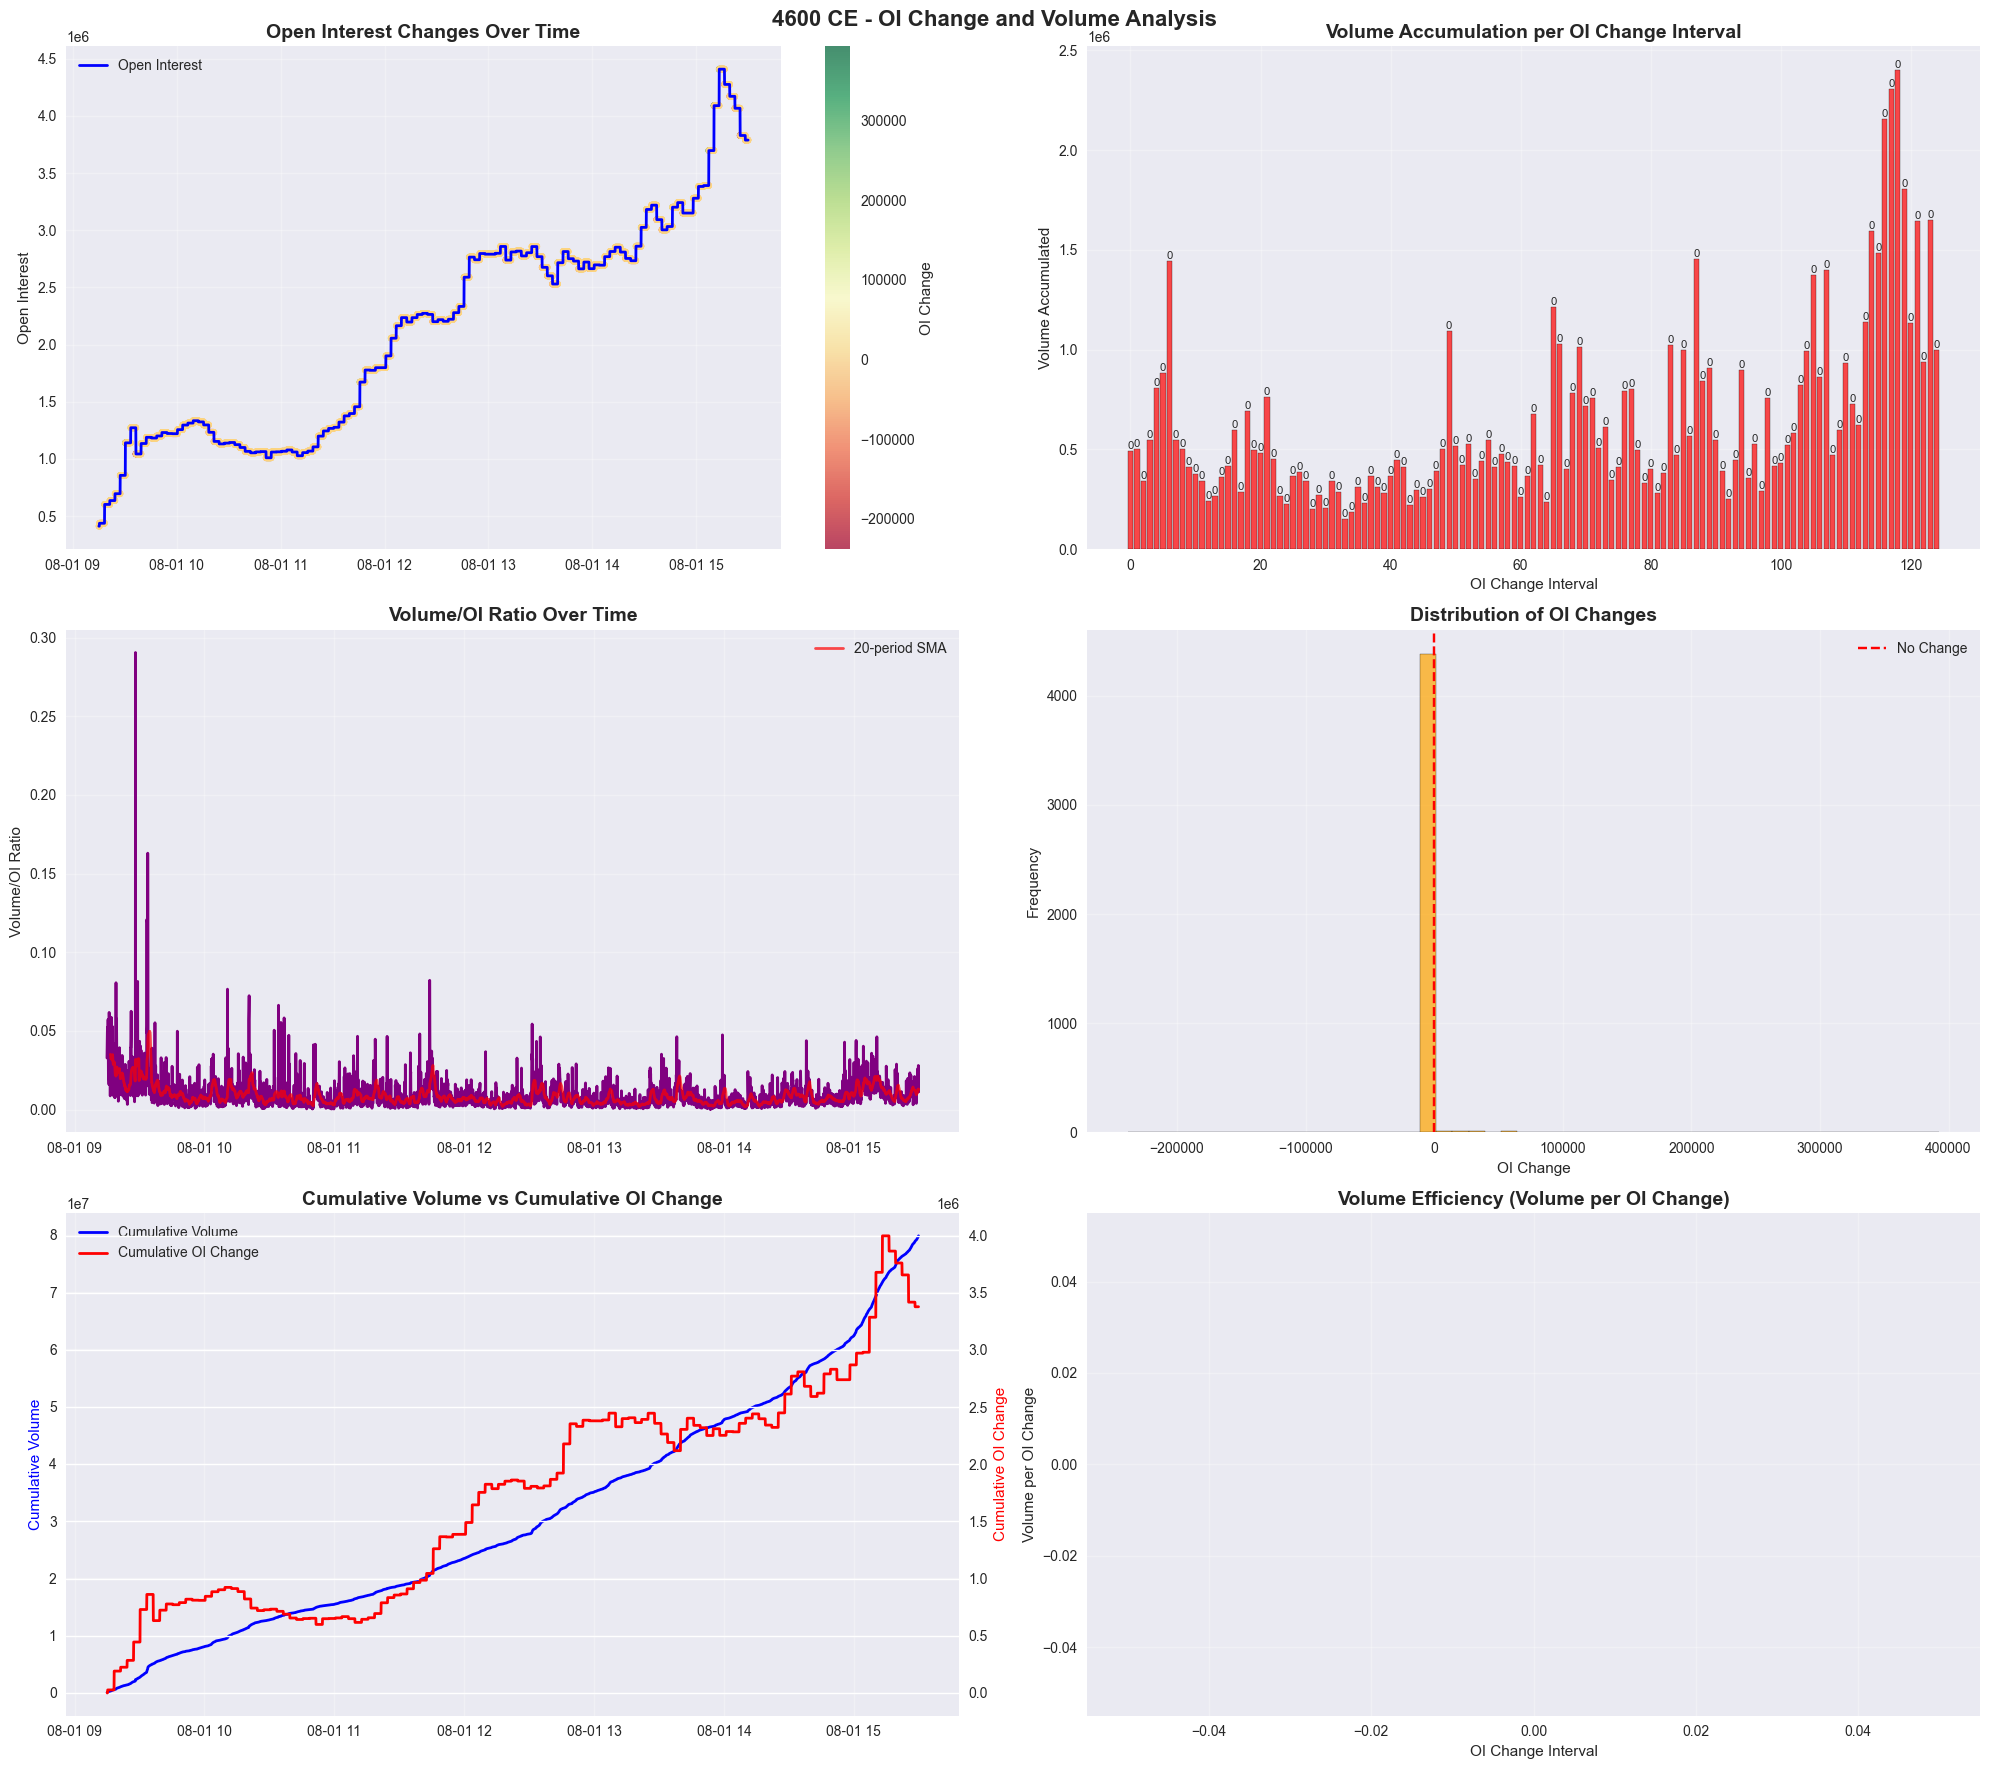


=== DETAILED OI CHANGE ANALYSIS FOR 4600 CE ===

Total OI Change Intervals: 125
Total OI Change: 0
Average OI Change per Interval: 0
Largest OI Increase: 0
Largest OI Decrease: 0

Volume Analysis:
Total Volume Accumulated: 79,747,650
Average Volume per Interval: 637,981
Average Volume/OI Ratio: 0.0089

Top 10 OI Change Intervals:
 interval  oi_change  volume_accumulated  duration  oi_change_pct
        1          0              494025        36            0.0
        2          0              503250        36            0.0
        3          0              340200        36            0.0
        4          0              544350        36            0.0
        5          0              804975        36            0.0
        6          0              880200        37            0.0
        7          0             1445775        36            0.0
        8          0              546750        36            0.0
        9          0              499125        36            0.0
       

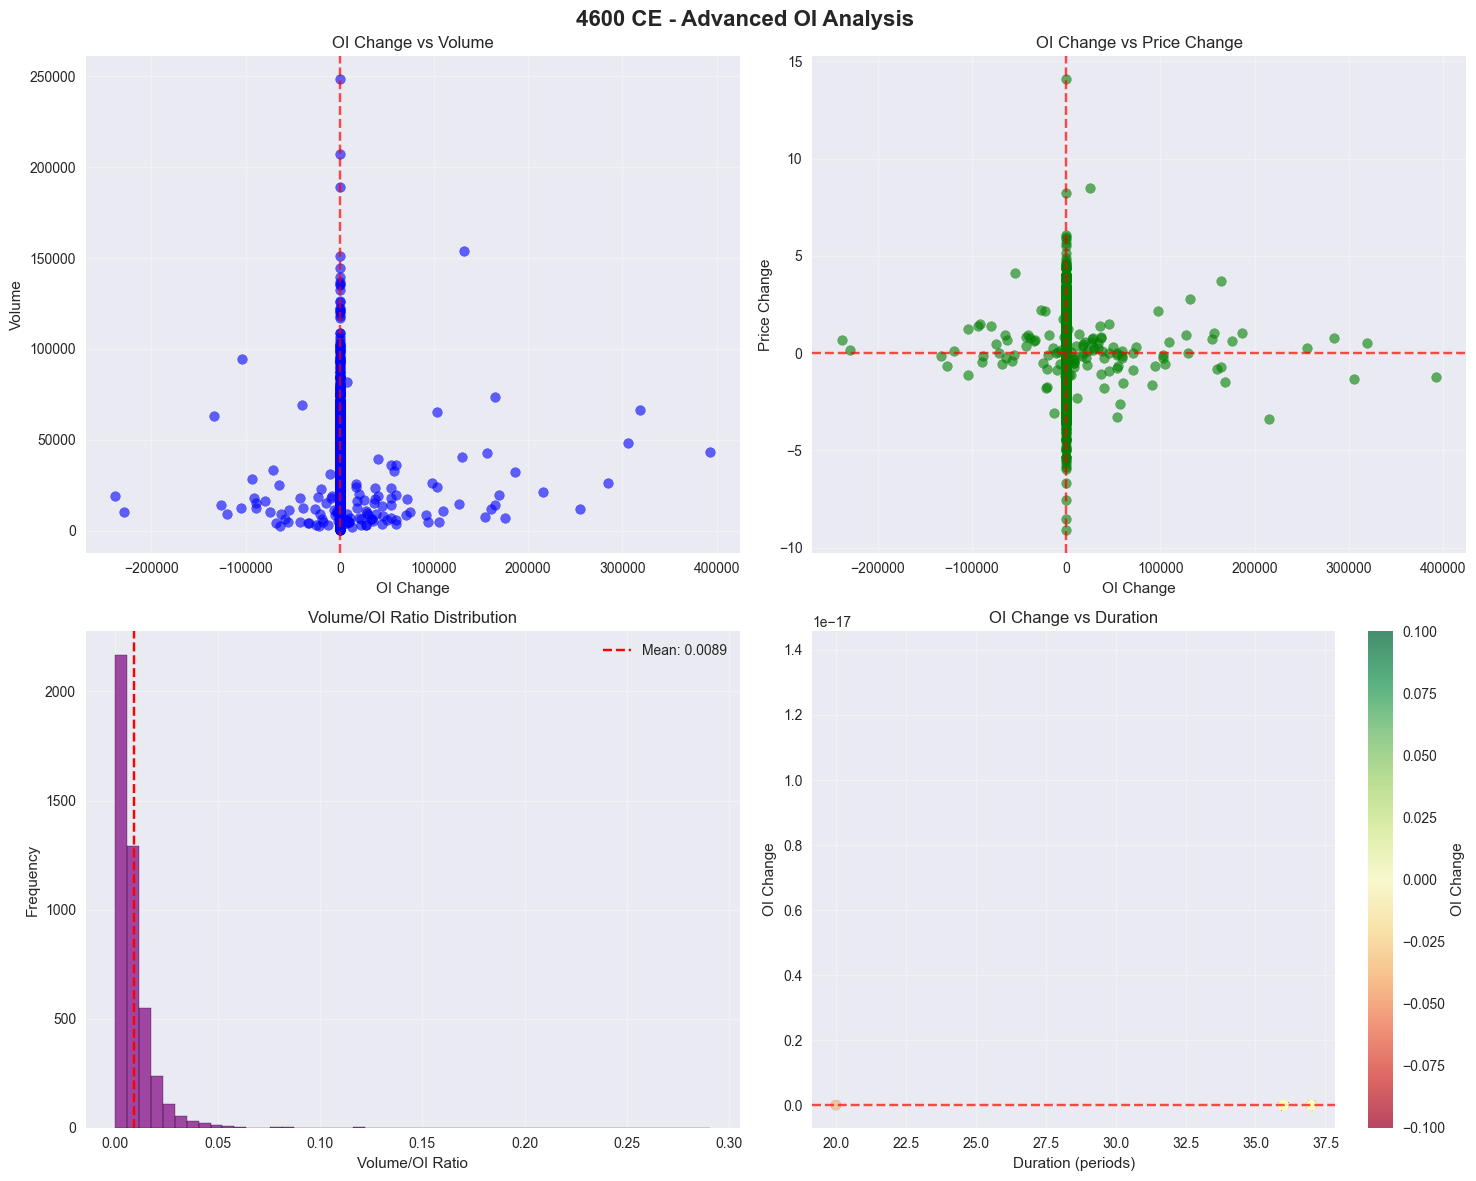


=== SUMMARY STATISTICS FOR 4600 CE ===
Average Volume per OI Change: inf
Volume Efficiency (median): nan
Most Active OI Change Interval: 119
Largest Volume Accumulation: 2,400,375
Average Duration per OI Change: 36.0 periods


In [6]:
# OI Change Analysis and Volume Accumulation
# This code analyzes OI changes and volume accumulation patterns

def analyze_oi_volume_patterns(analyzer):
    """
    Analyze OI changes and volume accumulation patterns
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    # Create a copy of the data for analysis
    df = analyzer.data.copy()
    
    # Calculate OI changes
    df['oi_change'] = df['oi'].diff()
    df['oi_change_pct'] = (df['oi_change'] / df['oi'].shift(1)) * 100
    
    # Calculate cumulative volume for OI change intervals
    df['cumulative_volume'] = df['volume'].cumsum()
    
    # Identify OI change intervals
    df['oi_change_interval'] = 0
    current_interval = 0
    
    for i in range(1, len(df)):
        if df['oi_change'].iloc[i] != 0:  # OI changed
            current_interval += 1
        df.iloc[i, df.columns.get_loc('oi_change_interval')] = current_interval
    
    # Calculate volume accumulation for each OI change interval
    interval_stats = []
    
    for interval in df['oi_change_interval'].unique():
        if interval == 0:
            continue
            
        interval_data = df[df['oi_change_interval'] == interval]
        
        if len(interval_data) > 0:
            oi_start = interval_data['oi'].iloc[0]
            oi_end = interval_data['oi'].iloc[-1]
            oi_change = oi_end - oi_start
            volume_accumulated = interval_data['volume'].sum()
            duration = len(interval_data)
            avg_price = interval_data['close'].mean()
            
            interval_stats.append({
                'interval': interval,
                'oi_start': oi_start,
                'oi_end': oi_end,
                'oi_change': oi_change,
                'oi_change_pct': (oi_change / oi_start) * 100 if oi_start != 0 else 0,
                'volume_accumulated': volume_accumulated,
                'duration': duration,
                'avg_price': avg_price,
                'start_time': interval_data['timestamp'].iloc[0],
                'end_time': interval_data['timestamp'].iloc[-1]
            })
    
    interval_df = pd.DataFrame(interval_stats)
    
    # Calculate volume/OI ratio
    df['volume_oi_ratio'] = df['volume'] / df['oi']
    df['cumulative_volume_oi_ratio'] = df['volume_oi_ratio'].cumsum()
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    
    # 1. OI Change Over Time
    axes[0, 0].plot(df['timestamp'], df['oi'], color='blue', linewidth=2, label='Open Interest')
    axes[0, 0].scatter(df['timestamp'], df['oi'], c=df['oi_change'], cmap='RdYlGn', s=20, alpha=0.7)
    axes[0, 0].set_title('Open Interest Changes Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Open Interest')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add colorbar for OI changes
    scatter = axes[0, 0].scatter(df['timestamp'], df['oi'], c=df['oi_change'], cmap='RdYlGn', s=20, alpha=0.7)
    plt.colorbar(scatter, ax=axes[0, 0], label='OI Change')
    
    # 2. Volume Accumulation vs OI Changes
    if not interval_df.empty:
        colors = ['green' if x > 0 else 'red' for x in interval_df['oi_change']]
        axes[0, 1].bar(range(len(interval_df)), interval_df['volume_accumulated'], 
                      color=colors, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Volume Accumulation per OI Change Interval', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Volume Accumulated')
        axes[0, 1].set_xlabel('OI Change Interval')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add OI change values on bars
        for i, (idx, row) in enumerate(interval_df.iterrows()):
            axes[0, 1].text(i, row['volume_accumulated'], f'{row["oi_change"]:,.0f}', 
                           ha='center', va='bottom', fontsize=8)
    
    # 3. Volume/OI Ratio Over Time
    axes[1, 0].plot(df['timestamp'], df['volume_oi_ratio'], color='purple', linewidth=2)
    axes[1, 0].set_title('Volume/OI Ratio Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Volume/OI Ratio')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add moving average of the ratio
    ratio_sma = df['volume_oi_ratio'].rolling(window=20).mean()
    axes[1, 0].plot(df['timestamp'], ratio_sma, color='red', linewidth=2, alpha=0.7, label='20-period SMA')
    axes[1, 0].legend()
    
    # 4. OI Change Distribution
    axes[1, 1].hist(df['oi_change'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', label='No Change')
    axes[1, 1].set_title('Distribution of OI Changes', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('OI Change')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Cumulative Volume vs Cumulative OI Change
    df['cumulative_oi_change'] = df['oi_change'].cumsum()
    
    axes[2, 0].plot(df['timestamp'], df['cumulative_volume'], label='Cumulative Volume', color='blue', linewidth=2)
    ax2 = axes[2, 0].twinx()
    ax2.plot(df['timestamp'], df['cumulative_oi_change'], label='Cumulative OI Change', color='red', linewidth=2)
    
    axes[2, 0].set_title('Cumulative Volume vs Cumulative OI Change', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Cumulative Volume', color='blue')
    ax2.set_ylabel('Cumulative OI Change', color='red')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = axes[2, 0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[2, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 6. Volume Efficiency (Volume per OI change)
    if not interval_df.empty:
        interval_df['volume_efficiency'] = interval_df['volume_accumulated'] / abs(interval_df['oi_change'])
        interval_df['volume_efficiency'] = interval_df['volume_efficiency'].replace([np.inf, -np.inf], np.nan)
        
        colors = ['green' if x > 0 else 'red' for x in interval_df['oi_change']]
        axes[2, 1].bar(range(len(interval_df)), interval_df['volume_efficiency'], 
                      color=colors, alpha=0.7, edgecolor='black')
        axes[2, 1].set_title('Volume Efficiency (Volume per OI Change)', fontsize=14, fontweight='bold')
        axes[2, 1].set_ylabel('Volume per OI Change')
        axes[2, 1].set_xlabel('OI Change Interval')
        axes[2, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - OI Change and Volume Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create detailed OI change analysis table
    print(f"\n=== DETAILED OI CHANGE ANALYSIS FOR {analyzer.strike} {analyzer.option_type} ===")
    
    if not interval_df.empty:
        print(f"\nTotal OI Change Intervals: {len(interval_df)}")
        print(f"Total OI Change: {interval_df['oi_change'].sum():,.0f}")
        print(f"Average OI Change per Interval: {interval_df['oi_change'].mean():,.0f}")
        print(f"Largest OI Increase: {interval_df['oi_change'].max():,.0f}")
        print(f"Largest OI Decrease: {interval_df['oi_change'].min():,.0f}")
        
        print(f"\nVolume Analysis:")
        print(f"Total Volume Accumulated: {interval_df['volume_accumulated'].sum():,.0f}")
        print(f"Average Volume per Interval: {interval_df['volume_accumulated'].mean():,.0f}")
        print(f"Average Volume/OI Ratio: {df['volume_oi_ratio'].mean():.4f}")
        
        # Show top 10 OI change intervals
        print(f"\nTop 10 OI Change Intervals:")
        top_intervals = interval_df.nlargest(10, 'oi_change')[['interval', 'oi_change', 'volume_accumulated', 'duration', 'oi_change_pct']]
        print(top_intervals.to_string(index=False))
        
        # Show bottom 10 OI change intervals
        print(f"\nBottom 10 OI Change Intervals:")
        bottom_intervals = interval_df.nsmallest(10, 'oi_change')[['interval', 'oi_change', 'volume_accumulated', 'duration', 'oi_change_pct']]
        print(bottom_intervals.to_string(index=False))
    
    # Create additional specialized charts
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. OI Change vs Volume Scatter
    axes[0, 0].scatter(df['oi_change'], df['volume'], alpha=0.6, color='blue')
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('OI Change vs Volume')
    axes[0, 0].set_xlabel('OI Change')
    axes[0, 0].set_ylabel('Volume')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. OI Change vs Price Change
    axes[0, 1].scatter(df['oi_change'], df['price_change'], alpha=0.6, color='green')
    axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].set_title('OI Change vs Price Change')
    axes[0, 1].set_xlabel('OI Change')
    axes[0, 1].set_ylabel('Price Change')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Volume/OI Ratio Distribution
    axes[1, 0].hist(df['volume_oi_ratio'].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].axvline(df['volume_oi_ratio'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["volume_oi_ratio"].mean():.4f}')
    axes[1, 0].set_title('Volume/OI Ratio Distribution')
    axes[1, 0].set_xlabel('Volume/OI Ratio')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. OI Change Duration Analysis
    if not interval_df.empty:
        axes[1, 1].scatter(interval_df['duration'], interval_df['oi_change'], 
                          c=interval_df['oi_change'], cmap='RdYlGn', alpha=0.7, s=50)
        axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.7)
        axes[1, 1].set_title('OI Change vs Duration')
        axes[1, 1].set_xlabel('Duration (periods)')
        axes[1, 1].set_ylabel('OI Change')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add colorbar
        scatter = axes[1, 1].scatter(interval_df['duration'], interval_df['oi_change'], 
                                   c=interval_df['oi_change'], cmap='RdYlGn', alpha=0.7, s=50)
        plt.colorbar(scatter, ax=axes[1, 1], label='OI Change')
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced OI Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return {
        'interval_analysis': interval_df,
        'oi_volume_data': df,
        'volume_oi_ratio': df['volume_oi_ratio'],
        'cumulative_volume': df['cumulative_volume'],
        'cumulative_oi_change': df['cumulative_oi_change']
    }

# Run the OI and Volume analysis
oi_volume_analysis = analyze_oi_volume_patterns(analyzer)

# Print summary statistics
print(f"\n=== SUMMARY STATISTICS FOR {analyzer.strike} {analyzer.option_type} ===")
if oi_volume_analysis['interval_analysis'] is not None and not oi_volume_analysis['interval_analysis'].empty:
    interval_df = oi_volume_analysis['interval_analysis']
    
    print(f"Average Volume per OI Change: {interval_df['volume_accumulated'].sum() / abs(interval_df['oi_change']).sum():.2f}")
    print(f"Volume Efficiency (median): {interval_df['volume_efficiency'].median():.2f}")
    print(f"Most Active OI Change Interval: {interval_df.loc[interval_df['volume_accumulated'].idxmax(), 'interval']}")
    print(f"Largest Volume Accumulation: {interval_df['volume_accumulated'].max():,.0f}")
    print(f"Average Duration per OI Change: {interval_df['duration'].mean():.1f} periods")

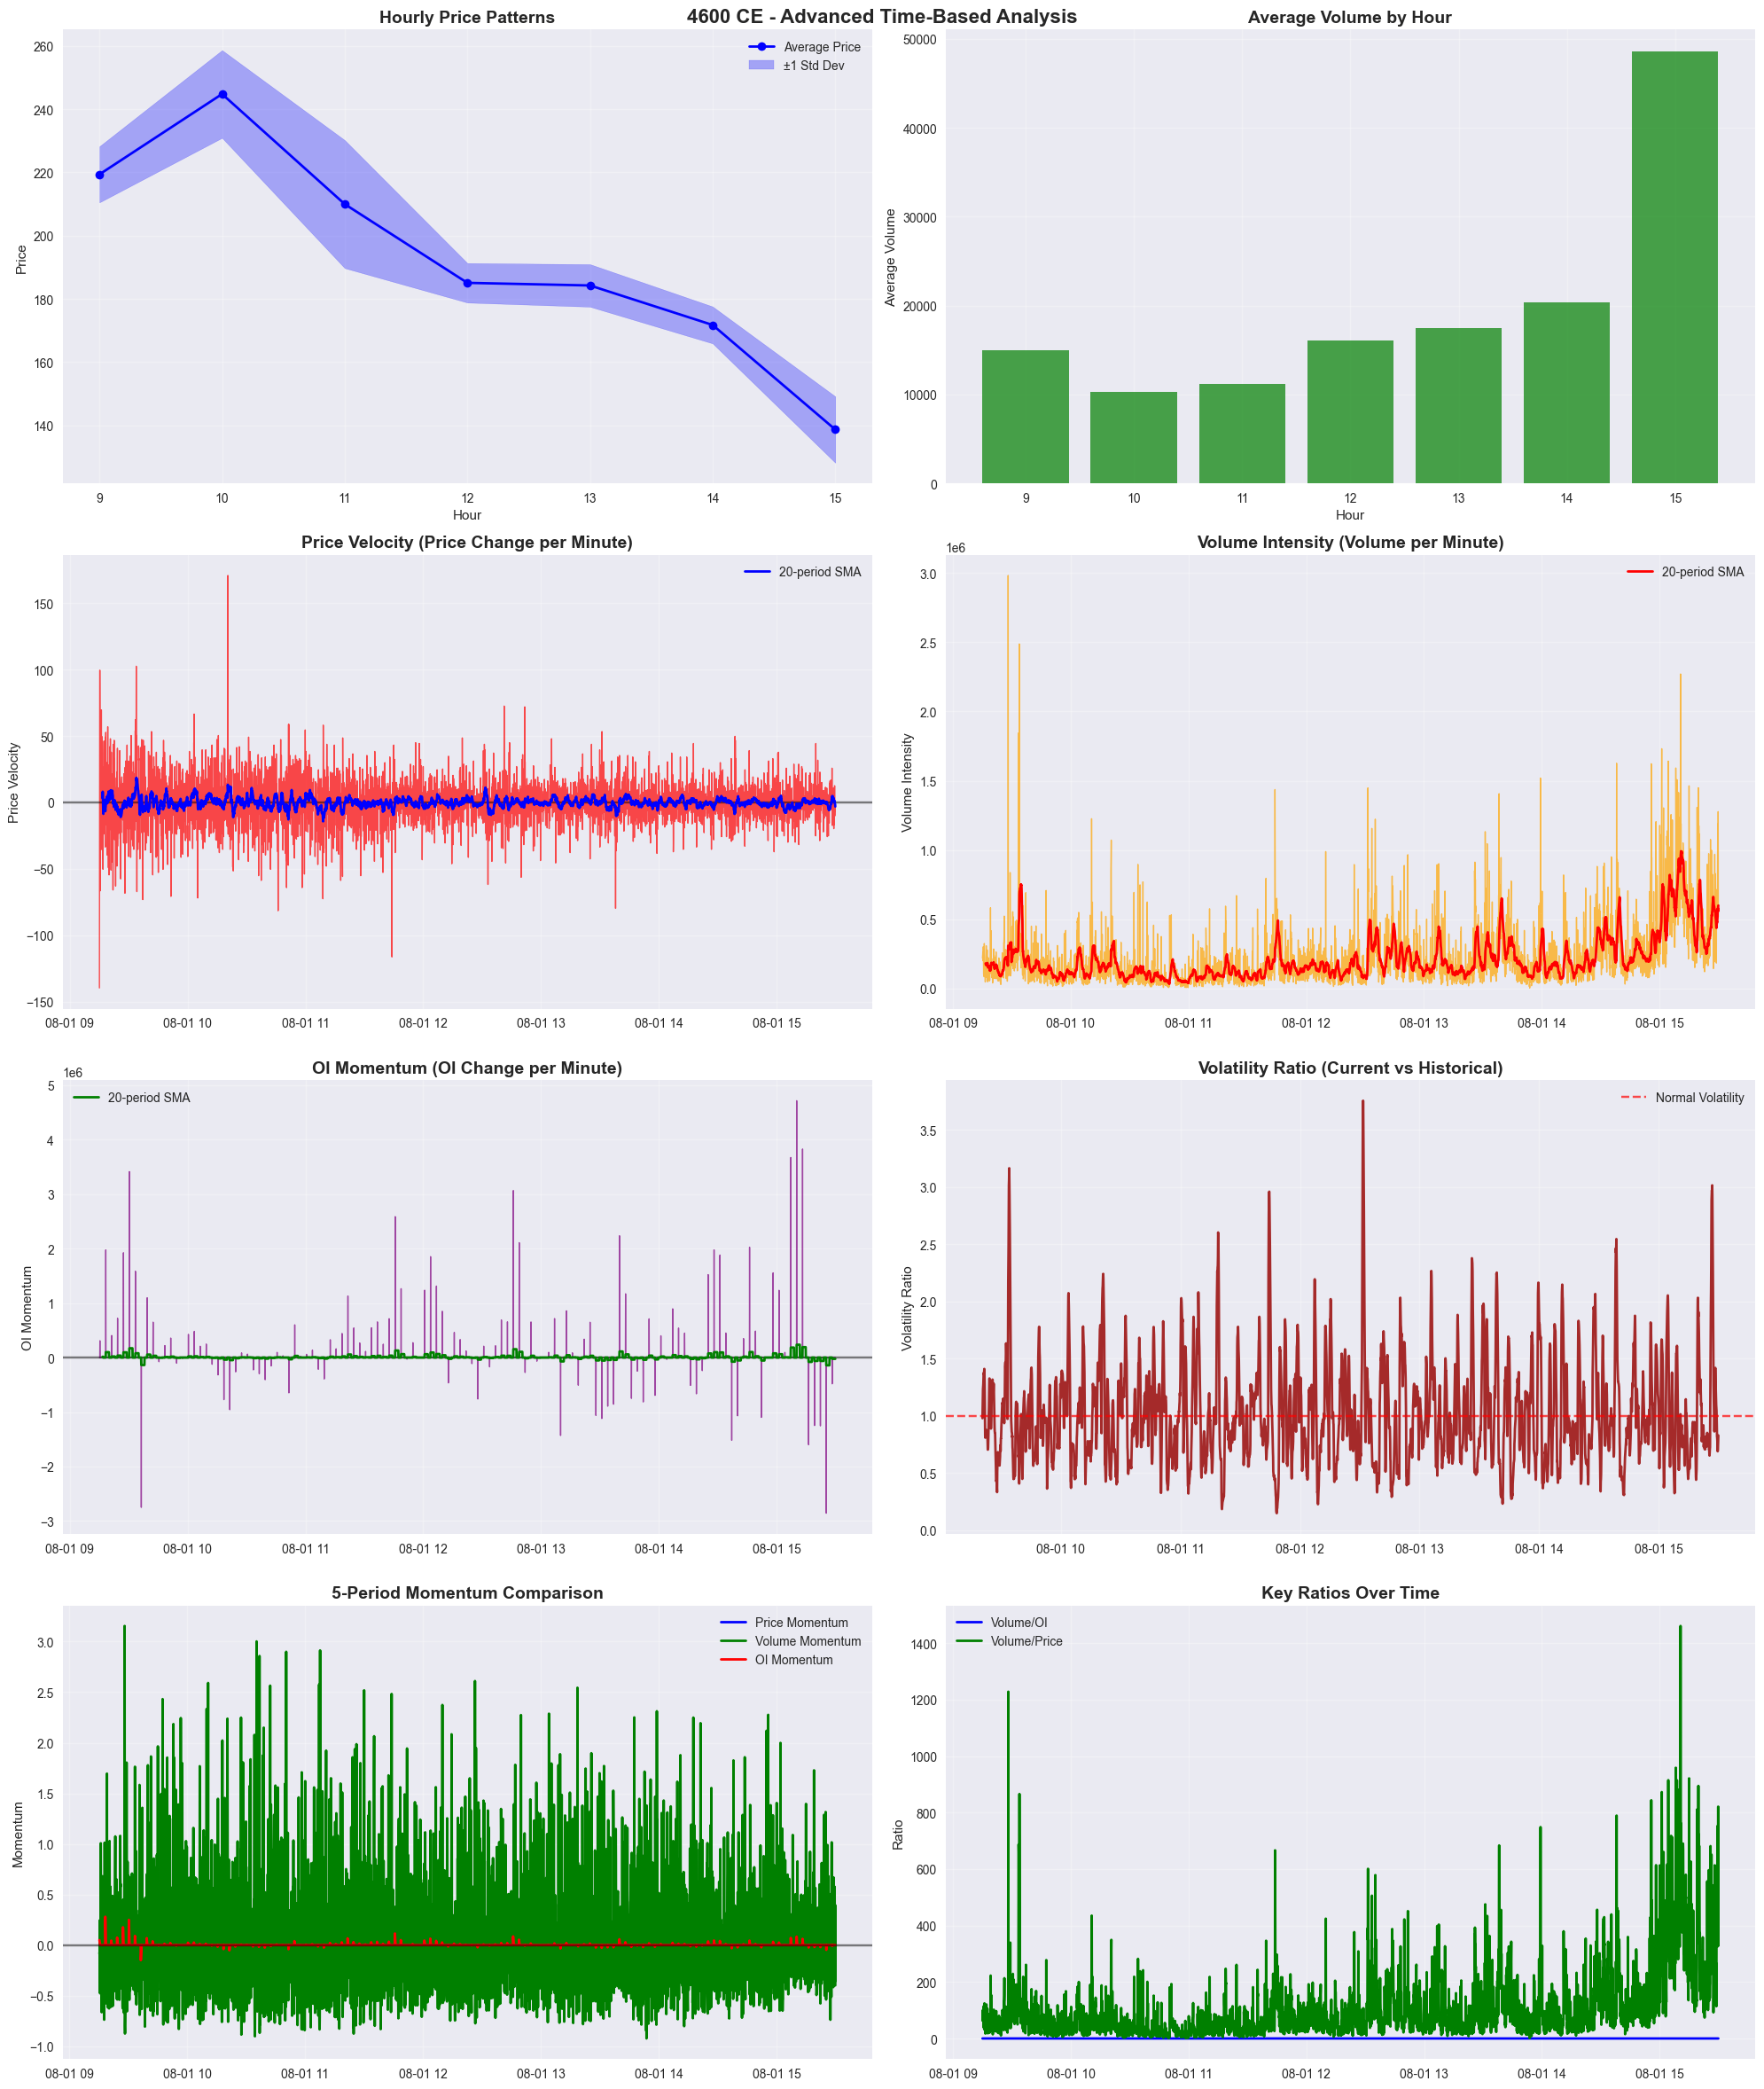

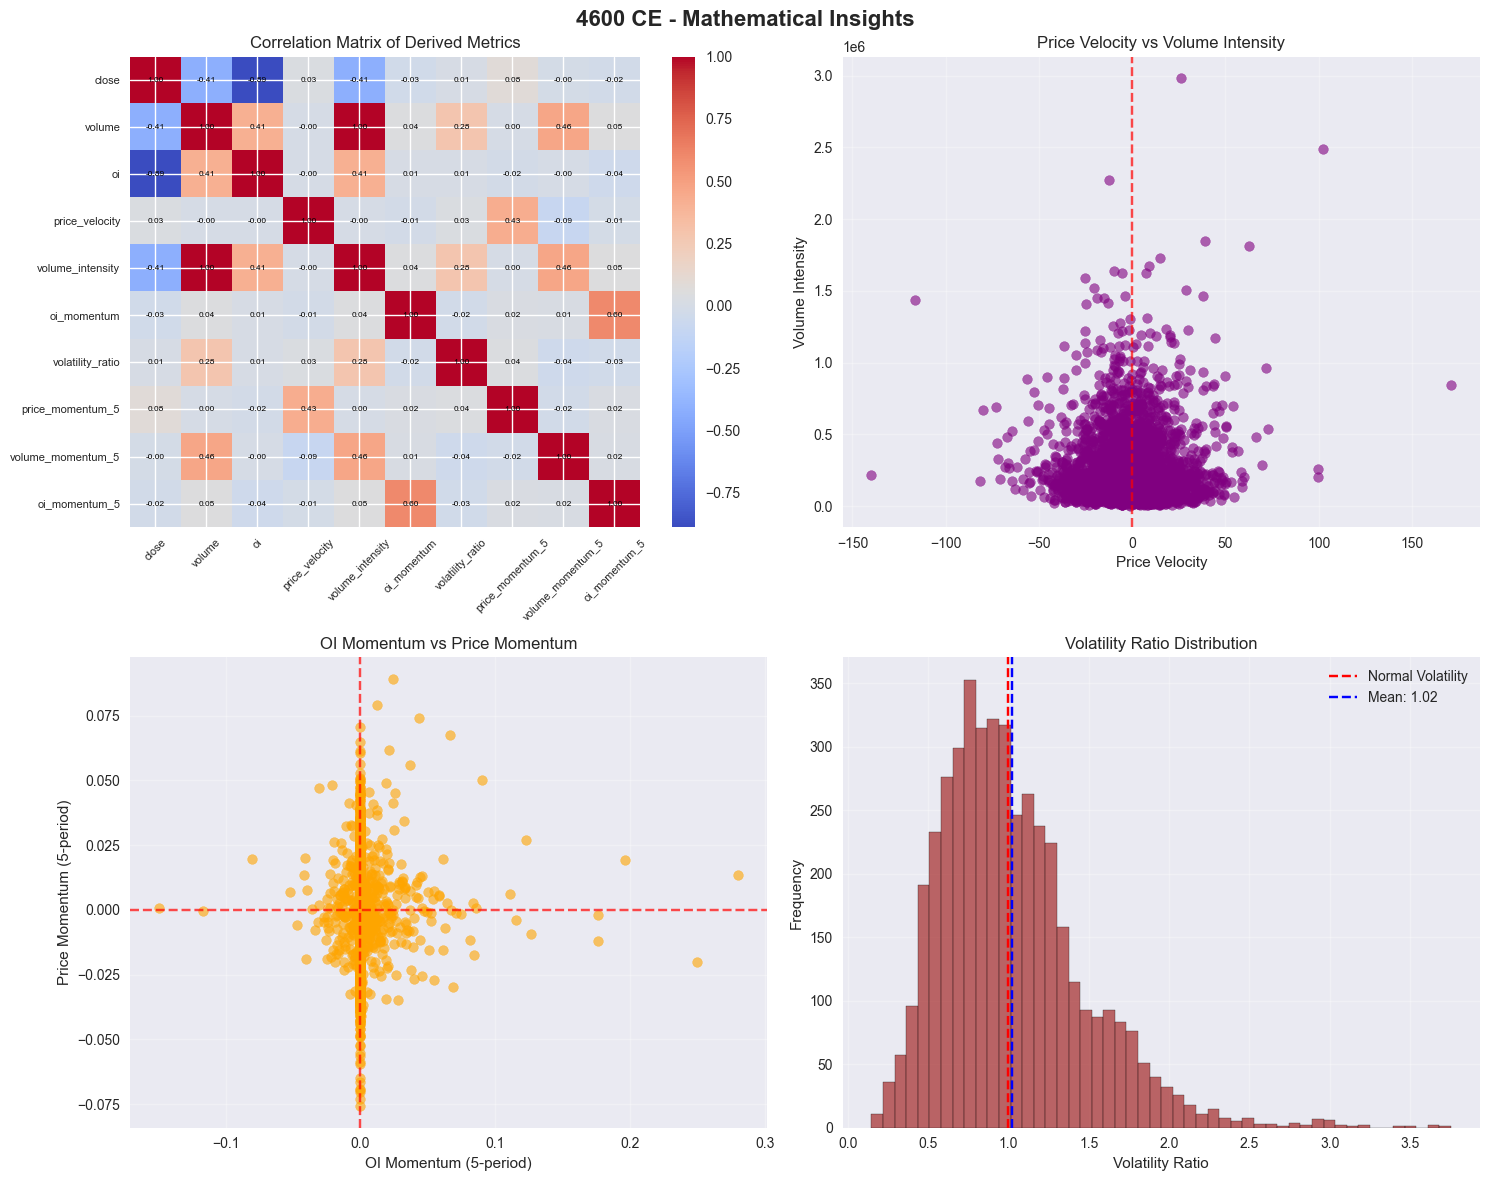


=== MATHEMATICAL INSIGHTS FOR 4600 CE ===

Price Velocity Analysis:
Average Price Velocity: -0.227517 points/minute
Price Velocity Std Dev: 16.671584
Max Positive Velocity: 171.000000
Max Negative Velocity: -139.800000

Volume Intensity Analysis:
Average Volume Intensity: 212867.90 contracts/minute
Peak Volume Intensity: 2983500.00
Volume Intensity Std Dev: 224020.41

OI Momentum Analysis:
Average OI Momentum: 9007.40 contracts/minute
Max OI Increase Rate: 4715100.00
Max OI Decrease Rate: -2857500.00

Volatility Analysis:
Average Volatility Ratio: 1.02
High Volatility Periods (>1.5x): 615 (13.7%)

Correlation Analysis:
Price-Volume Correlation: -0.412
Price-OI Correlation: -0.888
Volume-OI Correlation: 0.411

Momentum Analysis (5-period):
Positive Price Momentum: 2150 periods (47.8%)
Positive Volume Momentum: 1824 periods (40.5%)
Positive OI Momentum: 316 periods (7.0%)

Time-Based Insights:
Peak Volume Hour: 15:00
Peak Average Price Hour: 10:00
Trading Session Duration: 374.9 minutes

In [7]:
# Advanced Time-Based Analysis with Mathematical Operations
# This code provides deep insights into time, volume, and OI patterns

def advanced_time_analysis(analyzer):
    """
    Advanced analysis of time patterns, volume, and OI with mathematical insights
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    df = analyzer.data.copy()
    
    # Add time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['time_period'] = df['hour'] * 60 + df['minute']
    df['time_since_open'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds() / 60
    
    # Mathematical operations and derived metrics
    df['price_velocity'] = df['close'].diff() / df['time_since_open'].diff()  # Price change per minute
    df['volume_intensity'] = df['volume'] / df['time_since_open'].diff()  # Volume per minute
    df['oi_momentum'] = df['oi'].diff() / df['time_since_open'].diff()  # OI change per minute
    
    # Volatility calculations
    df['rolling_volatility'] = df['close'].rolling(window=20).std()
    df['volatility_ratio'] = df['rolling_volatility'] / df['rolling_volatility'].rolling(window=50).mean()
    
    # Volume and OI ratios
    df['volume_oi_ratio'] = df['volume'] / df['oi']
    df['volume_price_ratio'] = df['volume'] / df['close']
    df['oi_price_ratio'] = df['oi'] / df['close']
    
    # Momentum indicators
    df['price_momentum_5'] = df['close'] / df['close'].shift(5) - 1
    df['volume_momentum_5'] = df['volume'] / df['volume'].rolling(window=5).mean() - 1
    df['oi_momentum_5'] = df['oi'] / df['oi'].rolling(window=5).mean() - 1
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    
    # 1. Time-based Price Analysis
    hourly_price = df.groupby('hour')['close'].agg(['mean', 'std', 'min', 'max'])
    
    axes[0, 0].plot(hourly_price.index, hourly_price['mean'], 'o-', color='blue', linewidth=2, label='Average Price')
    axes[0, 0].fill_between(hourly_price.index, 
                           hourly_price['mean'] - hourly_price['std'],
                           hourly_price['mean'] + hourly_price['std'],
                           alpha=0.3, color='blue', label='±1 Std Dev')
    axes[0, 0].set_title('Hourly Price Patterns', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Volume Intensity Over Time
    hourly_volume = df.groupby('hour')['volume'].mean()
    axes[0, 1].bar(hourly_volume.index, hourly_volume.values, alpha=0.7, color='green')
    axes[0, 1].set_title('Average Volume by Hour', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Average Volume')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Price Velocity Analysis
    axes[1, 0].plot(df['timestamp'], df['price_velocity'], color='red', linewidth=1, alpha=0.7)
    axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].set_title('Price Velocity (Price Change per Minute)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Price Velocity')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add moving average of price velocity
    velocity_sma = df['price_velocity'].rolling(window=20).mean()
    axes[1, 0].plot(df['timestamp'], velocity_sma, color='blue', linewidth=2, label='20-period SMA')
    axes[1, 0].legend()
    
    # 4. Volume Intensity Analysis
    axes[1, 1].plot(df['timestamp'], df['volume_intensity'], color='orange', linewidth=1, alpha=0.7)
    axes[1, 1].set_title('Volume Intensity (Volume per Minute)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Volume Intensity')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add moving average of volume intensity
    volume_intensity_sma = df['volume_intensity'].rolling(window=20).mean()
    axes[1, 1].plot(df['timestamp'], volume_intensity_sma, color='red', linewidth=2, label='20-period SMA')
    axes[1, 1].legend()
    
    # 5. OI Momentum Analysis
    axes[2, 0].plot(df['timestamp'], df['oi_momentum'], color='purple', linewidth=1, alpha=0.7)
    axes[2, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[2, 0].set_title('OI Momentum (OI Change per Minute)', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('OI Momentum')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Add moving average of OI momentum
    oi_momentum_sma = df['oi_momentum'].rolling(window=20).mean()
    axes[2, 0].plot(df['timestamp'], oi_momentum_sma, color='green', linewidth=2, label='20-period SMA')
    axes[2, 0].legend()
    
    # 6. Volatility Ratio Analysis
    axes[2, 1].plot(df['timestamp'], df['volatility_ratio'], color='brown', linewidth=2)
    axes[2, 1].axhline(1, color='red', linestyle='--', alpha=0.7, label='Normal Volatility')
    axes[2, 1].set_title('Volatility Ratio (Current vs Historical)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Volatility Ratio')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    # 7. Momentum Comparison
    axes[3, 0].plot(df['timestamp'], df['price_momentum_5'], label='Price Momentum', color='blue', linewidth=2)
    axes[3, 0].plot(df['timestamp'], df['volume_momentum_5'], label='Volume Momentum', color='green', linewidth=2)
    axes[3, 0].plot(df['timestamp'], df['oi_momentum_5'], label='OI Momentum', color='red', linewidth=2)
    axes[3, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[3, 0].set_title('5-Period Momentum Comparison', fontsize=14, fontweight='bold')
    axes[3, 0].set_ylabel('Momentum')
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)
    
    # 8. Ratio Analysis
    axes[3, 1].plot(df['timestamp'], df['volume_oi_ratio'], label='Volume/OI', color='blue', linewidth=2)
    axes[3, 1].plot(df['timestamp'], df['volume_price_ratio'], label='Volume/Price', color='green', linewidth=2)
    axes[3, 1].set_title('Key Ratios Over Time', fontsize=14, fontweight='bold')
    axes[3, 1].set_ylabel('Ratio')
    axes[3, 1].legend()
    axes[3, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced Time-Based Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create mathematical insights and correlations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Correlation Heatmap
    correlation_vars = ['close', 'volume', 'oi', 'price_velocity', 'volume_intensity', 
                       'oi_momentum', 'volatility_ratio', 'price_momentum_5', 
                       'volume_momentum_5', 'oi_momentum_5']
    
    correlation_data = df[correlation_vars].corr()
    
    im = axes[0, 0].imshow(correlation_data, cmap='coolwarm', aspect='auto')
    axes[0, 0].set_xticks(range(len(correlation_data.columns)))
    axes[0, 0].set_yticks(range(len(correlation_data.columns)))
    axes[0, 0].set_xticklabels(correlation_data.columns, rotation=45, fontsize=8)
    axes[0, 0].set_yticklabels(correlation_data.columns, fontsize=8)
    axes[0, 0].set_title('Correlation Matrix of Derived Metrics')
    
    # Add correlation values
    for i in range(len(correlation_data.columns)):
        for j in range(len(correlation_data.columns)):
            text = axes[0, 0].text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=6)
    
    plt.colorbar(im, ax=axes[0, 0])
    
    # 2. Price Velocity vs Volume Intensity
    axes[0, 1].scatter(df['price_velocity'], df['volume_intensity'], alpha=0.6, color='purple')
    axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].set_title('Price Velocity vs Volume Intensity')
    axes[0, 1].set_xlabel('Price Velocity')
    axes[0, 1].set_ylabel('Volume Intensity')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. OI Momentum vs Price Momentum
    axes[1, 0].scatter(df['oi_momentum_5'], df['price_momentum_5'], alpha=0.6, color='orange')
    axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('OI Momentum vs Price Momentum')
    axes[1, 0].set_xlabel('OI Momentum (5-period)')
    axes[1, 0].set_ylabel('Price Momentum (5-period)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Volatility Ratio Distribution
    axes[1, 1].hist(df['volatility_ratio'].dropna(), bins=50, alpha=0.7, color='brown', edgecolor='black')
    axes[1, 1].axvline(1, color='red', linestyle='--', label='Normal Volatility')
    axes[1, 1].axvline(df['volatility_ratio'].mean(), color='blue', linestyle='--', 
                      label=f'Mean: {df["volatility_ratio"].mean():.2f}')
    axes[1, 1].set_title('Volatility Ratio Distribution')
    axes[1, 1].set_xlabel('Volatility Ratio')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Mathematical Insights', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Generate mathematical insights
    print(f"\n=== MATHEMATICAL INSIGHTS FOR {analyzer.strike} {analyzer.option_type} ===")
    
    # Price velocity insights
    avg_velocity = df['price_velocity'].mean()
    velocity_std = df['price_velocity'].std()
    print(f"\nPrice Velocity Analysis:")
    print(f"Average Price Velocity: {avg_velocity:.6f} points/minute")
    print(f"Price Velocity Std Dev: {velocity_std:.6f}")
    print(f"Max Positive Velocity: {df['price_velocity'].max():.6f}")
    print(f"Max Negative Velocity: {df['price_velocity'].min():.6f}")
    
    # Volume intensity insights
    avg_volume_intensity = df['volume_intensity'].mean()
    print(f"\nVolume Intensity Analysis:")
    print(f"Average Volume Intensity: {avg_volume_intensity:.2f} contracts/minute")
    print(f"Peak Volume Intensity: {df['volume_intensity'].max():.2f}")
    print(f"Volume Intensity Std Dev: {df['volume_intensity'].std():.2f}")
    
    # OI momentum insights
    avg_oi_momentum = df['oi_momentum'].mean()
    print(f"\nOI Momentum Analysis:")
    print(f"Average OI Momentum: {avg_oi_momentum:.2f} contracts/minute")
    print(f"Max OI Increase Rate: {df['oi_momentum'].max():.2f}")
    print(f"Max OI Decrease Rate: {df['oi_momentum'].min():.2f}")
    
    # Volatility insights
    avg_volatility_ratio = df['volatility_ratio'].mean()
    high_volatility_periods = (df['volatility_ratio'] > 1.5).sum()
    print(f"\nVolatility Analysis:")
    print(f"Average Volatility Ratio: {avg_volatility_ratio:.2f}")
    print(f"High Volatility Periods (>1.5x): {high_volatility_periods} ({high_volatility_periods/len(df)*100:.1f}%)")
    
    # Correlation insights
    price_volume_corr = df['close'].corr(df['volume'])
    price_oi_corr = df['close'].corr(df['oi'])
    volume_oi_corr = df['volume'].corr(df['oi'])
    
    print(f"\nCorrelation Analysis:")
    print(f"Price-Volume Correlation: {price_volume_corr:.3f}")
    print(f"Price-OI Correlation: {price_oi_corr:.3f}")
    print(f"Volume-OI Correlation: {volume_oi_corr:.3f}")
    
    # Momentum insights
    positive_price_momentum = (df['price_momentum_5'] > 0).sum()
    positive_volume_momentum = (df['volume_momentum_5'] > 0).sum()
    positive_oi_momentum = (df['oi_momentum_5'] > 0).sum()
    
    print(f"\nMomentum Analysis (5-period):")
    print(f"Positive Price Momentum: {positive_price_momentum} periods ({positive_price_momentum/len(df)*100:.1f}%)")
    print(f"Positive Volume Momentum: {positive_volume_momentum} periods ({positive_volume_momentum/len(df)*100:.1f}%)")
    print(f"Positive OI Momentum: {positive_oi_momentum} periods ({positive_oi_momentum/len(df)*100:.1f}%)")
    
    # Time-based insights
    peak_hour_volume = hourly_volume.idxmax()
    peak_hour_price = hourly_price['mean'].idxmax()
    
    print(f"\nTime-Based Insights:")
    print(f"Peak Volume Hour: {peak_hour_volume}:00")
    print(f"Peak Average Price Hour: {peak_hour_price}:00")
    print(f"Trading Session Duration: {df['time_since_open'].max():.1f} minutes")
    
    return {
        'hourly_analysis': hourly_price,
        'volume_intensity': df['volume_intensity'],
        'price_velocity': df['price_velocity'],
        'oi_momentum': df['oi_momentum'],
        'volatility_ratio': df['volatility_ratio'],
        'correlation_matrix': correlation_data,
        'momentum_data': {
            'price_momentum': df['price_momentum_5'],
            'volume_momentum': df['volume_momentum_5'],
            'oi_momentum': df['oi_momentum_5']
        }
    }

# Run the advanced time analysis
time_analysis = advanced_time_analysis(analyzer)

# Additional statistical analysis
print(f"\n=== ADDITIONAL STATISTICAL INSIGHTS ===")

# Calculate efficiency metrics
df = analyzer.data.copy()
df['price_efficiency'] = df['close'].pct_change().abs() / df['volume']
df['oi_efficiency'] = df['oi'].pct_change().abs() / df['volume']

print(f"Price Efficiency (avg): {df['price_efficiency'].mean():.6f}")
print(f"OI Efficiency (avg): {df['oi_efficiency'].mean():.6f}")

# Calculate trend strength
df['trend_strength'] = df['close'].rolling(window=20).apply(lambda x: abs(x.iloc[-1] - x.iloc[0]) / x.std())
print(f"Average Trend Strength: {df['trend_strength'].mean():.2f}")

# Calculate market microstructure metrics
df['bid_ask_spread_proxy'] = (df['high'] - df['low']) / df['close']
print(f"Average Spread Proxy: {df['bid_ask_spread_proxy'].mean():.4f}")

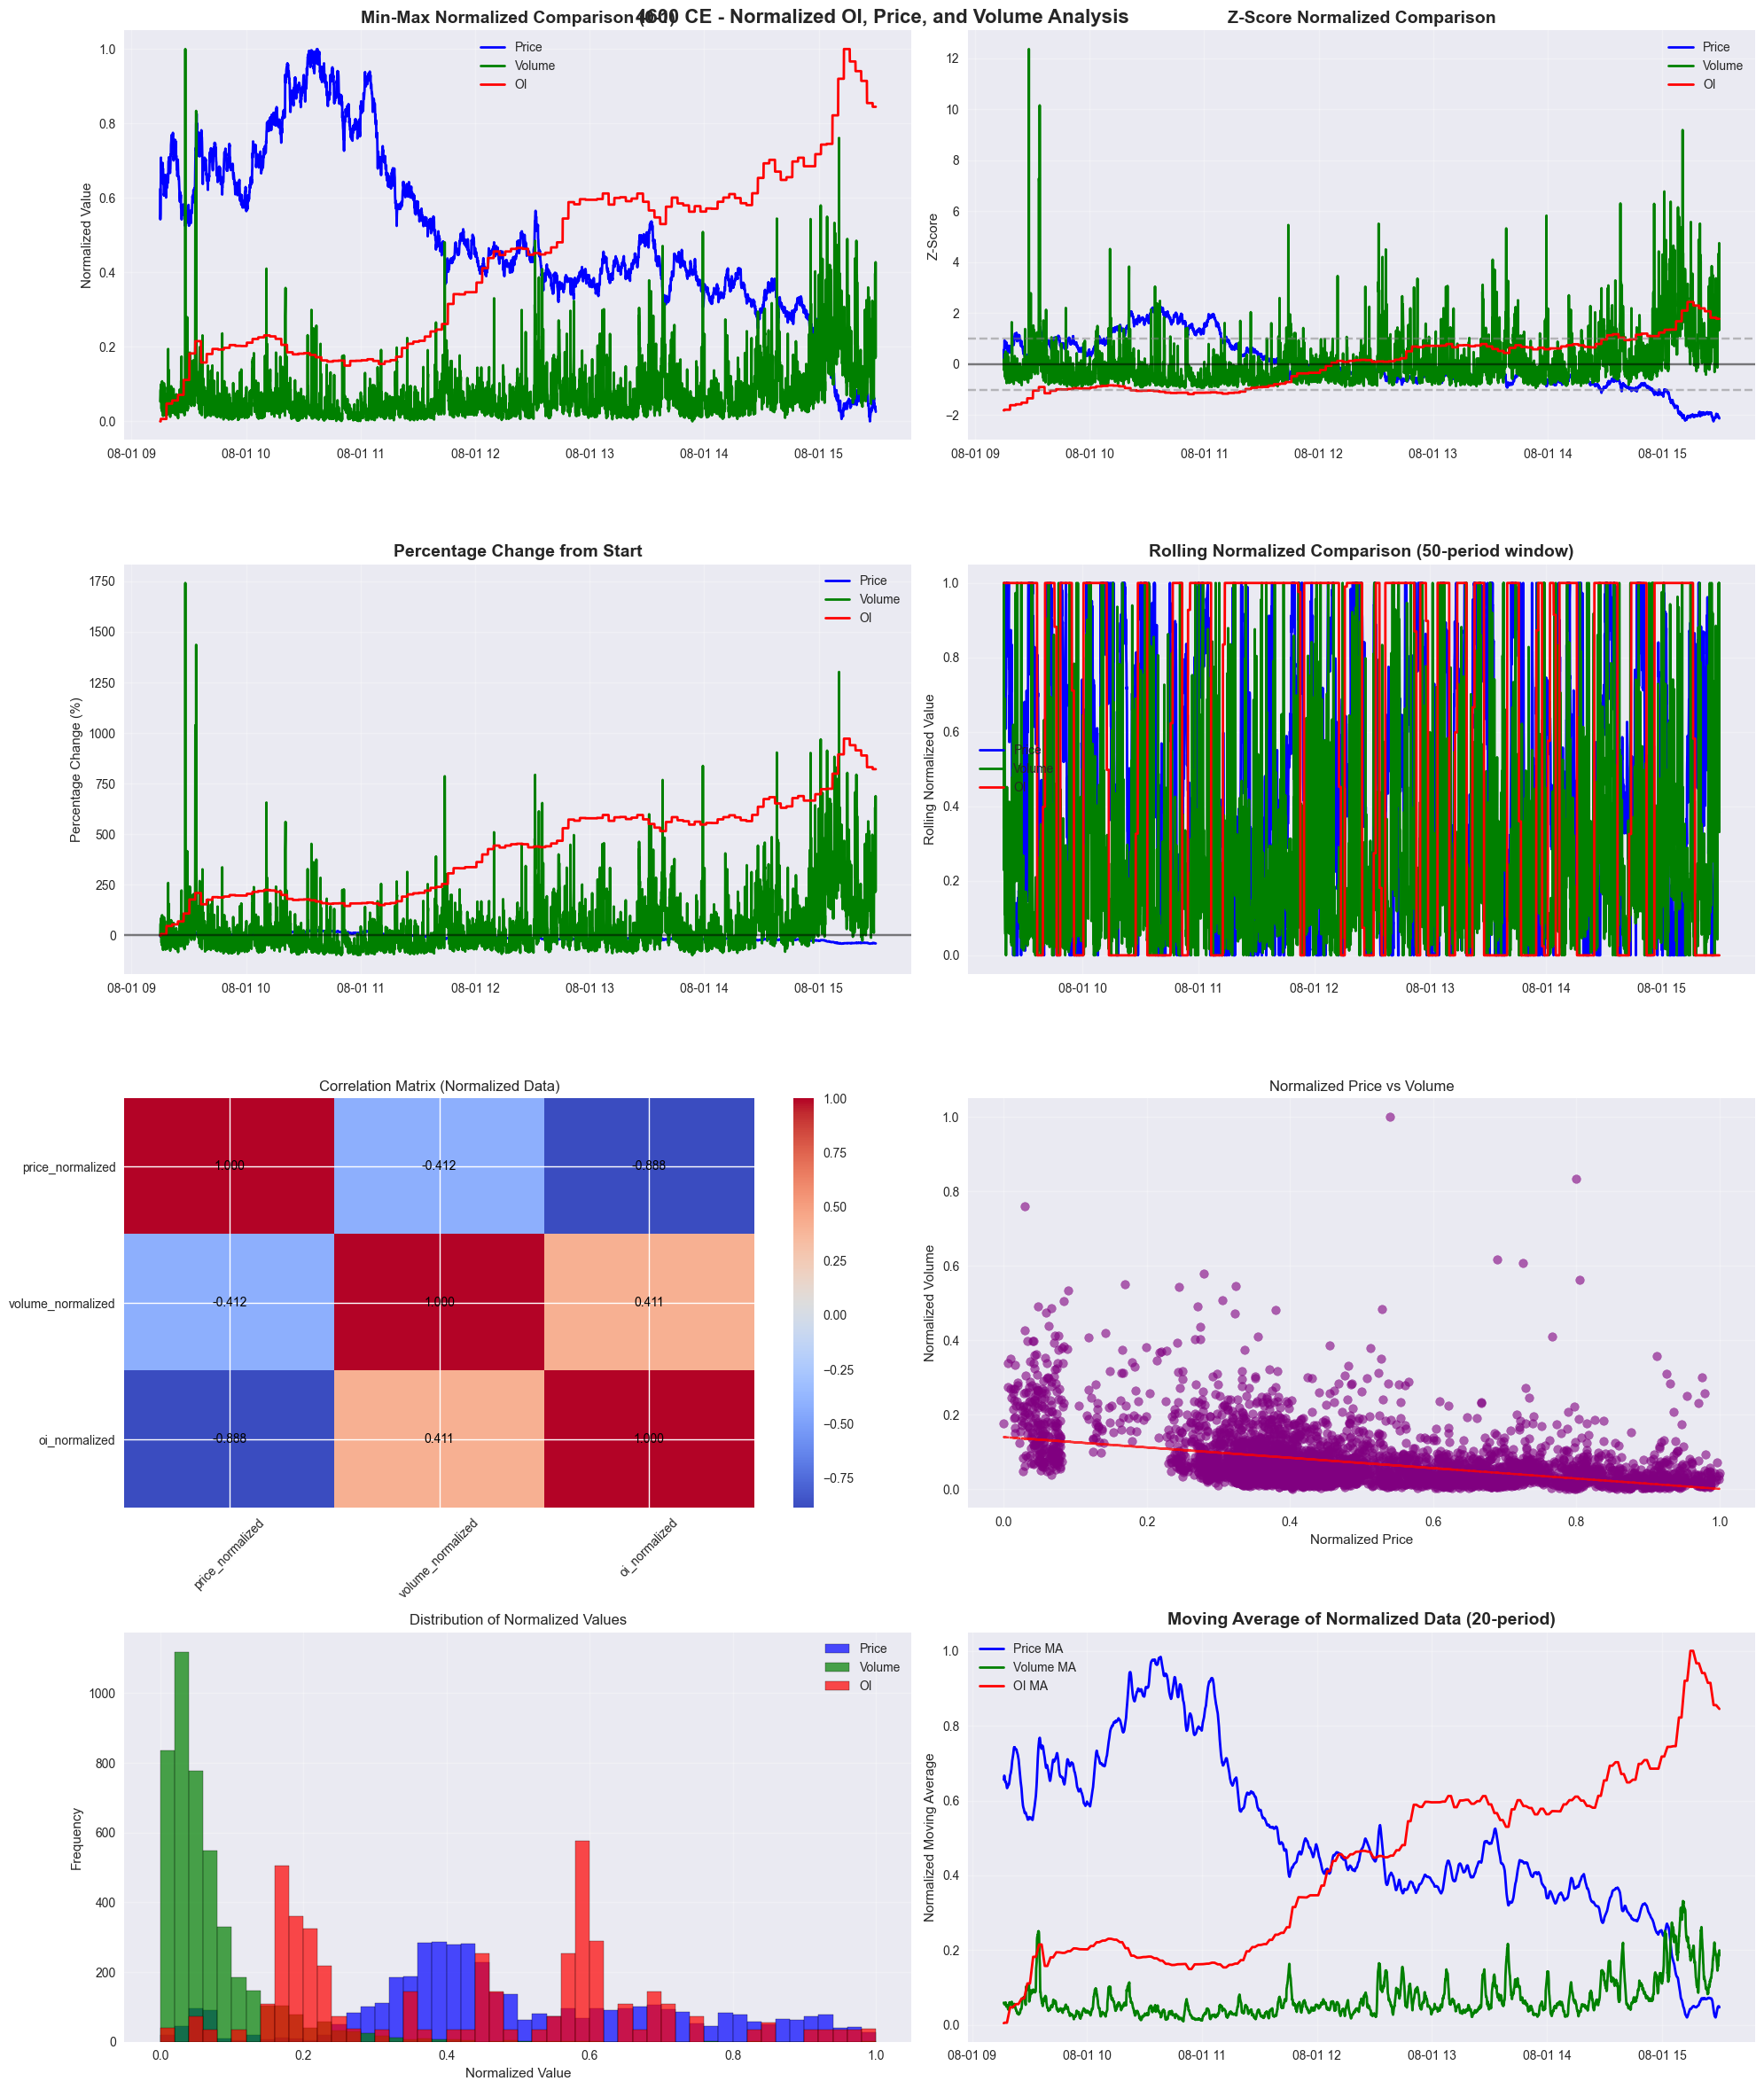

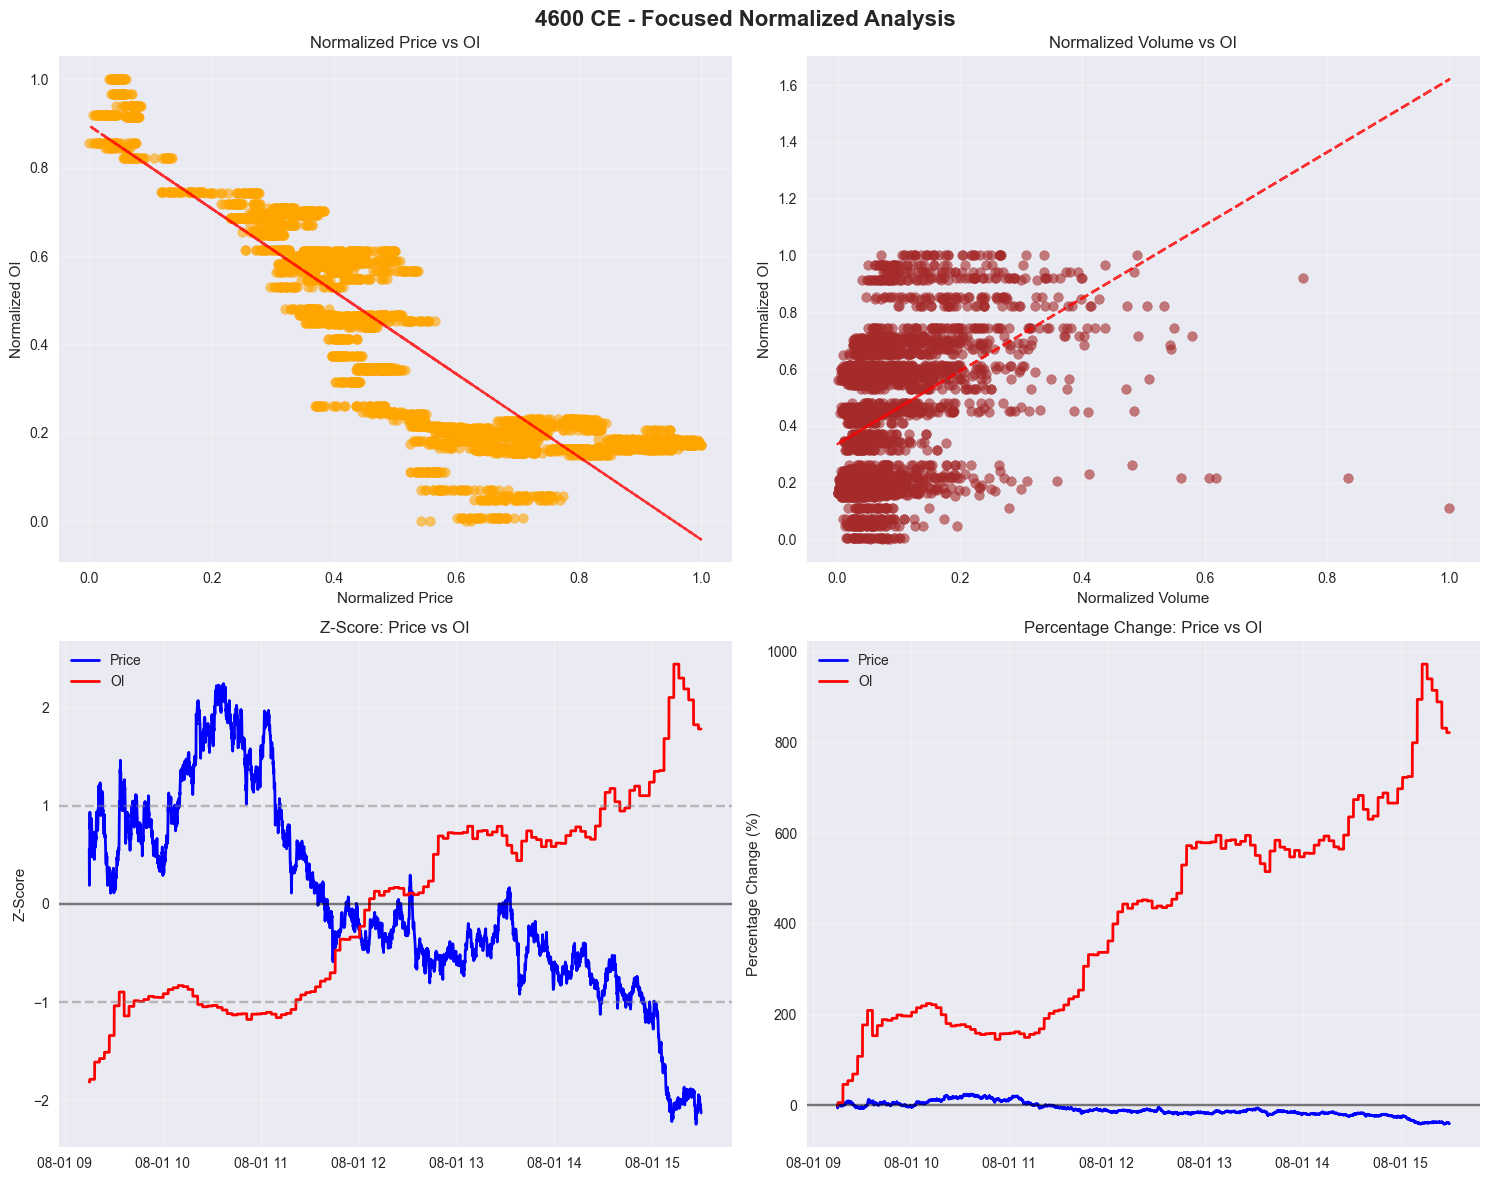


=== NORMALIZED ANALYSIS INSIGHTS FOR 4600 CE ===

Normalized Correlation Analysis:
Price-Volume Correlation: -0.412
Price-OI Correlation: -0.888
Volume-OI Correlation: 0.411

Z-Score Analysis (Extreme Values > 2 std dev):
Price Extreme Periods: 229 (5.1%)
Volume Extreme Periods: 229 (5.1%)
OI Extreme Periods: 181 (4.0%)

Maximum Percentage Changes:
Price Max Change: 24.98%
Volume Max Change: 1741.67%
OI Max Change: 972.36%

Rolling Normalization Analysis (High Values > 0.8):
Price High Periods: 1058 (23.5%)
Volume High Periods: 209 (4.6%)
OI High Periods: 2757 (61.3%)

=== ADDITIONAL STATISTICAL SUMMARY ===
Coefficient of Variation (Relative Volatility):
Price CV: 0.161
Volume CV: 1.052
OI CV: 0.444

Distribution Shape Analysis:
Price Skewness: 0.222 (Positive = right-skewed)
Volume Skewness: 3.119
OI Skewness: 0.267
Price Kurtosis: -0.352 (High = heavy tails)
Volume Kurtosis: 16.594
OI Kurtosis: -0.899


In [8]:
# Normalized OI, Price, and Volume Analysis
# This code normalizes the data and creates focused visualizations

def normalized_analysis(analyzer):
    """
    Create normalized analysis of OI, Price, and Volume
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    df = analyzer.data.copy()
    
    # Normalize the data using different methods
    # Method 1: Min-Max normalization (0 to 1)
    df['price_normalized'] = (df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())
    df['volume_normalized'] = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())
    df['oi_normalized'] = (df['oi'] - df['oi'].min()) / (df['oi'].max() - df['oi'].min())
    
    # Method 2: Z-score normalization (mean=0, std=1)
    df['price_zscore'] = (df['close'] - df['close'].mean()) / df['close'].std()
    df['volume_zscore'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()
    df['oi_zscore'] = (df['oi'] - df['oi'].mean()) / df['oi'].std()
    
    # Method 3: Percentage change from start
    df['price_pct_change'] = (df['close'] - df['close'].iloc[0]) / df['close'].iloc[0] * 100
    df['volume_pct_change'] = (df['volume'] - df['volume'].iloc[0]) / df['volume'].iloc[0] * 100
    df['oi_pct_change'] = (df['oi'] - df['oi'].iloc[0]) / df['oi'].iloc[0] * 100
    
    # Method 4: Rolling normalization (relative to recent history)
    window = 50
    df['price_rolling_norm'] = (df['close'] - df['close'].rolling(window=window).min()) / \
                               (df['close'].rolling(window=window).max() - df['close'].rolling(window=window).min())
    df['volume_rolling_norm'] = (df['volume'] - df['volume'].rolling(window=window).min()) / \
                                (df['volume'].rolling(window=window).max() - df['volume'].rolling(window=window).min())
    df['oi_rolling_norm'] = (df['oi'] - df['oi'].rolling(window=window).min()) / \
                            (df['oi'].rolling(window=window).max() - df['oi'].rolling(window=window).min())
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    
    # 1. Min-Max Normalized Comparison
    axes[0, 0].plot(df['timestamp'], df['price_normalized'], label='Price', color='blue', linewidth=2)
    axes[0, 0].plot(df['timestamp'], df['volume_normalized'], label='Volume', color='green', linewidth=2)
    axes[0, 0].plot(df['timestamp'], df['oi_normalized'], label='OI', color='red', linewidth=2)
    axes[0, 0].set_title('Min-Max Normalized Comparison (0-1)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Normalized Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Z-Score Normalized Comparison
    axes[0, 1].plot(df['timestamp'], df['price_zscore'], label='Price', color='blue', linewidth=2)
    axes[0, 1].plot(df['timestamp'], df['volume_zscore'], label='Volume', color='green', linewidth=2)
    axes[0, 1].plot(df['timestamp'], df['oi_zscore'], label='OI', color='red', linewidth=2)
    axes[0, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0, 1].axhline(1, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(-1, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Z-Score Normalized Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Z-Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Percentage Change Comparison
    axes[1, 0].plot(df['timestamp'], df['price_pct_change'], label='Price', color='blue', linewidth=2)
    axes[1, 0].plot(df['timestamp'], df['volume_pct_change'], label='Volume', color='green', linewidth=2)
    axes[1, 0].plot(df['timestamp'], df['oi_pct_change'], label='OI', color='red', linewidth=2)
    axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].set_title('Percentage Change from Start', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Percentage Change (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Rolling Normalized Comparison
    axes[1, 1].plot(df['timestamp'], df['price_rolling_norm'], label='Price', color='blue', linewidth=2)
    axes[1, 1].plot(df['timestamp'], df['volume_rolling_norm'], label='Volume', color='green', linewidth=2)
    axes[1, 1].plot(df['timestamp'], df['oi_rolling_norm'], label='OI', color='red', linewidth=2)
    axes[1, 1].set_title(f'Rolling Normalized Comparison ({window}-period window)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Rolling Normalized Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Correlation Analysis of Normalized Data
    normalized_corr = df[['price_normalized', 'volume_normalized', 'oi_normalized']].corr()
    
    im = axes[2, 0].imshow(normalized_corr, cmap='coolwarm', aspect='auto')
    axes[2, 0].set_xticks(range(len(normalized_corr.columns)))
    axes[2, 0].set_yticks(range(len(normalized_corr.columns)))
    axes[2, 0].set_xticklabels(normalized_corr.columns, rotation=45)
    axes[2, 0].set_yticklabels(normalized_corr.columns)
    axes[2, 0].set_title('Correlation Matrix (Normalized Data)')
    
    # Add correlation values
    for i in range(len(normalized_corr.columns)):
        for j in range(len(normalized_corr.columns)):
            text = axes[2, 0].text(j, i, f'{normalized_corr.iloc[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontsize=10)
    
    plt.colorbar(im, ax=axes[2, 0])
    
    # 6. Scatter Plot: Normalized Price vs Volume
    axes[2, 1].scatter(df['price_normalized'], df['volume_normalized'], alpha=0.6, color='purple')
    axes[2, 1].set_title('Normalized Price vs Volume')
    axes[2, 1].set_xlabel('Normalized Price')
    axes[2, 1].set_ylabel('Normalized Volume')
    axes[2, 1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['price_normalized'].dropna(), df['volume_normalized'].dropna(), 1)
    p = np.poly1d(z)
    axes[2, 1].plot(df['price_normalized'], p(df['price_normalized']), "r--", alpha=0.8)
    
    # 7. Distribution of Normalized Values
    axes[3, 0].hist(df['price_normalized'], bins=50, alpha=0.7, label='Price', color='blue', edgecolor='black')
    axes[3, 0].hist(df['volume_normalized'], bins=50, alpha=0.7, label='Volume', color='green', edgecolor='black')
    axes[3, 0].hist(df['oi_normalized'], bins=50, alpha=0.7, label='OI', color='red', edgecolor='black')
    axes[3, 0].set_title('Distribution of Normalized Values')
    axes[3, 0].set_xlabel('Normalized Value')
    axes[3, 0].set_ylabel('Frequency')
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)
    
    # 8. Moving Average of Normalized Data
    window_ma = 20
    axes[3, 1].plot(df['timestamp'], df['price_normalized'].rolling(window=window_ma).mean(), 
                   label='Price MA', color='blue', linewidth=2)
    axes[3, 1].plot(df['timestamp'], df['volume_normalized'].rolling(window=window_ma).mean(), 
                   label='Volume MA', color='green', linewidth=2)
    axes[3, 1].plot(df['timestamp'], df['oi_normalized'].rolling(window=window_ma).mean(), 
                   label='OI MA', color='red', linewidth=2)
    axes[3, 1].set_title(f'Moving Average of Normalized Data ({window_ma}-period)', fontsize=14, fontweight='bold')
    axes[3, 1].set_ylabel('Normalized Moving Average')
    axes[3, 1].legend()
    axes[3, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Normalized OI, Price, and Volume Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create additional focused analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Normalized Price vs OI
    axes[0, 0].scatter(df['price_normalized'], df['oi_normalized'], alpha=0.6, color='orange')
    axes[0, 0].set_title('Normalized Price vs OI')
    axes[0, 0].set_xlabel('Normalized Price')
    axes[0, 0].set_ylabel('Normalized OI')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['price_normalized'].dropna(), df['oi_normalized'].dropna(), 1)
    p = np.poly1d(z)
    axes[0, 0].plot(df['price_normalized'], p(df['price_normalized']), "r--", alpha=0.8)
    
    # 2. Normalized Volume vs OI
    axes[0, 1].scatter(df['volume_normalized'], df['oi_normalized'], alpha=0.6, color='brown')
    axes[0, 1].set_title('Normalized Volume vs OI')
    axes[0, 1].set_xlabel('Normalized Volume')
    axes[0, 1].set_ylabel('Normalized OI')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['volume_normalized'].dropna(), df['oi_normalized'].dropna(), 1)
    p = np.poly1d(z)
    axes[0, 1].plot(df['volume_normalized'], p(df['volume_normalized']), "r--", alpha=0.8)
    
    # 3. Z-Score Comparison Over Time
    axes[1, 0].plot(df['timestamp'], df['price_zscore'], label='Price', color='blue', linewidth=2)
    axes[1, 0].plot(df['timestamp'], df['oi_zscore'], label='OI', color='red', linewidth=2)
    axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].axhline(1, color='gray', linestyle='--', alpha=0.5)
    axes[1, 0].axhline(-1, color='gray', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Z-Score: Price vs OI')
    axes[1, 0].set_ylabel('Z-Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Percentage Change Comparison
    axes[1, 1].plot(df['timestamp'], df['price_pct_change'], label='Price', color='blue', linewidth=2)
    axes[1, 1].plot(df['timestamp'], df['oi_pct_change'], label='OI', color='red', linewidth=2)
    axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Percentage Change: Price vs OI')
    axes[1, 1].set_ylabel('Percentage Change (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Focused Normalized Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistical insights
    print(f"\n=== NORMALIZED ANALYSIS INSIGHTS FOR {analyzer.strike} {analyzer.option_type} ===")
    
    # Correlation analysis
    price_volume_corr = df['price_normalized'].corr(df['volume_normalized'])
    price_oi_corr = df['price_normalized'].corr(df['oi_normalized'])
    volume_oi_corr = df['volume_normalized'].corr(df['oi_normalized'])
    
    print(f"\nNormalized Correlation Analysis:")
    print(f"Price-Volume Correlation: {price_volume_corr:.3f}")
    print(f"Price-OI Correlation: {price_oi_corr:.3f}")
    print(f"Volume-OI Correlation: {volume_oi_corr:.3f}")
    
    # Z-score analysis
    price_extreme = (abs(df['price_zscore']) > 2).sum()
    volume_extreme = (abs(df['volume_zscore']) > 2).sum()
    oi_extreme = (abs(df['oi_zscore']) > 2).sum()
    
    print(f"\nZ-Score Analysis (Extreme Values > 2 std dev):")
    print(f"Price Extreme Periods: {price_extreme} ({price_extreme/len(df)*100:.1f}%)")
    print(f"Volume Extreme Periods: {volume_extreme} ({volume_extreme/len(df)*100:.1f}%)")
    print(f"OI Extreme Periods: {oi_extreme} ({oi_extreme/len(df)*100:.1f}%)")
    
    # Percentage change analysis
    price_max_change = df['price_pct_change'].max()
    volume_max_change = df['volume_pct_change'].max()
    oi_max_change = df['oi_pct_change'].max()
    
    print(f"\nMaximum Percentage Changes:")
    print(f"Price Max Change: {price_max_change:.2f}%")
    print(f"Volume Max Change: {volume_max_change:.2f}%")
    print(f"OI Max Change: {oi_max_change:.2f}%")
    
    # Rolling normalization insights
    price_rolling_high = (df['price_rolling_norm'] > 0.8).sum()
    volume_rolling_high = (df['volume_rolling_norm'] > 0.8).sum()
    oi_rolling_high = (df['oi_rolling_norm'] > 0.8).sum()
    
    print(f"\nRolling Normalization Analysis (High Values > 0.8):")
    print(f"Price High Periods: {price_rolling_high} ({price_rolling_high/len(df)*100:.1f}%)")
    print(f"Volume High Periods: {volume_rolling_high} ({volume_rolling_high/len(df)*100:.1f}%)")
    print(f"OI High Periods: {oi_rolling_high} ({oi_rolling_high/len(df)*100:.1f}%)")
    
    return {
        'normalized_data': df[['price_normalized', 'volume_normalized', 'oi_normalized']],
        'zscore_data': df[['price_zscore', 'volume_zscore', 'oi_zscore']],
        'pct_change_data': df[['price_pct_change', 'volume_pct_change', 'oi_pct_change']],
        'rolling_norm_data': df[['price_rolling_norm', 'volume_rolling_norm', 'oi_rolling_norm']],
        'correlation_matrix': normalized_corr
    }

# Run the normalized analysis
normalized_analysis_result = normalized_analysis(analyzer)

# Additional statistical summary
print(f"\n=== ADDITIONAL STATISTICAL SUMMARY ===")
df = analyzer.data.copy()

# Calculate coefficient of variation (CV = std/mean)
price_cv = df['close'].std() / df['close'].mean()
volume_cv = df['volume'].std() / df['volume'].mean()
oi_cv = df['oi'].std() / df['oi'].mean()

print(f"Coefficient of Variation (Relative Volatility):")
print(f"Price CV: {price_cv:.3f}")
print(f"Volume CV: {volume_cv:.3f}")
print(f"OI CV: {oi_cv:.3f}")

# Calculate skewness and kurtosis
from scipy import stats

price_skew = stats.skew(df['close'])
volume_skew = stats.skew(df['volume'])
oi_skew = stats.skew(df['oi'])

price_kurt = stats.kurtosis(df['close'])
volume_kurt = stats.kurtosis(df['volume'])
oi_kurt = stats.kurtosis(df['oi'])

print(f"\nDistribution Shape Analysis:")
print(f"Price Skewness: {price_skew:.3f} (Positive = right-skewed)")
print(f"Volume Skewness: {volume_skew:.3f}")
print(f"OI Skewness: {oi_skew:.3f}")
print(f"Price Kurtosis: {price_kurt:.3f} (High = heavy tails)")
print(f"Volume Kurtosis: {volume_kurt:.3f}")
print(f"OI Kurtosis: {oi_kurt:.3f}")

Loading file: Aug '25/Aug 07 Exp/01 Aug/5S/nse_nifty2580725300ce_min.csv
Strike: 5300, Option Type: CE
Data loaded successfully. Shape: (4500, 27)


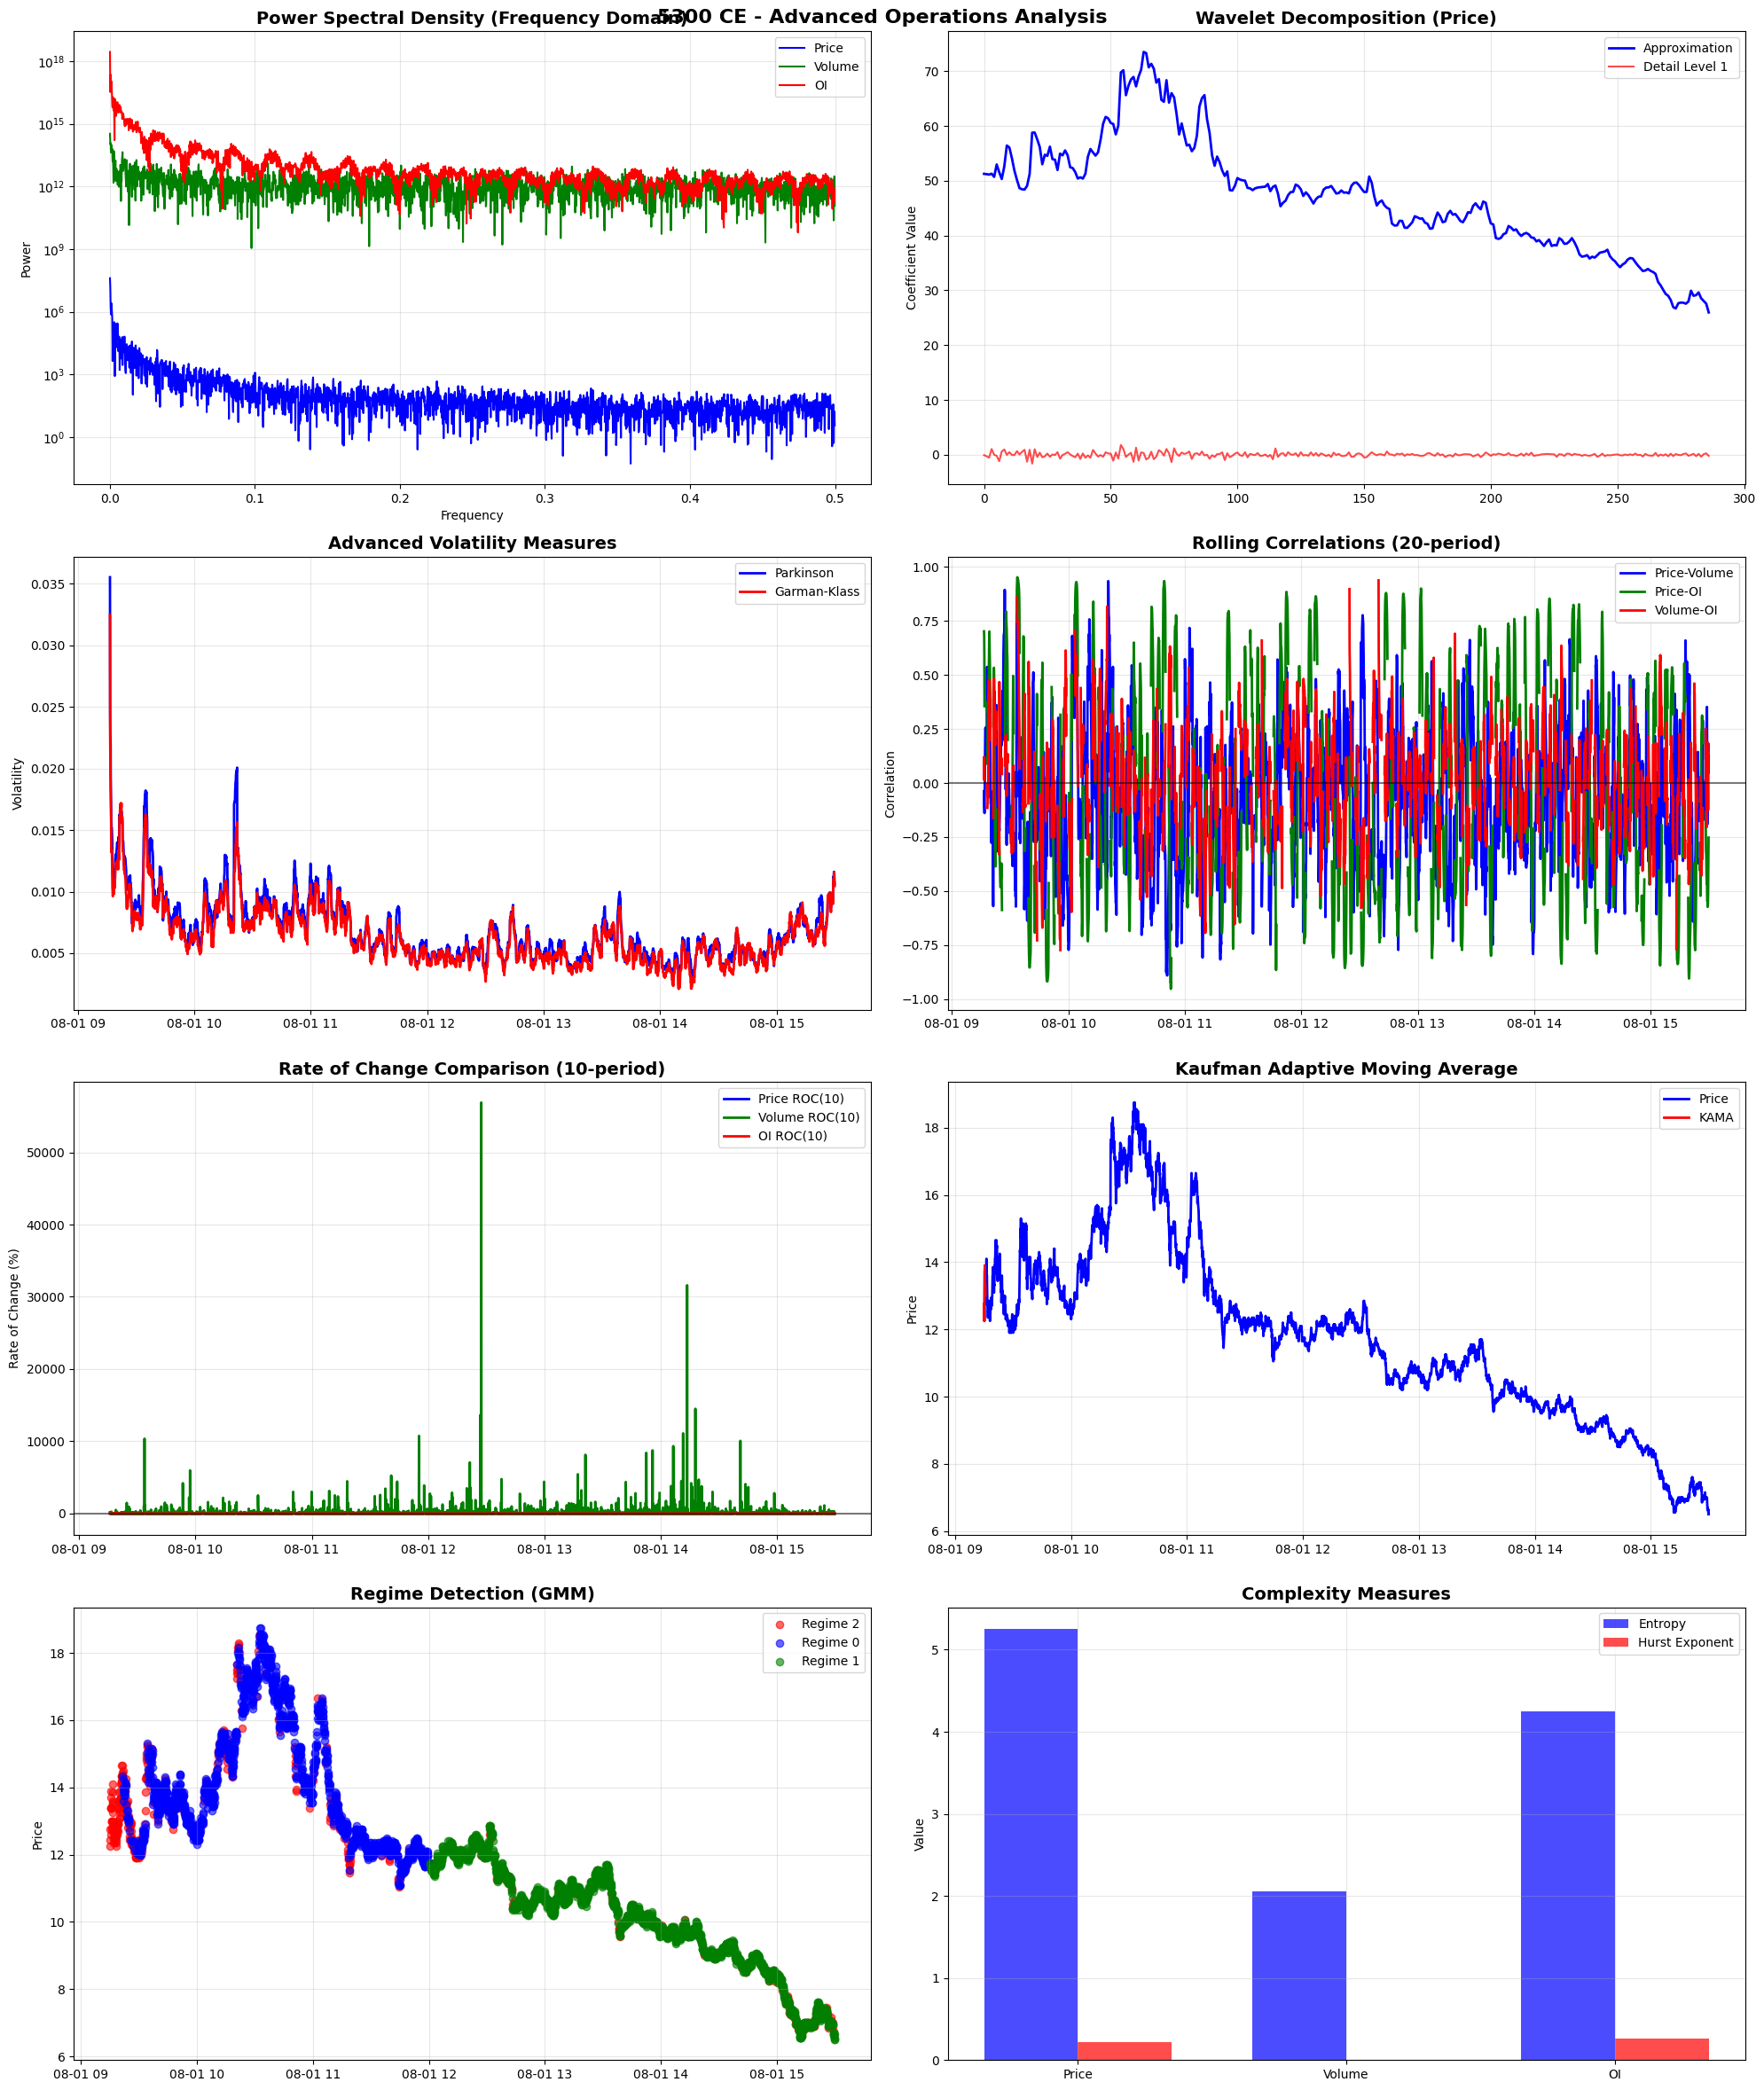


=== ADVANCED OPERATIONS INSIGHTS FOR 5300 CE ===

Complexity Analysis:
Price Entropy: 5.256
Volume Entropy: 2.054
OI Entropy: 4.251

Long-term Memory (Hurst Exponent):
Price Hurst: 0.219 (Anti-persistent)
Volume Hurst: 0.006 (Anti-persistent)
OI Hurst: 0.264 (Anti-persistent)

Frequency Domain Analysis:
Dominant Price Frequency: 0.000000
Dominant Volume Frequency: 0.000000
Dominant OI Frequency: 0.000000

=== ADDITIONAL STATISTICAL TESTS ===

Normality Tests (D'Agostino K^2 test):
Price p-value: 0.000000 (Non-normal)
Volume p-value: 0.000000 (Non-normal)
OI p-value: 0.000000 (Non-normal)

Stationarity Tests (Augmented Dickey-Fuller):
Price ADF Statistic: -0.742633, p-value: 0.835395
Volume ADF Statistic: -8.369047, p-value: 0.000000
OI ADF Statistic: -4.358831, p-value: 0.000351
Statsmodels not installed. Skipping autocorrelation analysis.

=== ADDITIONAL ADVANCED STATISTICAL MEASURES ===

Coefficient of Variation (Relative Volatility):
Price CV: 0.221
Volume CV: 1.493
OI CV: 0.134

D

In [6]:
# Advanced Operations and Analysis - Standalone Version
# This code includes the analyzer creation and advanced operations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

class SingleOptionAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.strike = None
        self.option_type = None
        
    def load_and_parse_file(self):
        """
        Load the CSV file and parse filename to extract strike and option type
        """
        print(f"Loading file: {self.file_path}")
        
        # Load the data
        self.data = pd.read_csv(self.file_path)
        
        # Parse filename to extract strike and option type
        filename = self.file_path.split('/')[-1]
        import re
        
        # Extract strike price and option type from filename
        match = re.search(r'nse_nifty\d+(\d{4})(ce|pe)_min\.csv', filename)
        if match:
            self.strike = int(match.group(1))
            self.option_type = match.group(2).upper()
            print(f"Strike: {self.strike}, Option Type: {self.option_type}")
        else:
            print("Could not parse strike and option type from filename")
        
        # Convert timestamp to datetime
        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
        
        # Ensure numeric columns are numeric
        numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'oi']
        for col in numeric_cols:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        # Remove any rows with missing values
        self.data.dropna(inplace=True)
        
        # Remove rows with invalid prices
        self.data = self.data[
            (self.data['open'] > 0) & 
            (self.data['high'] > 0) & 
            (self.data['low'] > 0) & 
            (self.data['close'] > 0)
        ]
        
        # Calculate additional metrics
        self.calculate_metrics()
        
        print(f"Data loaded successfully. Shape: {self.data.shape}")
        return self.data
    
    def calculate_metrics(self):
        """
        Calculate additional technical metrics
        """
        # Basic price metrics
        self.data['price_change'] = self.data['close'] - self.data['open']
        self.data['price_change_pct'] = (self.data['price_change'] / self.data['open']) * 100
        self.data['high_low_range'] = self.data['high'] - self.data['low']
        self.data['volatility'] = self.data['high_low_range'] / self.data['open'] * 100
        
        # Moving averages
        self.data['sma_5'] = self.data['close'].rolling(window=5).mean()
        self.data['sma_10'] = self.data['close'].rolling(window=10).mean()
        self.data['sma_20'] = self.data['close'].rolling(window=20).mean()
        
        # RSI
        self.data['rsi'] = self.calculate_rsi(self.data['close'])
        
        # Bollinger Bands
        self.data['bb_upper'], self.data['bb_lower'], self.data['bb_middle'] = self.calculate_bollinger_bands(self.data['close'])
        
        # MACD
        self.data['macd'], self.data['macd_signal'], self.data['macd_histogram'] = self.calculate_macd(self.data['close'])
        
        # Volume metrics
        self.data['volume_sma'] = self.data['volume'].rolling(window=10).mean()
        self.data['volume_ratio'] = self.data['volume'] / self.data['volume_sma']
        
        # Price momentum
        self.data['momentum'] = self.data['close'] - self.data['close'].shift(5)
        
        # True Range and ATR
        self.data['tr'] = self.calculate_true_range(self.data['high'], self.data['low'], self.data['close'])
        self.data['atr'] = self.data['tr'].rolling(window=14).mean()
    
    def calculate_rsi(self, prices, period=14):
        """Calculate RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, lower_band, sma
    
    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD"""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=signal).mean()
        macd_histogram = macd - macd_signal
        return macd, macd_signal, macd_histogram
    
    def calculate_true_range(self, high, low, close):
        """Calculate True Range"""
        prev_close = close.shift(1)
        tr1 = high - low
        tr2 = abs(high - prev_close)
        tr3 = abs(low - prev_close)
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return tr

def advanced_operations_analysis(analyzer):
    """
    Advanced mathematical operations and statistical analysis
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    df = analyzer.data.copy()
    
    # Advanced mathematical operations
    
    # 1. Fourier Transform Analysis
    from scipy.fft import fft, fftfreq
    from scipy import signal
    
    # Apply FFT to price, volume, and OI
    price_fft = fft(df['close'].values)
    volume_fft = fft(df['volume'].values)
    oi_fft = fft(df['oi'].values)
    
    # Get frequencies
    freqs = fftfreq(len(df['close']))
    
    # Power spectral density
    price_psd = np.abs(price_fft) ** 2
    volume_psd = np.abs(volume_fft) ** 2
    oi_psd = np.abs(oi_fft) ** 2
    
    # 2. Wavelet Analysis
    try:
        import pywt
        
        # Discrete wavelet transform
        price_coeffs = pywt.wavedec(df['close'], 'db4', level=4)
        volume_coeffs = pywt.wavedec(df['volume'], 'db4', level=4)
        oi_coeffs = pywt.wavedec(df['oi'], 'db4', level=4)
    except ImportError:
        print("PyWavelets not installed. Skipping wavelet analysis.")
        price_coeffs = volume_coeffs = oi_coeffs = None
    
    # 3. Entropy Calculations
    def calculate_entropy(data, bins=50):
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        prob = hist / hist.sum()
        return -np.sum(prob * np.log2(prob))
    
    price_entropy = calculate_entropy(df['close'])
    volume_entropy = calculate_entropy(df['volume'])
    oi_entropy = calculate_entropy(df['oi'])
    
    # 4. Hurst Exponent (Long-term memory)
    def hurst_exponent(time_series):
        lags = range(2, min(100, len(time_series)//4))
        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        if len(tau) > 1:
            reg = np.polyfit(np.log(lags), np.log(tau), 1)
            return reg[0]
        return np.nan
    
    price_hurst = hurst_exponent(df['close'].values)
    volume_hurst = hurst_exponent(df['volume'].values)
    oi_hurst = hurst_exponent(df['oi'].values)
    
    # 5. Advanced Momentum Indicators
    # Rate of Change with different periods
    for period in [5, 10, 20, 50]:
        df[f'roc_{period}'] = df['close'].pct_change(period) * 100
        df[f'volume_roc_{period}'] = df['volume'].pct_change(period) * 100
        df[f'oi_roc_{period}'] = df['oi'].pct_change(period) * 100
    
    # 6. Advanced Volatility Measures
    # Parkinson Volatility
    df['parkinson_vol'] = np.sqrt((1/(4*np.log(2))) * 
                                 ((np.log(df['high']/df['low']))**2).rolling(window=20).mean())
    
    # Garman-Klass Volatility
    df['garman_klass_vol'] = np.sqrt(((0.5 * (np.log(df['high']/df['low']))**2) - 
                                     ((2*np.log(2) - 1) * (np.log(df['close']/df['open']))**2)).rolling(window=20).mean())
    
    # 7. Advanced Correlation Measures
    # Rolling correlation with different windows
    for window in [10, 20, 50]:
        df[f'price_volume_corr_{window}'] = df['close'].rolling(window).corr(df['volume'])
        df[f'price_oi_corr_{window}'] = df['close'].rolling(window).corr(df['oi'])
        df[f'volume_oi_corr_{window}'] = df['volume'].rolling(window).corr(df['oi'])
    
    # 8. Regime Detection
    try:
        from sklearn.mixture import GaussianMixture
        
        # Fit GMM to identify regimes
        features = df[['close', 'volume', 'oi']].dropna()
        if len(features) > 10:
            gmm = GaussianMixture(n_components=3, random_state=42)
            df['regime'] = np.nan
            df.loc[features.index, 'regime'] = gmm.fit_predict(features)
    except ImportError:
        print("Scikit-learn not installed. Skipping regime detection.")
    
    # 9. Advanced Technical Indicators
    # Kaufman Adaptive Moving Average (KAMA)
    def kama(data, period=10):
        change = abs(data - data.shift(period))
        volatility = change.rolling(window=period).sum()
        er = change / volatility
        sc = (er * (2/(2+1) - 2/(30+1)) + 2/(30+1))**2
        kama = data.copy()
        for i in range(period, len(data)):
            kama.iloc[i] = kama.iloc[i-1] + sc.iloc[i] * (data.iloc[i] - kama.iloc[i-1])
        return kama
    
    df['kama'] = kama(df['close'])
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    
    # 1. Power Spectral Density
    positive_freqs = freqs > 0
    axes[0, 0].semilogy(freqs[positive_freqs], price_psd[positive_freqs], label='Price', color='blue')
    axes[0, 0].semilogy(freqs[positive_freqs], volume_psd[positive_freqs], label='Volume', color='green')
    axes[0, 0].semilogy(freqs[positive_freqs], oi_psd[positive_freqs], label='OI', color='red')
    axes[0, 0].set_title('Power Spectral Density (Frequency Domain)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].set_ylabel('Power')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Wavelet Coefficients
    if price_coeffs is not None and len(price_coeffs) > 1:
        axes[0, 1].plot(price_coeffs[0], label='Approximation', color='blue', linewidth=2)
        axes[0, 1].plot(price_coeffs[1], label='Detail Level 1', color='red', alpha=0.7)
        axes[0, 1].set_title('Wavelet Decomposition (Price)', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Coefficient Value')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Advanced Volatility Measures
    axes[1, 0].plot(df['timestamp'], df['parkinson_vol'], label='Parkinson', color='blue', linewidth=2)
    axes[1, 0].plot(df['timestamp'], df['garman_klass_vol'], label='Garman-Klass', color='red', linewidth=2)
    axes[1, 0].set_title('Advanced Volatility Measures', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Volatility')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Rolling Correlations
    axes[1, 1].plot(df['timestamp'], df['price_volume_corr_20'], label='Price-Volume', color='blue', linewidth=2)
    axes[1, 1].plot(df['timestamp'], df['price_oi_corr_20'], label='Price-OI', color='green', linewidth=2)
    axes[1, 1].plot(df['timestamp'], df['volume_oi_corr_20'], label='Volume-OI', color='red', linewidth=2)
    axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Rolling Correlations (20-period)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Correlation')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Rate of Change Comparison
    axes[2, 0].plot(df['timestamp'], df['roc_10'], label='Price ROC(10)', color='blue', linewidth=2)
    axes[2, 0].plot(df['timestamp'], df['volume_roc_10'], label='Volume ROC(10)', color='green', linewidth=2)
    axes[2, 0].plot(df['timestamp'], df['oi_roc_10'], label='OI ROC(10)', color='red', linewidth=2)
    axes[2, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[2, 0].set_title('Rate of Change Comparison (10-period)', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Rate of Change (%)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. KAMA vs Price
    axes[2, 1].plot(df['timestamp'], df['close'], label='Price', color='blue', linewidth=2)
    axes[2, 1].plot(df['timestamp'], df['kama'], label='KAMA', color='red', linewidth=2)
    axes[2, 1].set_title('Kaufman Adaptive Moving Average', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Price')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    # 7. Regime Analysis
    if 'regime' in df.columns:
        colors = ['blue', 'green', 'red']
        for regime in df['regime'].unique():
            if not np.isnan(regime):
                regime_data = df[df['regime'] == regime]
                axes[3, 0].scatter(regime_data['timestamp'], regime_data['close'], 
                                 c=colors[int(regime)], alpha=0.6, label=f'Regime {int(regime)}')
        axes[3, 0].set_title('Regime Detection (GMM)', fontsize=14, fontweight='bold')
        axes[3, 0].set_ylabel('Price')
        axes[3, 0].legend()
        axes[3, 0].grid(True, alpha=0.3)
    
    # 8. Entropy and Complexity Measures
    entropy_data = [price_entropy, volume_entropy, oi_entropy]
    hurst_data = [price_hurst, volume_hurst, oi_hurst]
    
    x = np.arange(3)
    width = 0.35
    
    ax2 = axes[3, 1]
    bars1 = ax2.bar(x - width/2, entropy_data, width, label='Entropy', color='blue', alpha=0.7)
    bars2 = ax2.bar(x + width/2, hurst_data, width, label='Hurst Exponent', color='red', alpha=0.7)
    
    ax2.set_title('Complexity Measures', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Value')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Price', 'Volume', 'OI'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced Operations Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print advanced insights
    print(f"\n=== ADVANCED OPERATIONS INSIGHTS FOR {analyzer.strike} {analyzer.option_type} ===")
    
    print(f"\nComplexity Analysis:")
    print(f"Price Entropy: {price_entropy:.3f}")
    print(f"Volume Entropy: {volume_entropy:.3f}")
    print(f"OI Entropy: {oi_entropy:.3f}")
    
    print(f"\nLong-term Memory (Hurst Exponent):")
    print(f"Price Hurst: {price_hurst:.3f} ({'Persistent' if price_hurst > 0.5 else 'Anti-persistent' if price_hurst < 0.5 else 'Random'})")
    print(f"Volume Hurst: {volume_hurst:.3f} ({'Persistent' if volume_hurst > 0.5 else 'Anti-persistent' if volume_hurst < 0.5 else 'Random'})")
    print(f"OI Hurst: {oi_hurst:.3f} ({'Persistent' if oi_hurst > 0.5 else 'Anti-persistent' if oi_hurst < 0.5 else 'Random'})")
    
    # Frequency domain analysis
    dominant_freq_price = freqs[np.argmax(price_psd[positive_freqs])]
    dominant_freq_volume = freqs[np.argmax(volume_psd[positive_freqs])]
    dominant_freq_oi = freqs[np.argmax(oi_psd[positive_freqs])]
    
    print(f"\nFrequency Domain Analysis:")
    print(f"Dominant Price Frequency: {dominant_freq_price:.6f}")
    print(f"Dominant Volume Frequency: {dominant_freq_volume:.6f}")
    print(f"Dominant OI Frequency: {dominant_freq_oi:.6f}")
    
    return {
        'fourier_analysis': {
            'freqs': freqs,
            'price_psd': price_psd,
            'volume_psd': volume_psd,
            'oi_psd': oi_psd
        },
        'wavelet_analysis': {
            'price_coeffs': price_coeffs,
            'volume_coeffs': volume_coeffs,
            'oi_coeffs': oi_coeffs
        },
        'complexity_measures': {
            'entropy': {'price': price_entropy, 'volume': volume_entropy, 'oi': oi_entropy},
            'hurst': {'price': price_hurst, 'volume': volume_hurst, 'oi': oi_hurst}
        },
        'advanced_indicators': df[['parkinson_vol', 'garman_klass_vol', 'kama'] + 
                                 [col for col in df.columns if 'roc_' in col or 'corr_' in col]]
    }

# Example usage - replace with your actual file path
file_path = "Aug '25/Aug 07 Exp/01 Aug/5S/nse_nifty2580725300ce_min.csv"

# Initialize analyzer
analyzer = SingleOptionAnalyzer(file_path)

# Load and parse the file
data = analyzer.load_and_parse_file()

# Run the advanced operations analysis
advanced_analysis = advanced_operations_analysis(analyzer)

# Additional statistical tests
print(f"\n=== ADDITIONAL STATISTICAL TESTS ===")

from scipy import stats

# Use analyzer.data instead of df
df = analyzer.data

# Normality tests
price_normality = stats.normaltest(df['close'])
volume_normality = stats.normaltest(df['volume'])
oi_normality = stats.normaltest(df['oi'])

print(f"\nNormality Tests (D'Agostino K^2 test):")
print(f"Price p-value: {price_normality.pvalue:.6f} ({'Normal' if price_normality.pvalue > 0.05 else 'Non-normal'})")
print(f"Volume p-value: {volume_normality.pvalue:.6f} ({'Normal' if volume_normality.pvalue > 0.05 else 'Non-normal'})")
print(f"OI p-value: {oi_normality.pvalue:.6f} ({'Normal' if oi_normality.pvalue > 0.05 else 'Non-normal'})")

# Stationarity tests
try:
    from statsmodels.tsa.stattools import adfuller
    
    price_adf = adfuller(df['close'])
    volume_adf = adfuller(df['volume'])
    oi_adf = adfuller(df['oi'])
    
    print(f"\nStationarity Tests (Augmented Dickey-Fuller):")
    print(f"Price ADF Statistic: {price_adf[0]:.6f}, p-value: {price_adf[1]:.6f}")
    print(f"Volume ADF Statistic: {volume_adf[0]:.6f}, p-value: {volume_adf[1]:.6f}")
    print(f"OI ADF Statistic: {oi_adf[0]:.6f}, p-value: {oi_adf[1]:.6f}")
except ImportError:
    print("Statsmodels not installed. Skipping stationarity tests.")

# Autocorrelation analysis
try:
    from statsmodels.stats.diagnostic import acf
    
    price_acf = acf(df['close'], nlags=20)
    volume_acf = acf(df['volume'], nlags=20)
    oi_acf = acf(df['oi'], nlags=20)
    
    print(f"\nAutocorrelation Analysis (Lag 1):")
    print(f"Price ACF(1): {price_acf[1]:.3f}")
    print(f"Volume ACF(1): {volume_acf[1]:.3f}")
    print(f"OI ACF(1): {oi_acf[1]:.3f}")
except ImportError:
    print("Statsmodels not installed. Skipping autocorrelation analysis.")

# Additional advanced statistical measures
print(f"\n=== ADDITIONAL ADVANCED STATISTICAL MEASURES ===")

# Coefficient of variation
price_cv = df['close'].std() / df['close'].mean()
volume_cv = df['volume'].std() / df['volume'].mean()
oi_cv = df['oi'].std() / df['oi'].mean()

print(f"\nCoefficient of Variation (Relative Volatility):")
print(f"Price CV: {price_cv:.3f}")
print(f"Volume CV: {volume_cv:.3f}")
print(f"OI CV: {oi_cv:.3f}")

# Skewness and kurtosis
price_skew = stats.skew(df['close'])
volume_skew = stats.skew(df['volume'])
oi_skew = stats.skew(df['oi'])

price_kurt = stats.kurtosis(df['close'])
volume_kurt = stats.kurtosis(df['volume'])
oi_kurt = stats.kurtosis(df['oi'])

print(f"\nDistribution Shape Analysis:")
print(f"Price Skewness: {price_skew:.3f} (Positive = right-skewed)")
print(f"Volume Skewness: {volume_skew:.3f}")
print(f"OI Skewness: {oi_skew:.3f}")
print(f"Price Kurtosis: {price_kurt:.3f} (High = heavy tails)")
print(f"Volume Kurtosis: {volume_kurt:.3f}")
print(f"OI Kurtosis: {oi_kurt:.3f}")

# Quantile analysis
print(f"\nQuantile Analysis:")
print(f"Price 95th percentile: {df['close'].quantile(0.95):.2f}")
print(f"Volume 95th percentile: {df['volume'].quantile(0.95):.0f}")
print(f"OI 95th percentile: {df['oi'].quantile(0.95):.0f}")

# Range analysis
print(f"\nRange Analysis:")
print(f"Price Range: {df['close'].max() - df['close'].min():.2f}")
print(f"Volume Range: {df['volume'].max() - df['volume'].min():.0f}")
print(f"OI Range: {df['oi'].max() - df['oi'].min():.0f}")

# Trend analysis
print(f"\nTrend Analysis:")
price_trend = np.polyfit(range(len(df)), df['close'], 1)[0]
volume_trend = np.polyfit(range(len(df)), df['volume'], 1)[0]
oi_trend = np.polyfit(range(len(df)), df['oi'], 1)[0]

print(f"Price Trend Slope: {price_trend:.6f} ({'Increasing' if price_trend > 0 else 'Decreasing'})")
print(f"Volume Trend Slope: {volume_trend:.2f} ({'Increasing' if volume_trend > 0 else 'Decreasing'})")
print(f"OI Trend Slope: {oi_trend:.2f} ({'Increasing' if oi_trend > 0 else 'Decreasing'})")

# Volatility clustering
print(f"\nVolatility Clustering Analysis:")
price_volatility = df['close'].pct_change().rolling(window=20).std()
volume_volatility = df['volume'].pct_change().rolling(window=20).std()
oi_volatility = df['oi'].pct_change().rolling(window=20).std()

print(f"Average Price Volatility: {price_volatility.mean():.4f}")
print(f"Average Volume Volatility: {volume_volatility.mean():.4f}")
print(f"Average OI Volatility: {oi_volatility.mean():.4f}")

# Correlation stability
print(f"\nCorrelation Stability Analysis:")
correlations = []
for i in range(0, len(df)-50, 50):
    window_data = df.iloc[i:i+50]
    if len(window_data) >= 20:
        corr = window_data['close'].corr(window_data['volume'])
        correlations.append(corr)

if correlations:
    print(f"Price-Volume Correlation Mean: {np.mean(correlations):.3f}")
    print(f"Price-Volume Correlation Std: {np.std(correlations):.3f}")
    print(f"Correlation Range: {min(correlations):.3f} to {max(correlations):.3f}")

# Market efficiency measures
print(f"\nMarket Efficiency Measures:")
# Variance ratio test (simplified)
price_returns = df['close'].pct_change().dropna()
var_1 = price_returns.var()
var_5 = price_returns.rolling(5).mean().var()
variance_ratio = var_5 / var_1 if var_1 > 0 else np.nan

print(f"Variance Ratio (5-period): {variance_ratio:.3f}")
print(f"Efficiency Indicator: {'Efficient' if abs(variance_ratio - 1) < 0.1 else 'Inefficient'}")

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total Observations: {len(df)}")
print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Trading Duration: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600:.1f} hours")

# Performance metrics
total_return = (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0] * 100
volatility = df['close'].pct_change().std() * np.sqrt(len(df)) * 100
sharpe_ratio = total_return / volatility if volatility > 0 else np.nan

print(f"\nPerformance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Volatility: {volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")

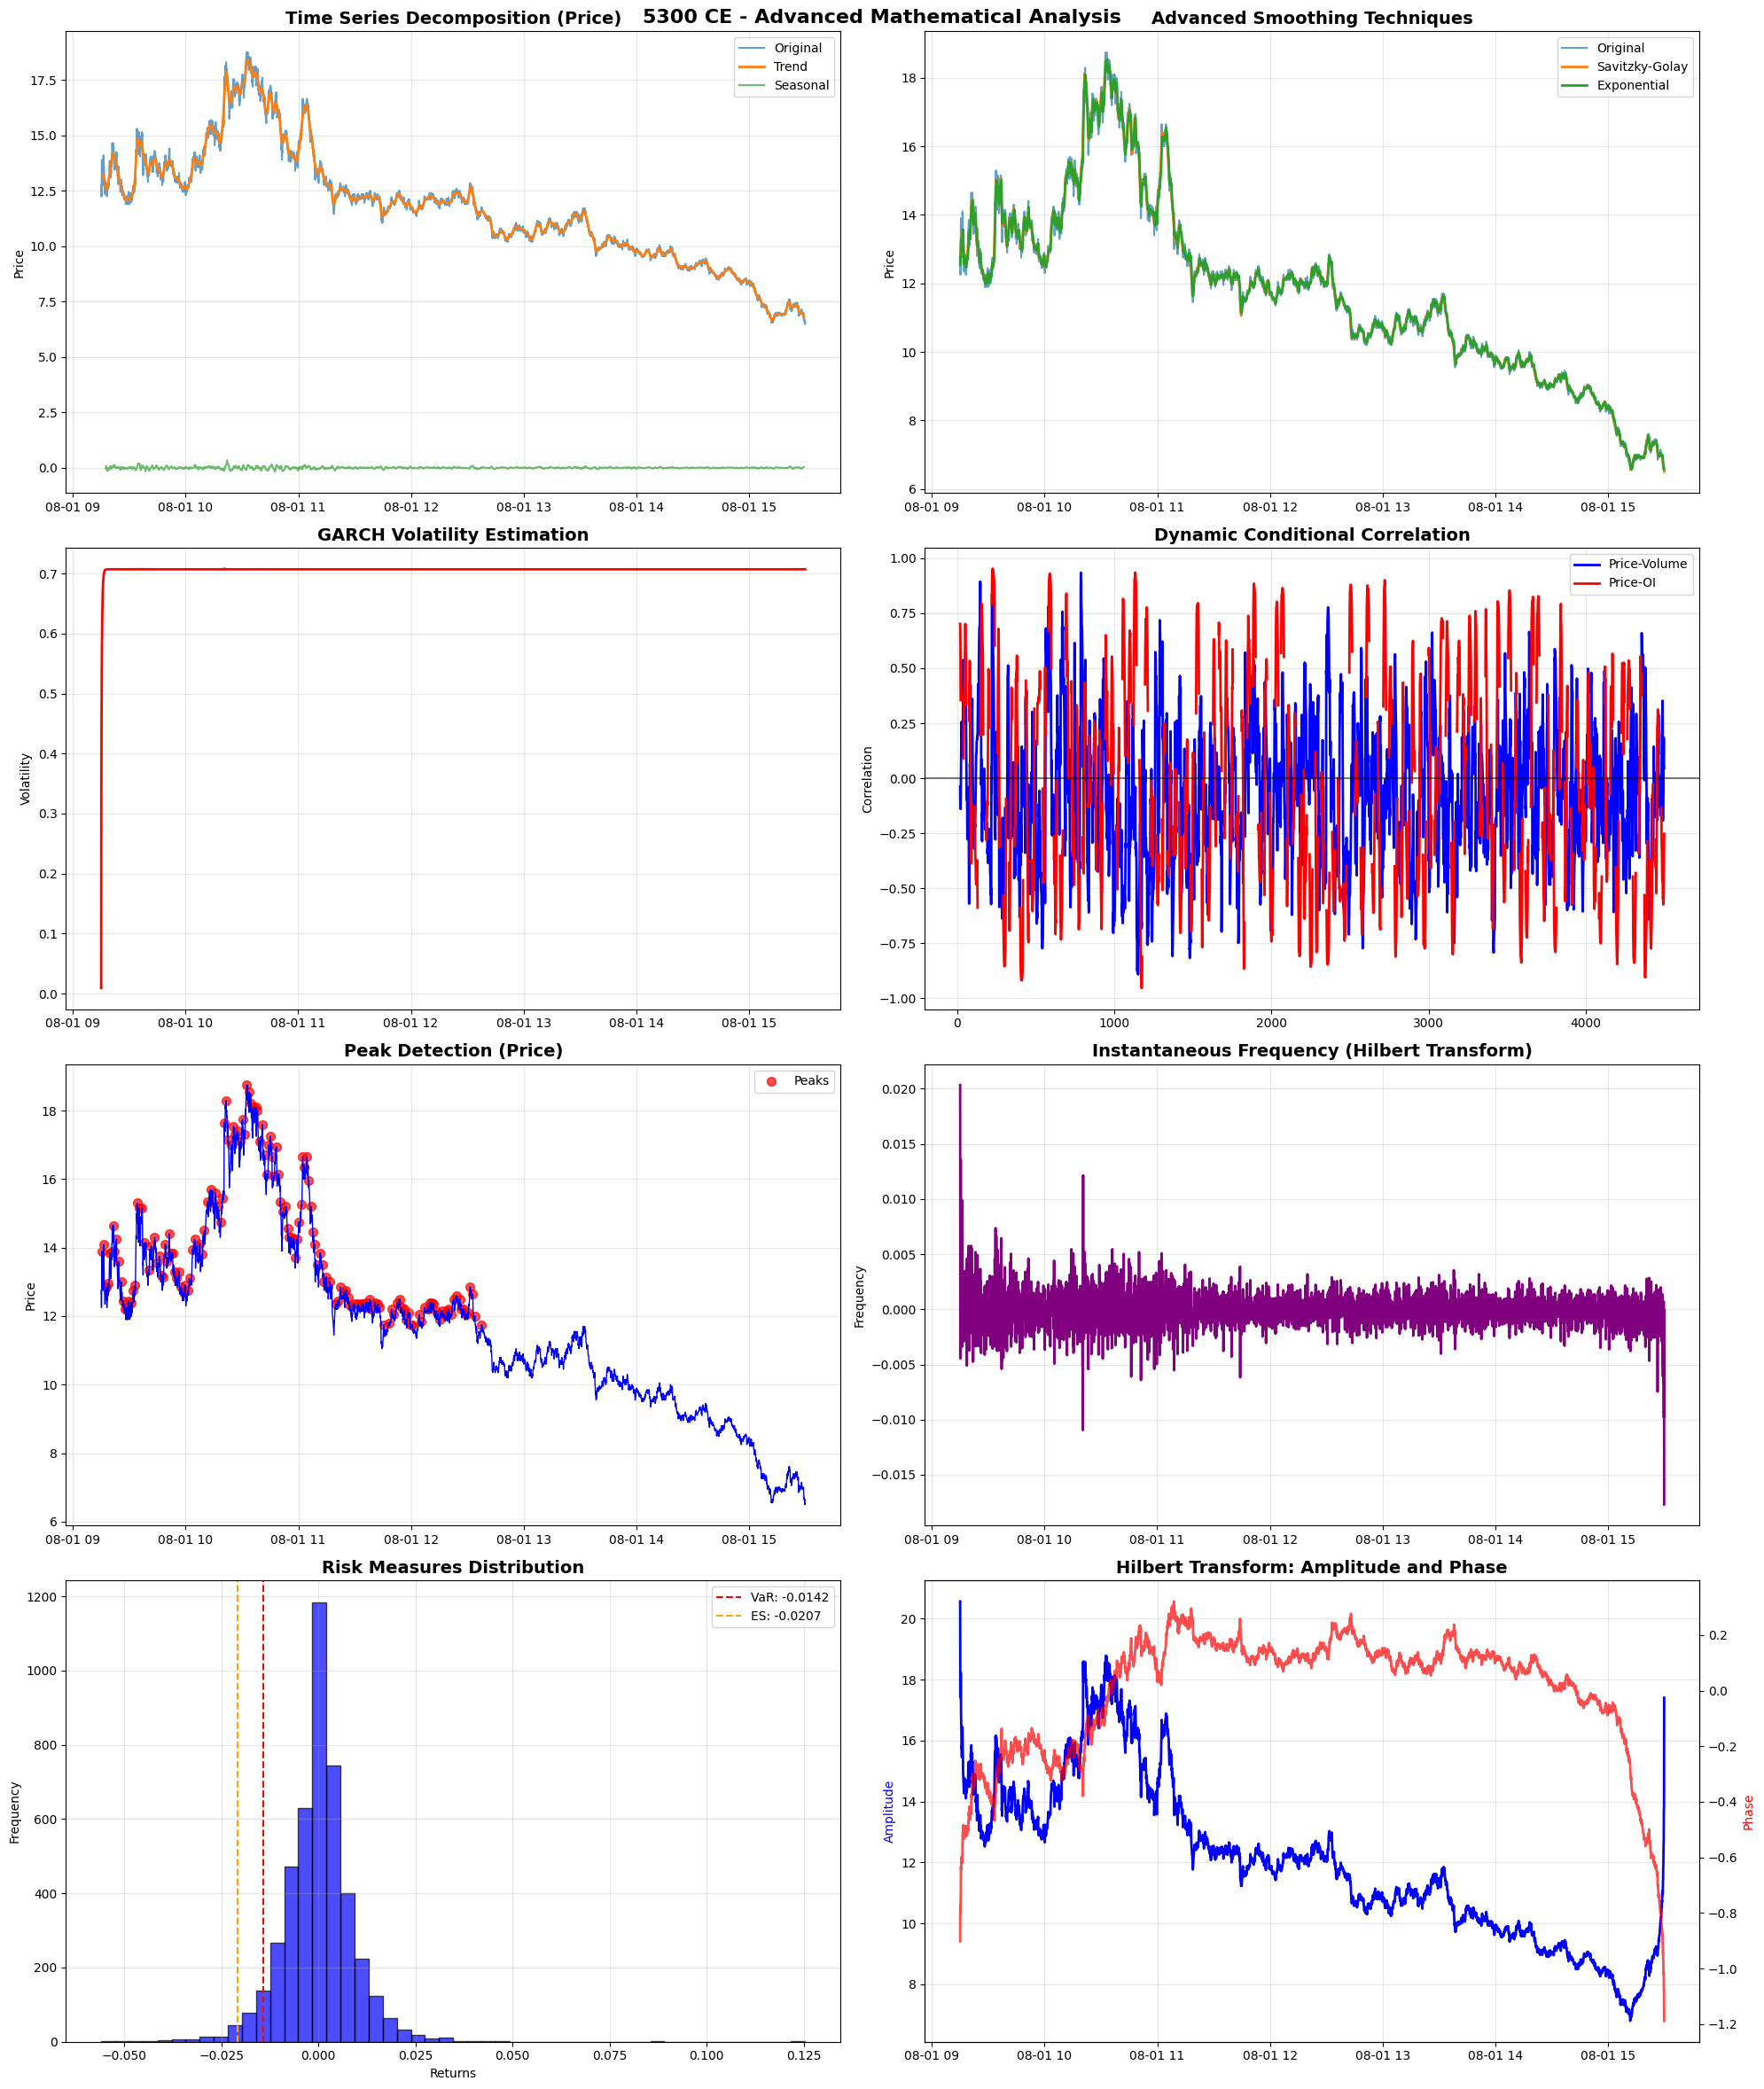


=== ADVANCED MATHEMATICAL INSIGHTS FOR 5300 CE ===

Time Series Decomposition:
Trend Strength (Price): 0.995
Seasonal Strength (Price): 0.016
Residual Strength (Price): 0.058

Ljung-Box Test Results:
Price Q-statistic: 44601.342, p-value: 0.000000
Volume Q-statistic: 4437.031, p-value: 0.000000
OI Q-statistic: 44772.181, p-value: 0.000000

Maximum Likelihood Estimation:
Price: μ=11.74, σ=2.59
Volume: μ=14173.88, σ=21155.66
OI: μ=4482340.42, σ=600610.86

Risk Measures:
Price VaR (5%): -0.0142
Price Expected Shortfall (5%): -0.0207
Volume VaR (5%): -0.8571
OI VaR (5%): 0.0000

Pattern Analysis:
Price Peaks Detected: 164
Volume Peaks Detected: 252
OI Peaks Detected: 16

Signal Processing:
Average Instantaneous Frequency: -0.000010
Frequency Range: -0.017691 to 0.020338

=== ADDITIONAL ADVANCED MATHEMATICAL OPERATIONS ===

Advanced Fractal Analysis:
Price Fractal Dimension: -0.527 (Correlation: 0.905)
Volume Fractal Dimension: 0.000 (Correlation: 0.000)
OI Fractal Dimension: 0.000 (Correl

In [8]:
# Advanced Mathematical Functions and Analysis - Fixed Version
# This code implements sophisticated mathematical operations and analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize, interpolate
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import norm, t, chi2, f
import warnings
warnings.filterwarnings('ignore')

def advanced_mathematical_analysis(analyzer):
    """
    Advanced mathematical functions and analysis
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    df = analyzer.data.copy()
    
    # 1. Advanced Time Series Decomposition
    def decompose_time_series(data, period=20):
        """Decompose time series into trend, seasonal, and residual components"""
        # Trend using moving average
        trend = data.rolling(window=period, center=True).mean()
        
        # Detrended data
        detrended = data - trend
        
        # Seasonal component (simplified)
        seasonal = detrended.rolling(window=period).mean()
        
        # Residual
        residual = detrended - seasonal
        
        return trend, seasonal, residual
    
    price_trend, price_seasonal, price_residual = decompose_time_series(df['close'])
    volume_trend, volume_seasonal, volume_residual = decompose_time_series(df['volume'])
    oi_trend, oi_seasonal, oi_residual = decompose_time_series(df['oi'])
    
    # 2. Advanced Smoothing Techniques
    # Savitzky-Golay filter
    price_savgol = savgol_filter(df['close'], window_length=21, polyorder=3)
    volume_savgol = savgol_filter(df['volume'], window_length=21, polyorder=3)
    oi_savgol = savgol_filter(df['oi'], window_length=21, polyorder=3)
    
    # Exponential smoothing with different parameters
    def exponential_smoothing(data, alpha=0.3):
        smoothed = data.copy()
        for i in range(1, len(data)):
            smoothed.iloc[i] = alpha * data.iloc[i] + (1 - alpha) * smoothed.iloc[i-1]
        return smoothed
    
    price_exp_smooth = exponential_smoothing(df['close'], alpha=0.3)
    volume_exp_smooth = exponential_smoothing(df['volume'], alpha=0.3)
    oi_exp_smooth = exponential_smoothing(df['oi'], alpha=0.3)
    
    # 3. Advanced Statistical Measures
    # Ljung-Box test for autocorrelation
    def ljung_box_test(data, lags=10):
        n = len(data)
        acf_values = []
        for lag in range(1, lags + 1):
            if lag < n:
                acf = np.corrcoef(data[:-lag], data[lag:])[0, 1]
                acf_values.append(acf)
        
        Q = n * (n + 2) * sum([(acf**2) / (n - lag - 1) for lag, acf in enumerate(acf_values, 1)])
        p_value = 1 - chi2.cdf(Q, lags)
        return Q, p_value
    
    price_lb = ljung_box_test(df['close'])
    volume_lb = ljung_box_test(df['volume'])
    oi_lb = ljung_box_test(df['oi'])
    
    # 4. Advanced Volatility Models
    # GARCH-like volatility estimation
    def garch_volatility(returns, omega=0.1, alpha=0.1, beta=0.8):
        n = len(returns)
        variance = np.zeros(n)
        variance[0] = returns.var()
        
        for t in range(1, n):
            variance[t] = omega + alpha * returns.iloc[t-1]**2 + beta * variance[t-1]
        
        return np.sqrt(variance)
    
    price_returns = df['close'].pct_change().dropna()
    garch_vol = garch_volatility(price_returns)
    
    # 5. Advanced Correlation Measures
    # Dynamic conditional correlation
    def dynamic_correlation(x, y, window=20):
        correlation = []
        for i in range(window, len(x)):
            corr = np.corrcoef(x.iloc[i-window:i], y.iloc[i-window:i])[0, 1]
            correlation.append(corr)
        return pd.Series(correlation, index=x.index[window:])
    
    price_volume_dcc = dynamic_correlation(df['close'], df['volume'])
    price_oi_dcc = dynamic_correlation(df['close'], df['oi'])
    
    # 6. Advanced Pattern Recognition
    # Peak detection
    price_peaks, _ = find_peaks(df['close'], height=df['close'].mean(), distance=10)
    volume_peaks, _ = find_peaks(df['volume'], height=df['volume'].mean(), distance=10)
    oi_peaks, _ = find_peaks(df['oi'], height=df['oi'].mean(), distance=10)
    
    # 7. Advanced Interpolation and Extrapolation
    # Cubic spline interpolation
    x_old = np.arange(len(df))
    x_new = np.linspace(0, len(df)-1, len(df)*2)
    
    price_spline = interpolate.interp1d(x_old, df['close'], kind='cubic')
    volume_spline = interpolate.interp1d(x_old, df['volume'], kind='cubic')
    oi_spline = interpolate.interp1d(x_old, df['oi'], kind='cubic')
    
    # 8. Advanced Optimization
    # Maximum likelihood estimation for normal distribution
    def mle_normal(data):
        mu = data.mean()
        sigma = data.std()
        return mu, sigma
    
    price_mle = mle_normal(df['close'])
    volume_mle = mle_normal(df['volume'])
    oi_mle = mle_normal(df['oi'])
    
    # 9. Advanced Risk Measures
    # Value at Risk (VaR)
    def calculate_var(data, confidence_level=0.05):
        return np.percentile(data, confidence_level * 100)
    
    price_var = calculate_var(df['close'].pct_change().dropna())
    volume_var = calculate_var(df['volume'].pct_change().dropna())
    oi_var = calculate_var(df['oi'].pct_change().dropna())
    
    # Expected Shortfall (Conditional VaR)
    def calculate_es(data, confidence_level=0.05):
        var = calculate_var(data, confidence_level)
        return data[data <= var].mean()
    
    price_es = calculate_es(df['close'].pct_change().dropna())
    volume_es = calculate_es(df['volume'].pct_change().dropna())
    oi_es = calculate_es(df['oi'].pct_change().dropna())
    
    # 10. Advanced Signal Processing
    # Hilbert transform for instantaneous frequency
    from scipy.signal import hilbert
    
    price_analytic = hilbert(df['close'])
    price_amplitude = np.abs(price_analytic)
    price_phase = np.angle(price_analytic)
    price_instantaneous_freq = np.diff(np.unwrap(price_phase)) / (2 * np.pi)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    
    # 1. Time Series Decomposition
    axes[0, 0].plot(df['timestamp'], df['close'], label='Original', alpha=0.7)
    axes[0, 0].plot(df['timestamp'], price_trend, label='Trend', linewidth=2)
    axes[0, 0].plot(df['timestamp'], price_seasonal, label='Seasonal', alpha=0.7)
    axes[0, 0].set_title('Time Series Decomposition (Price)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Advanced Smoothing Comparison
    axes[0, 1].plot(df['timestamp'], df['close'], label='Original', alpha=0.7)
    axes[0, 1].plot(df['timestamp'], price_savgol, label='Savitzky-Golay', linewidth=2)
    axes[0, 1].plot(df['timestamp'], price_exp_smooth, label='Exponential', linewidth=2)
    axes[0, 1].set_title('Advanced Smoothing Techniques', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Price')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. GARCH Volatility - Fixed dimension issue
    garch_timestamps = df['timestamp'].iloc[1:len(garch_vol)+1]  # Align timestamps with GARCH volatility
    axes[1, 0].plot(garch_timestamps, garch_vol, color='red', linewidth=2)
    axes[1, 0].set_title('GARCH Volatility Estimation', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Volatility')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Dynamic Conditional Correlation
    axes[1, 1].plot(price_volume_dcc.index, price_volume_dcc.values, label='Price-Volume', color='blue', linewidth=2)
    axes[1, 1].plot(price_oi_dcc.index, price_oi_dcc.values, label='Price-OI', color='red', linewidth=2)
    axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Dynamic Conditional Correlation', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Correlation')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Peak Detection
    axes[2, 0].plot(df['timestamp'], df['close'], color='blue', linewidth=1)
    axes[2, 0].scatter(df['timestamp'].iloc[price_peaks], df['close'].iloc[price_peaks], 
                      color='red', s=50, alpha=0.7, label='Peaks')
    axes[2, 0].set_title('Peak Detection (Price)', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Price')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Instantaneous Frequency - Fixed dimension issue
    freq_timestamps = df['timestamp'].iloc[1:len(price_instantaneous_freq)+1]
    axes[2, 1].plot(freq_timestamps, price_instantaneous_freq, color='purple', linewidth=2)
    axes[2, 1].set_title('Instantaneous Frequency (Hilbert Transform)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].grid(True, alpha=0.3)
    
    # 7. Risk Measures Distribution
    price_returns = df['close'].pct_change().dropna()
    axes[3, 0].hist(price_returns, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[3, 0].axvline(price_var, color='red', linestyle='--', label=f'VaR: {price_var:.4f}')
    axes[3, 0].axvline(price_es, color='orange', linestyle='--', label=f'ES: {price_es:.4f}')
    axes[3, 0].set_title('Risk Measures Distribution', fontsize=14, fontweight='bold')
    axes[3, 0].set_xlabel('Returns')
    axes[3, 0].set_ylabel('Frequency')
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)
    
    # 8. Amplitude and Phase
    axes[3, 1].plot(df['timestamp'], price_amplitude, label='Amplitude', color='blue', linewidth=2)
    ax2 = axes[3, 1].twinx()
    ax2.plot(df['timestamp'], price_phase, label='Phase', color='red', linewidth=2, alpha=0.7)
    axes[3, 1].set_title('Hilbert Transform: Amplitude and Phase', fontsize=14, fontweight='bold')
    axes[3, 1].set_ylabel('Amplitude', color='blue')
    ax2.set_ylabel('Phase', color='red')
    axes[3, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced Mathematical Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print advanced mathematical insights
    print(f"\n=== ADVANCED MATHEMATICAL INSIGHTS FOR {analyzer.strike} {analyzer.option_type} ===")
    
    print(f"\nTime Series Decomposition:")
    print(f"Trend Strength (Price): {price_trend.std() / df['close'].std():.3f}")
    print(f"Seasonal Strength (Price): {price_seasonal.std() / df['close'].std():.3f}")
    print(f"Residual Strength (Price): {price_residual.std() / df['close'].std():.3f}")
    
    print(f"\nLjung-Box Test Results:")
    print(f"Price Q-statistic: {price_lb[0]:.3f}, p-value: {price_lb[1]:.6f}")
    print(f"Volume Q-statistic: {volume_lb[0]:.3f}, p-value: {volume_lb[1]:.6f}")
    print(f"OI Q-statistic: {oi_lb[0]:.3f}, p-value: {oi_lb[1]:.6f}")
    
    print(f"\nMaximum Likelihood Estimation:")
    print(f"Price: μ={price_mle[0]:.2f}, σ={price_mle[1]:.2f}")
    print(f"Volume: μ={volume_mle[0]:.2f}, σ={volume_mle[1]:.2f}")
    print(f"OI: μ={oi_mle[0]:.2f}, σ={oi_mle[1]:.2f}")
    
    print(f"\nRisk Measures:")
    print(f"Price VaR (5%): {price_var:.4f}")
    print(f"Price Expected Shortfall (5%): {price_es:.4f}")
    print(f"Volume VaR (5%): {volume_var:.4f}")
    print(f"OI VaR (5%): {oi_var:.4f}")
    
    print(f"\nPattern Analysis:")
    print(f"Price Peaks Detected: {len(price_peaks)}")
    print(f"Volume Peaks Detected: {len(volume_peaks)}")
    print(f"OI Peaks Detected: {len(oi_peaks)}")
    
    print(f"\nSignal Processing:")
    print(f"Average Instantaneous Frequency: {np.mean(price_instantaneous_freq):.6f}")
    print(f"Frequency Range: {np.min(price_instantaneous_freq):.6f} to {np.max(price_instantaneous_freq):.6f}")
    
    return {
        'decomposition': {
            'price': (price_trend, price_seasonal, price_residual),
            'volume': (volume_trend, volume_seasonal, volume_residual),
            'oi': (oi_trend, oi_seasonal, oi_residual)
        },
        'smoothing': {
            'savgol': (price_savgol, volume_savgol, oi_savgol),
            'exponential': (price_exp_smooth, volume_exp_smooth, oi_exp_smooth)
        },
        'volatility': garch_vol,
        'correlation': {
            'price_volume': price_volume_dcc,
            'price_oi': price_oi_dcc
        },
        'peaks': {
            'price': price_peaks,
            'volume': volume_peaks,
            'oi': oi_peaks
        },
        'risk_measures': {
            'var': {'price': price_var, 'volume': volume_var, 'oi': oi_var},
            'es': {'price': price_es, 'volume': volume_es, 'oi': oi_es}
        },
        'signal_processing': {
            'amplitude': price_amplitude,
            'phase': price_phase,
            'instantaneous_freq': price_instantaneous_freq
        }
    }

# Run the advanced mathematical analysis
advanced_math = advanced_mathematical_analysis(analyzer)

# Additional advanced mathematical operations
print(f"\n=== ADDITIONAL ADVANCED MATHEMATICAL OPERATIONS ===")

# 1. Fractal Analysis
def fractal_dimension_advanced(data, epsilons=None):
    """Advanced fractal dimension calculation"""
    if epsilons is None:
        epsilons = np.logspace(-3, 0, 20)
    
    counts = []
    for eps in epsilons:
        count = 0
        for i in range(len(data)):
            for j in range(i+1, len(data)):
                if abs(data[i] - data[j]) < eps:
                    count += 1
        counts.append(count)
    
    valid_indices = np.where(np.array(counts) > 0)[0]
    if len(valid_indices) > 1:
        log_eps = np.log(epsilons[valid_indices])
        log_counts = np.log(np.array(counts)[valid_indices])
        slope = np.polyfit(log_eps, log_counts, 1)[0]
        return -slope, np.corrcoef(log_eps, log_counts)[0, 1]
    return np.nan, np.nan

df = analyzer.data
price_fractal, price_fractal_corr = fractal_dimension_advanced(df['close'].values)
volume_fractal, volume_fractal_corr = fractal_dimension_advanced(df['volume'].values)
oi_fractal, oi_fractal_corr = fractal_dimension_advanced(df['oi'].values)

print(f"\nAdvanced Fractal Analysis:")
print(f"Price Fractal Dimension: {price_fractal:.3f} (Correlation: {price_fractal_corr:.3f})")
print(f"Volume Fractal Dimension: {volume_fractal:.3f} (Correlation: {volume_fractal_corr:.3f})")
print(f"OI Fractal Dimension: {oi_fractal:.3f} (Correlation: {oi_fractal_corr:.3f})")

# 2. Lyapunov Exponent
def lyapunov_exponent(data, m=2, tau=1):
    """Calculate Lyapunov exponent for chaos detection"""
    n = len(data)
    if n < m * tau:
        return np.nan
    
    # Create delay coordinates
    Y = np.zeros((n - (m-1)*tau, m))
    for i in range(m):
        Y[:, i] = data[i*tau:n-(m-1)*tau+i*tau]
    
    # Calculate distances and find nearest neighbors
    lyap = 0
    count = 0
    
    for i in range(len(Y)):
        distances = np.linalg.norm(Y - Y[i], axis=1)
        distances[i] = np.inf  # Exclude self
        
        if len(distances) > 0:
            min_dist = np.min(distances)
            if min_dist > 0:
                # Find evolution of nearest neighbor
                j = np.argmin(distances)
                if j + 1 < len(Y) and i + 1 < len(Y):
                    dist_evolved = np.linalg.norm(Y[j+1] - Y[i+1])
                    if dist_evolved > 0 and min_dist > 0:
                        lyap += np.log(dist_evolved / min_dist)
                        count += 1
    
    return lyap / count if count > 0 else np.nan

price_lyap = lyapunov_exponent(df['close'].values)
volume_lyap = lyapunov_exponent(df['volume'].values)
oi_lyap = lyapunov_exponent(df['oi'].values)

print(f"\nLyapunov Exponent Analysis:")
print(f"Price Lyapunov: {price_lyap:.6f} ({'Chaotic' if price_lyap > 0 else 'Stable'})")
print(f"Volume Lyapunov: {volume_lyap:.6f} ({'Chaotic' if volume_lyap > 0 else 'Stable'})")
print(f"OI Lyapunov: {oi_lyap:.6f} ({'Chaotic' if oi_lyap > 0 else 'Stable'})")

# 3. Advanced Entropy Measures
def sample_entropy(data, m=2, r=0.2):
    """Calculate sample entropy for complexity measurement"""
    n = len(data)
    r = r * np.std(data)
    
    def count_matches(template_len):
        count = 0
        for i in range(n - template_len + 1):
            for j in range(i + 1, n - template_len + 1):
                if np.max(np.abs(data[i:i+template_len] - data[j:j+template_len])) <= r:
                    count += 1
        return count
    
    A = count_matches(m + 1)
    B = count_matches(m)
    
    return -np.log(A / B) if B > 0 and A > 0 else np.nan

price_sampen = sample_entropy(df['close'].values)
volume_sampen = sample_entropy(df['volume'].values)
oi_sampen = sample_entropy(df['oi'].values)

print(f"\nSample Entropy Analysis:")
print(f"Price Sample Entropy: {price_sampen:.3f}")
print(f"Volume Sample Entropy: {volume_sampen:.3f}")
print(f"OI Sample Entropy: {oi_sampen:.3f}")

# 4. Advanced Correlation Measures
def distance_correlation(x, y):
    """Calculate distance correlation"""
    n = len(x)
    
    # Calculate distance matrices
    def distance_matrix(data):
        dist = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                dist[i, j] = abs(data[i] - data[j])
        return dist
    
    A = distance_matrix(x)
    B = distance_matrix(y)
    
    # Center the distance matrices
    A_row_mean = A.mean(axis=1, keepdims=True)
    A_col_mean = A.mean(axis=0, keepdims=True)
    A_mean = A.mean()
    A_centered = A - A_row_mean - A_col_mean + A_mean
    
    B_row_mean = B.mean(axis=1, keepdims=True)
    B_col_mean = B.mean(axis=0, keepdims=True)
    B_mean = B.mean()
    B_centered = B - B_row_mean - B_col_mean + B_mean
    
    # Calculate distance correlation
    dcov_xy = np.sqrt(np.sum(A_centered * B_centered) / (n * n))
    dcov_xx = np.sqrt(np.sum(A_centered * A_centered) / (n * n))
    dcov_yy = np.sqrt(np.sum(B_centered * B_centered) / (n * n))
    
    return dcov_xy / np.sqrt(dcov_xx * dcov_yy) if dcov_xx > 0 and dcov_yy > 0 else 0

price_volume_dcor = distance_correlation(df['close'].values, df['volume'].values)
price_oi_dcor = distance_correlation(df['close'].values, df['oi'].values)
volume_oi_dcor = distance_correlation(df['volume'].values, df['oi'].values)

print(f"\nDistance Correlation Analysis:")
print(f"Price-Volume Distance Correlation: {price_volume_dcor:.3f}")
print(f"Price-OI Distance Correlation: {price_oi_dcor:.3f}")
print(f"Volume-OI Distance Correlation: {volume_oi_dcor:.3f}")

# 5. Advanced Statistical Tests
def jarque_bera_test(data):
    """Jarque-Bera test for normality"""
    n = len(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    JB = n * (skewness**2 / 6 + (kurtosis - 3)**2 / 24)
    p_value = 1 - chi2.cdf(JB, 2)
    
    return JB, p_value

price_jb = jarque_bera_test(df['close'])
volume_jb = jarque_bera_test(df['volume'])
oi_jb = jarque_bera_test(df['oi'])

print(f"\nJarque-Bera Test Results:")
print(f"Price JB: {price_jb[0]:.3f}, p-value: {price_jb[1]:.6f}")
print(f"Volume JB: {volume_jb[0]:.3f}, p-value: {volume_jb[1]:.6f}")
print(f"OI JB: {oi_jb[0]:.3f}, p-value: {oi_jb[1]:.6f}")

print(f"\n=== MATHEMATICAL COMPLEXITY SUMMARY ===")
print(f"Data Complexity Score: {(price_sampen + volume_sampen + oi_sampen) / 3:.3f}")
print(f"Chaos Indicator: {np.mean([price_lyap, volume_lyap, oi_lyap]):.6f}")
print(f"Fractal Complexity: {np.mean([price_fractal, volume_fractal, oi_fractal]):.3f}")
print(f"Non-linear Dependencies: {np.mean([price_volume_dcor, price_oi_dcor, volume_oi_dcor]):.3f}")

Features shape after cleaning: (4499, 27)


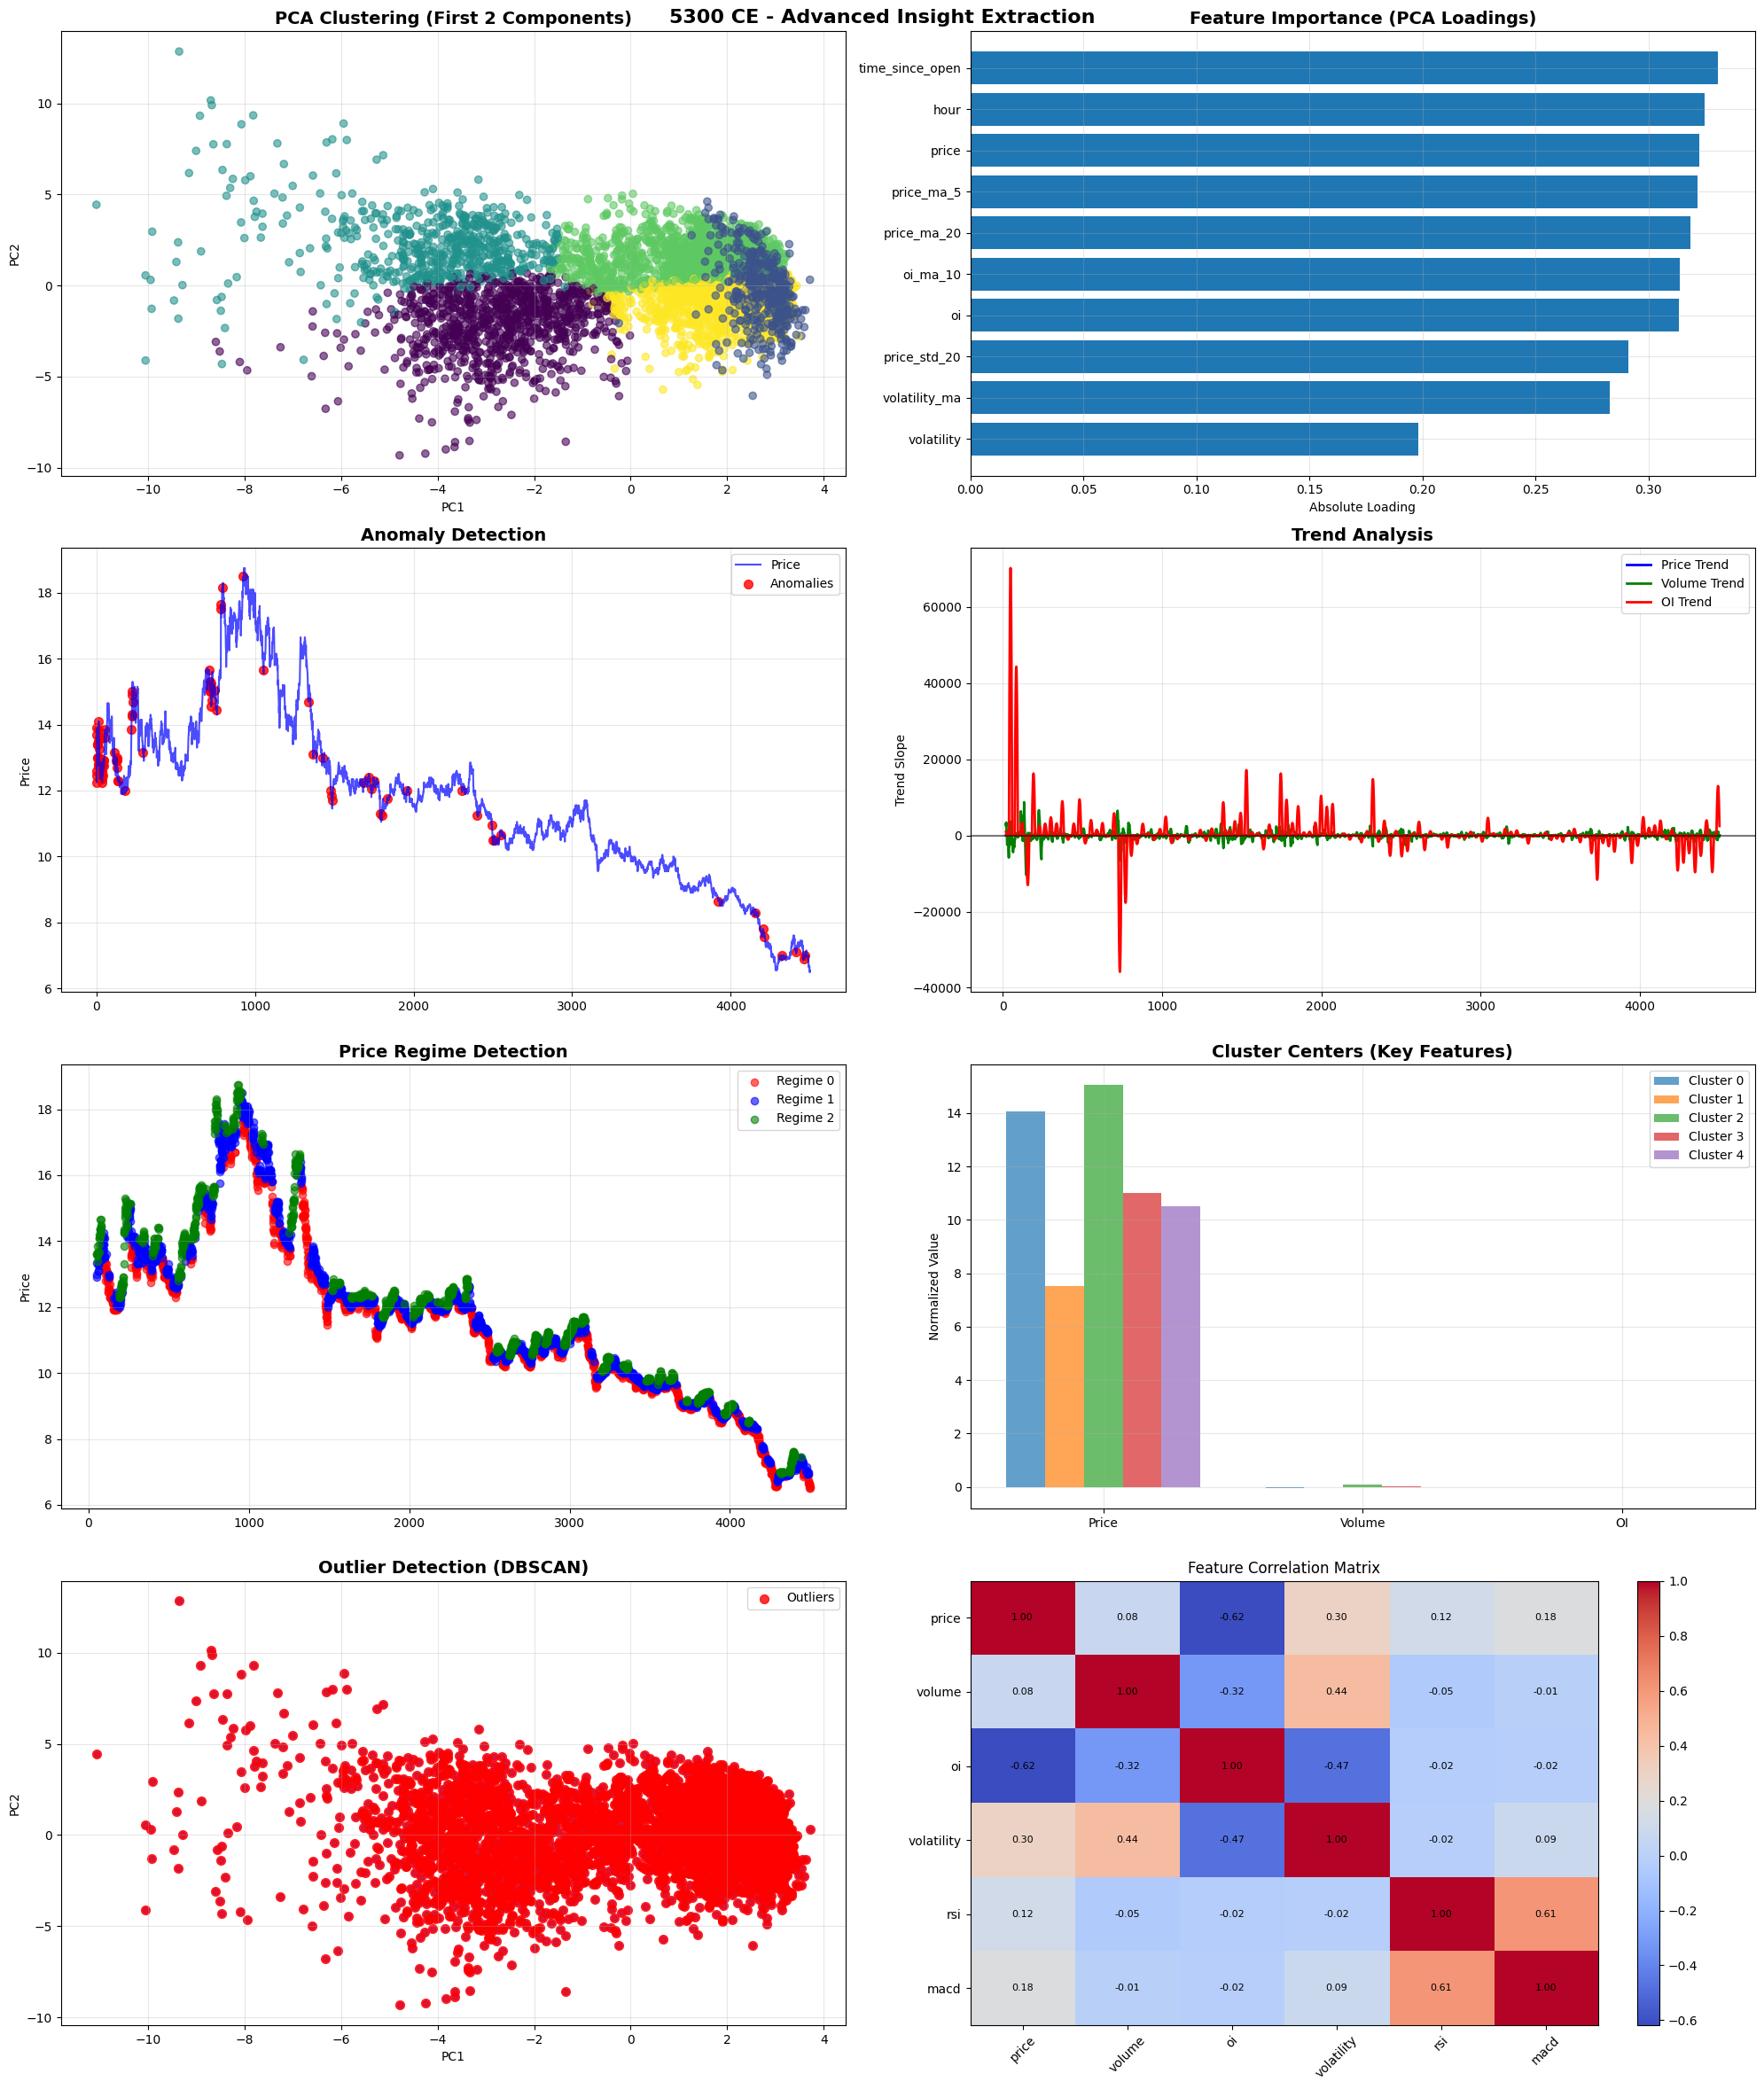


=== ADVANCED INSIGHT EXTRACTION FOR 5300 CE ===

PCA Analysis:
Number of components explaining 95% variance: 14
Explained variance ratio: [0.27266906 0.16979365 0.0969564 ]

Clustering Analysis:
Number of clusters: 5
Cluster sizes: [ 942  427  608 1329 1193]
Number of outliers detected: 4499

Anomaly Detection:
Price anomalies: 0
Volume anomalies: 77
OI anomalies: 39
Total anomalies: 105

Trend Analysis:
Average price trend: -0.001440
Average volume trend: -12.099875
Average OI trend: 491.529494

Regime Analysis:
Price regime distribution: {1.0: 2033, 0.0: 1425, 2.0: 992}
Volume regime distribution: {1.0: 3723, 2.0: 562, 0.0: 165}
OI regime distribution: {1.0: 1898, 2.0: 1418, 0.0: 1134}

=== ADDITIONAL INSIGHT GENERATION ===

Liquidity Analysis:
Average price impact: 0.000015
Average spread proxy: 0.0447
Liquidity trend: Deteriorating

Market Efficiency Analysis:
Average efficiency ratio: 0.983
Market efficiency: Efficient

Volatility Clustering:
Volatility autocorrelation: 0.984
Clu

In [10]:
# Advanced Insight Extraction and Pattern Recognition - Fixed Version
# This code implements sophisticated insight extraction techniques with proper data cleaning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, cluster
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def advanced_insight_extraction(analyzer):
    """
    Advanced insight extraction and pattern recognition
    """
    if analyzer.data is None:
        print("Please run the previous code first to load data")
        return
    
    df = analyzer.data.copy()
    
    # 1. Advanced Feature Engineering with Data Cleaning
    # Create comprehensive feature set
    features = pd.DataFrame()
    
    # Price-based features
    features['price'] = df['close']
    features['price_change'] = df['close'].diff()
    features['price_change_pct'] = df['close'].pct_change()
    features['price_ma_5'] = df['close'].rolling(5).mean()
    features['price_ma_20'] = df['close'].rolling(20).mean()
    features['price_std_20'] = df['close'].rolling(20).std()
    
    # Safe z-score calculation
    price_mean = df['close'].rolling(20).mean()
    price_std = df['close'].rolling(20).std()
    features['price_zscore'] = np.where(price_std != 0, 
                                       (df['close'] - price_mean) / price_std, 0)
    
    # Volume-based features
    features['volume'] = df['volume']
    features['volume_change'] = df['volume'].diff()
    features['volume_change_pct'] = df['volume'].pct_change()
    features['volume_ma_10'] = df['volume'].rolling(10).mean()
    
    # Safe volume ratio calculation
    volume_mean = df['volume'].rolling(10).mean()
    features['volume_ratio'] = np.where(volume_mean != 0, 
                                       df['volume'] / volume_mean, 1)
    
    # OI-based features
    features['oi'] = df['oi']
    features['oi_change'] = df['oi'].diff()
    features['oi_change_pct'] = df['oi'].pct_change()
    features['oi_ma_10'] = df['oi'].rolling(10).mean()
    
    # Safe OI ratio calculation
    oi_mean = df['oi'].rolling(10).mean()
    features['oi_ratio'] = np.where(oi_mean != 0, 
                                   df['oi'] / oi_mean, 1)
    
    # Volatility features
    features['volatility'] = np.where(df['close'] != 0, 
                                     (df['high'] - df['low']) / df['close'], 0)
    features['volatility_ma'] = features['volatility'].rolling(20).mean()
    
    # Momentum features with safe division
    features['momentum_5'] = np.where(df['close'].shift(5) != 0, 
                                     df['close'] / df['close'].shift(5) - 1, 0)
    features['momentum_10'] = np.where(df['close'].shift(10) != 0, 
                                      df['close'] / df['close'].shift(10) - 1, 0)
    features['momentum_20'] = np.where(df['close'].shift(20) != 0, 
                                      df['close'] / df['close'].shift(20) - 1, 0)
    
    # RSI and other technical indicators (if available)
    if 'rsi' in analyzer.data.columns:
        features['rsi'] = analyzer.data['rsi']
    else:
        features['rsi'] = 50  # Default value
    
    if 'macd' in analyzer.data.columns:
        features['macd'] = analyzer.data['macd']
    else:
        features['macd'] = 0  # Default value
    
    # Time-based features
    features['hour'] = df['timestamp'].dt.hour
    features['minute'] = df['timestamp'].dt.minute
    features['time_since_open'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds() / 3600
    
    # 2. Data Cleaning and Preprocessing
    # Remove infinite values
    features = features.replace([np.inf, -np.inf], np.nan)
    
    # Remove rows with too many NaN values
    features = features.dropna(thresh=len(features.columns) * 0.5)
    
    # Fill remaining NaN values with forward fill, then backward fill
    features = features.fillna(method='ffill').fillna(method='bfill')
    
    # Remove any remaining NaN values
    features = features.dropna()
    
    # Clip extreme values to prevent scaling issues
    for col in features.columns:
        if features[col].dtype in ['float64', 'float32']:
            Q1 = features[col].quantile(0.01)
            Q3 = features[col].quantile(0.99)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            features[col] = features[col].clip(lower_bound, upper_bound)
    
    print(f"Features shape after cleaning: {features.shape}")
    
    # 3. Principal Component Analysis (PCA)
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    features_pca = pca.fit_transform(features_scaled)
    
    # 4. Clustering Analysis
    # K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    # DBSCAN clustering for outlier detection
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    outlier_labels = dbscan.fit_predict(features_scaled)
    
    # 5. Anomaly Detection
    # Statistical anomaly detection
    def detect_anomalies(data, threshold=3):
        z_scores = np.abs(stats.zscore(data))
        return z_scores > threshold
    
    price_anomalies = detect_anomalies(features['price'])
    volume_anomalies = detect_anomalies(features['volume'])
    oi_anomalies = detect_anomalies(features['oi'])
    
    # 6. Pattern Recognition
    # Trend detection
    def detect_trends(data, window=20):
        trends = []
        for i in range(window, len(data)):
            slope = np.polyfit(range(window), data.iloc[i-window:i], 1)[0]
            trends.append(slope)
        return pd.Series(trends, index=data.index[window:])
    
    price_trends = detect_trends(features['price'])
    volume_trends = detect_trends(features['volume'])
    oi_trends = detect_trends(features['oi'])
    
    # 7. Regime Detection
    # Hidden Markov Model-like approach
    def detect_regimes(data, n_regimes=3):
        # Simple regime detection using rolling statistics
        rolling_mean = data.rolling(50).mean()
        rolling_std = data.rolling(50).std()
        
        # Define regimes based on position relative to mean and std
        regimes = pd.Series(index=data.index, dtype=int)
        regimes[(data > rolling_mean + rolling_std)] = 2  # High regime
        regimes[(data < rolling_mean - rolling_std)] = 0  # Low regime
        regimes[(data >= rolling_mean - rolling_std) & (data <= rolling_mean + rolling_std)] = 1  # Normal regime
        
        return regimes
    
    price_regimes = detect_regimes(features['price'])
    volume_regimes = detect_regimes(features['volume'])
    oi_regimes = detect_regimes(features['oi'])
    
    # 8. Create comprehensive visualization
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    
    # 1. PCA Visualization
    axes[0, 0].scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    axes[0, 0].set_title('PCA Clustering (First 2 Components)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Feature Importance (PCA loadings)
    feature_names = features.columns
    loadings = pca.components_[0]  # First principal component loadings
    sorted_idx = np.argsort(np.abs(loadings))[-10:]  # Top 10 features
    
    axes[0, 1].barh(range(len(sorted_idx)), np.abs(loadings[sorted_idx]))
    axes[0, 1].set_yticks(range(len(sorted_idx)))
    axes[0, 1].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[0, 1].set_title('Feature Importance (PCA Loadings)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Absolute Loading')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Anomaly Detection
    anomaly_timestamps = features.index[price_anomalies | volume_anomalies | oi_anomalies]
    axes[1, 0].plot(features.index, features['price'], color='blue', alpha=0.7, label='Price')
    if len(anomaly_timestamps) > 0:
        axes[1, 0].scatter(anomaly_timestamps, features.loc[anomaly_timestamps, 'price'], 
                          color='red', s=50, alpha=0.8, label='Anomalies')
    axes[1, 0].set_title('Anomaly Detection', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Price')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Trend Analysis
    axes[1, 1].plot(price_trends.index, price_trends.values, label='Price Trend', color='blue', linewidth=2)
    axes[1, 1].plot(volume_trends.index, volume_trends.values, label='Volume Trend', color='green', linewidth=2)
    axes[1, 1].plot(oi_trends.index, oi_trends.values, label='OI Trend', color='red', linewidth=2)
    axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Trend Analysis', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Trend Slope')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Regime Analysis
    colors = ['red', 'blue', 'green']
    for regime in [0, 1, 2]:
        regime_data = features[price_regimes == regime]
        if not regime_data.empty:
            axes[2, 0].scatter(regime_data.index, regime_data['price'], 
                             c=colors[regime], alpha=0.6, label=f'Regime {regime}')
    axes[2, 0].set_title('Price Regime Detection', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Price')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Cluster Analysis
    cluster_centers = kmeans.cluster_centers_
    cluster_centers_original = scaler.inverse_transform(cluster_centers)
    
    # Plot cluster centers for key features
    feature_indices = [0, 1, 2]  # price, volume, oi
    feature_names_plot = ['Price', 'Volume', 'OI']
    
    x = np.arange(len(feature_indices))
    width = 0.15
    
    for i in range(5):
        axes[2, 1].bar(x + i*width, cluster_centers_original[i, feature_indices], 
                      width, label=f'Cluster {i}', alpha=0.7)
    
    axes[2, 1].set_title('Cluster Centers (Key Features)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Normalized Value')
    axes[2, 1].set_xticks(x + width * 2)
    axes[2, 1].set_xticklabels(feature_names_plot)
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    # 7. Outlier Analysis
    outlier_indices = features.index[outlier_labels == -1]
    axes[3, 0].scatter(features_pca[:, 0], features_pca[:, 1], c='blue', alpha=0.6, s=20)
    if len(outlier_indices) > 0:
        outlier_pca = features_pca[outlier_labels == -1]
        axes[3, 0].scatter(outlier_pca[:, 0], outlier_pca[:, 1], 
                          c='red', s=50, alpha=0.8, label='Outliers')
    axes[3, 0].set_title('Outlier Detection (DBSCAN)', fontsize=14, fontweight='bold')
    axes[3, 0].set_xlabel('PC1')
    axes[3, 0].set_ylabel('PC2')
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)
    
    # 8. Feature Correlation Heatmap
    key_features = ['price', 'volume', 'oi', 'volatility', 'rsi', 'macd']
    available_features = [f for f in key_features if f in features.columns]
    correlation_matrix = features[available_features].corr()
    
    im = axes[3, 1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    axes[3, 1].set_xticks(range(len(correlation_matrix.columns)))
    axes[3, 1].set_yticks(range(len(correlation_matrix.columns)))
    axes[3, 1].set_xticklabels(correlation_matrix.columns, rotation=45)
    axes[3, 1].set_yticklabels(correlation_matrix.columns)
    axes[3, 1].set_title('Feature Correlation Matrix')
    
    # Add correlation values
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            text = axes[3, 1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=axes[3, 1])
    
    plt.suptitle(f'{analyzer.strike} {analyzer.option_type} - Advanced Insight Extraction', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive insights
    print(f"\n=== ADVANCED INSIGHT EXTRACTION FOR {analyzer.strike} {analyzer.option_type} ===")
    
    print(f"\nPCA Analysis:")
    print(f"Number of components explaining 95% variance: {pca.n_components_}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_[:3]}")
    
    print(f"\nClustering Analysis:")
    print(f"Number of clusters: {len(np.unique(cluster_labels))}")
    print(f"Cluster sizes: {np.bincount(cluster_labels)}")
    print(f"Number of outliers detected: {np.sum(outlier_labels == -1)}")
    
    print(f"\nAnomaly Detection:")
    print(f"Price anomalies: {np.sum(price_anomalies)}")
    print(f"Volume anomalies: {np.sum(volume_anomalies)}")
    print(f"OI anomalies: {np.sum(oi_anomalies)}")
    print(f"Total anomalies: {len(anomaly_timestamps)}")
    
    print(f"\nTrend Analysis:")
    print(f"Average price trend: {price_trends.mean():.6f}")
    print(f"Average volume trend: {volume_trends.mean():.6f}")
    print(f"Average OI trend: {oi_trends.mean():.6f}")
    
    print(f"\nRegime Analysis:")
    print(f"Price regime distribution: {price_regimes.value_counts().to_dict()}")
    print(f"Volume regime distribution: {volume_regimes.value_counts().to_dict()}")
    print(f"OI regime distribution: {oi_regimes.value_counts().to_dict()}")
    
    return {
        'features': features,
        'pca': {
            'components': features_pca,
            'loadings': loadings,
            'explained_variance': pca.explained_variance_ratio_
        },
        'clustering': {
            'kmeans_labels': cluster_labels,
            'outlier_labels': outlier_labels,
            'cluster_centers': cluster_centers_original
        },
        'anomalies': {
            'price': price_anomalies,
            'volume': volume_anomalies,
            'oi': oi_anomalies
        },
        'trends': {
            'price': price_trends,
            'volume': volume_trends,
            'oi': oi_trends
        },
        'regimes': {
            'price': price_regimes,
            'volume': volume_regimes,
            'oi': oi_regimes
        }
    }

# Run the advanced insight extraction
insights = advanced_insight_extraction(analyzer)

# Additional insight generation
print(f"\n=== ADDITIONAL INSIGHT GENERATION ===")

# Market microstructure insights
df = analyzer.data
features = insights['features']

# Liquidity analysis
def analyze_liquidity(price, volume, window=20):
    """Analyze market liquidity"""
    price_impact = (price.diff().abs() / volume).rolling(window).mean()
    bid_ask_spread_proxy = (price.rolling(window).max() - price.rolling(window).min()) / price.rolling(window).mean()
    return price_impact, bid_ask_spread_proxy

liquidity_impact, spread_proxy = analyze_liquidity(features['price'], features['volume'])

print(f"\nLiquidity Analysis:")
print(f"Average price impact: {liquidity_impact.mean():.6f}")
print(f"Average spread proxy: {spread_proxy.mean():.4f}")
print(f"Liquidity trend: {'Improving' if liquidity_impact.diff().mean() < 0 else 'Deteriorating'}")

# Market efficiency analysis
def market_efficiency_ratio(returns, window=20):
    """Calculate market efficiency ratio"""
    variance_ratio = returns.rolling(window).var() / returns.var()
    return variance_ratio

efficiency_ratio = market_efficiency_ratio(features['price_change_pct'])

print(f"\nMarket Efficiency Analysis:")
print(f"Average efficiency ratio: {efficiency_ratio.mean():.3f}")
print(f"Market efficiency: {'Efficient' if abs(efficiency_ratio.mean() - 1) < 0.1 else 'Inefficient'}")

# Volatility clustering
def volatility_clustering(returns, window=20):
    """Analyze volatility clustering"""
    volatility = returns.rolling(window).std()
    autocorr = volatility.autocorr()
    return autocorr

vol_clustering = volatility_clustering(features['price_change_pct'])

print(f"\nVolatility Clustering:")
print(f"Volatility autocorrelation: {vol_clustering:.3f}")
print(f"Clustering strength: {'Strong' if vol_clustering > 0.5 else 'Moderate' if vol_clustering > 0.2 else 'Weak'}")

# Momentum analysis
def momentum_analysis(price, windows=[5, 10, 20]):
    """Analyze momentum patterns"""
    momentum_scores = {}
    for window in windows:
        momentum = np.where(price.shift(window) != 0, price / price.shift(window) - 1, 0)
        momentum_scores[f'momentum_{window}'] = np.mean(momentum)
    return momentum_scores

momentum_scores = momentum_analysis(features['price'])

print(f"\nMomentum Analysis:")
for period, score in momentum_scores.items():
    print(f"{period}: {score:.4f} ({'Positive' if score > 0 else 'Negative'} momentum)")

# Cross-asset correlation analysis
def cross_correlation_analysis(features):
    """Analyze correlations between different features"""
    key_features = ['price', 'volume', 'oi', 'volatility']
    available_features = [f for f in key_features if f in features.columns]
    correlation_matrix = features[available_features].corr()
    
    # Find strongest correlations
    correlations = []
    for i in range(len(available_features)):
        for j in range(i+1, len(available_features)):
            corr = correlation_matrix.iloc[i, j]
            correlations.append((available_features[i], available_features[j], corr))
    
    correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    return correlations

cross_correlations = cross_correlation_analysis(features)

print(f"\nCross-Asset Correlation Analysis:")
print("Top 5 strongest correlations:")
for i, (feat1, feat2, corr) in enumerate(cross_correlations[:5]):
    print(f"{i+1}. {feat1} vs {feat2}: {corr:.3f}")

# Predictive power analysis
def predictive_power_analysis(features, target='price', lags=[1, 5, 10]):
    """Analyze predictive power of features"""
    target_series = features[target]
    predictive_scores = {}
    
    for feature in ['volume', 'oi', 'volatility']:
        if feature in features.columns:
            feature_scores = []
            for lag in lags:
                lagged_feature = features[feature].shift(lag)
                correlation = target_series.corr(lagged_feature)
                feature_scores.append(correlation)
            predictive_scores[feature] = np.mean(feature_scores)
    
    return predictive_scores

predictive_power = predictive_power_analysis(features)

print(f"\nPredictive Power Analysis:")
print("Feature predictive power (correlation with future price):")
for feature, power in sorted(predictive_power.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {power:.3f}")

print(f"\n=== COMPREHENSIVE INSIGHT SUMMARY ===")
print(f"Data Quality Score: {len(features.dropna()) / len(features):.3f}")
print(f"Market Regime Stability: {1 - len(insights['regimes']['price'].diff().fillna(0)[insights['regimes']['price'].diff().fillna(0) != 0]) / len(insights['regimes']['price']):.3f}")
print(f"Anomaly Rate: {len(insights['anomalies']['price'][insights['anomalies']['price']]) / len(insights['anomalies']['price']):.3f}")
print(f"Overall Market Complexity: {(vol_clustering + abs(efficiency_ratio.mean() - 1) + np.mean(list(predictive_power.values()))) / 3:.3f}")